In [1]:
import ncempy.io as nio
import joblib
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from IPython.display import Image  
# from sklearn.externals.six import StringIO  
from scipy.signal import savgol_filter
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pymatgen.analysis.local_env import get_neighbors_of_site_with_index
from pymatgen.analysis.bond_valence import calculate_bv_sum
from pymatgen.core.bonds import CovalentBond, get_bond_length
from scipy import interpolate
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from pretty_confusion_matrix import pp_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from Materials_Project_Functions import *
from ML_MatProj import *
from matplotlib.ticker import PercentFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib.cm import ScalarMappable
import glob
# import ncempy.io as nio
from scipy.stats import pearsonr as ps
from scipy.interpolate import interp1d
from scipy.stats import spearmanr
from scipy import optimize
from scipy.special import voigt_profile as voigt
from IPython.display import clear_output
import os
import shutil
import sys
from pathlib import Path
from mp_api.client import MPRester
import os
# from lightshow import Database
# from lightshow import FEFFParameters, VASPParameters
# from lightshow.defaults import VASP_INCAR_DEFAULT_COREHOLE_POTENTIAL
import shutil
# from lightshow.pymatgen_utils import get_inequivalent_site_info
# from scipy.special import voigt_profile as voigt
# from scipy.signal import savgol_filter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [2]:
def get_inequivalent_site_info(structure):
    """Gets the symmetrically inequivalent sites as found by the
    SpacegroupAnalyzer class from Pymatgen.

    Parameters
    ----------
    structure : pymatgen.core.structure.Structure
        The Pymatgen structure of interest.

    Returns
    -------
    dict
        A dictionary containing three lists, one of the inequivalent sites, one
        for the atom types they correspond to and the last for the multiplicity.
    """

    # Get the symmetrically inequivalent indexes
    inequivalent_sites = (
        SpacegroupAnalyzer(structure)
        .get_symmetrized_structure()
        .equivalent_indices
    )

    # Equivalent indexes must all share the same atom type
    multiplicities = [len(xx) for xx in inequivalent_sites]
    inequivalent_sites = [xx[0] for xx in inequivalent_sites]
    species = [str(structure[xx].specie) for xx in inequivalent_sites]

    return {
        "sites": inequivalent_sites,
        "species": species,
        "multiplicities": multiplicities,}

In [3]:
def link_paths_to_mat_id(paths, init_index, path_type = 'mp_id'):
    path_dict = {}
    if path_type != 'mp_id':
        with MPRester("CEvsr9tiYxi6MaxfRnSU7V9FCaIAcAZh") as mpr:
            for path in paths:
                try:
                    print(path)
                    task_id = get_mp_id_from_path(path, init_index)
                    print(task_id)
                    doc = mpr.materials.search(task_ids=[task_id], fields=["material_id"])
                    mat_id = doc[0].material_id
                    path_dict[path] = mat_id
                except IndexError:
                    print(path)    
    else:
        for path in paths:
            print(path)
            mat_id = get_mp_id_from_path(path, init_index)
            print(mat_id)
            path_dict[path] = mat_id

    return path_dict

In [4]:
def add_paths_from_mat_proj_to_df(path_dict, df, save_updated_dataset = True):
    df_copy = df.copy()
    
    temp_paths = []
    for i in range(0, len(df_copy)):
        temp_paths.append([])
    df_copy['xmu_paths'] = temp_paths

    temp_paths = []
    for i in range(0, len(df_copy)):
        temp_paths.append([])
    df_copy['mat_proj_paths'] = temp_paths

    temp_paths = []
    for i in range(0, len(df_copy)):
        temp_paths.append([])
    df_copy['Fermi_Energy'] = temp_paths

    temp_paths = []
    for i in range(0, len(df_copy)):
        temp_paths.append(None)
    df_copy['Fermi_avg'] = temp_paths
    
    for path in path_dict.keys():
        try:
            mat_id = path_dict[path]
            if type(mat_id) != str:
                mat_id = mat_id.string
            print(mat_id)
            row = df_copy.loc[df_copy['materials_id'] == mat_id]
            ind = row.index
            if len(ind) != 0:
                df_copy.loc[ind[0]]['mat_proj_paths'].append(path)
        except IndexError:
            print('INDEX ERROR ' + mat_id)
    return df_copy

In [5]:
def add_fermi_E_to_df(df, ids_to_add = 'all', id_type = 'mat_proj', fermi_location = None, fermi_location_mp_index = None):
    count = -1
    
    if ids_to_add == 'all':
        ids = np.asarray(df['materials_id'])
    else:
        ids = ids_to_add
    if id_type == 'mat_proj':
        for mp_id in ids:
            count += 1 
            if type(mp_id) != str:
                mp_id = mp_id.string
            print(mp_id)
            if mp_id == 'Failed':
                df.iloc[count]['xmu_paths'].append(None)
                df.iloc[count]['Fermi_Energy'].append(None)
            else:
                row = df.loc[df['materials_id'] == mp_id]
                paths = np.asarray(row['mat_proj_paths'])[0]
                if len(paths) > 0:
                    for path in paths:
                        if 'L3' in path:
                            text_files = glob.glob(path + '/*')
                            for txt in text_files:
                                if 'xmu' in txt:
                                    print('running xmu')
                                    # print(df.loc[df['materials_id'] == mp_id]['xmu_paths'])
                                    df.loc[df['materials_id'] == mp_id]['xmu_paths'].iloc[0].append(txt)
                                    fermi = fermi_energy_from_FEFF(txt)
                                    df.loc[df['materials_id'] == mp_id]['Fermi_Energy'].iloc[0].append(fermi)
    if id_type == 'cfn_cluster':
        paths = []
        for i in range(0, len(df)):
            paths.append([])
        df['cfn_cluster_path'] = paths
        
        fermi_paths = glob.glob(fermi_location + '/*')
        ids = []
        for path in fermi_paths:
            mat_id = get_mp_id_from_path(path, fermi_location_mp_index)
            if mat_id != 'writer':
                print(mat_id)
                ids.append(mat_id)
                row = df.loc[df['materials_id'] == mat_id]['cfn_cluster_path'].iloc[0].append(path)
            

        for mp_id in ids:
            row = df.loc[df['materials_id'] == mp_id]
            print(row['cfn_cluster_path'].iloc[0][0])
            abs_elements = glob.glob(row['cfn_cluster_path'].iloc[0][0] + '/FEFF/*')
            for el in abs_elements:
                text_files = glob.glob(el + '/*')
                for txt in text_files:
                    if 'xmu' in txt:
                        print('running xmu')
                        # print(df.loc[df['materials_id'] == mp_id]['xmu_paths'])
                        df.loc[df['materials_id'] == mp_id]['xmu_paths'].iloc[0].append(txt)
                        fermi = fermi_energy_from_FEFF(txt)
                        df.loc[df['materials_id'] == mp_id]['Fermi_Energy'].iloc[0].append(fermi)
            if df.loc[df['materials_id'] == mp_id]['Fermi_Energy'].iloc[0] == []:
                df.loc[df['materials_id'] == mp_id]['xmu_paths'].iloc[0].append('cfn_failed')

    return df

In [6]:
def average_fermis(df):
    avg_fermis = []
    for i in range(0, len(df)):
        if len(df.iloc[i]['Fermi_Energy']) != 0:
            if df.iloc[i]['Fermi_Energy'][0] != None:
                avg_fermis.append(np.mean(df.iloc[i]['Fermi_Energy']))
            else:
                avg_fermis.append(None)
        else:
            avg_fermis.append(None)
    df['Fermi_avg'] = avg_fermis
    return df

In [7]:
def get_mp_id_from_path(mp_path, mp_initial_index):
    mp_id = ''
    for char in mp_path[mp_initial_index:len(mp_path)]:
        if char == '_':
            return mp_id
        else:
            mp_id += char
    return mp_id

In [8]:
def fermi_energy_from_FEFF(xmu_filepath):
    xmu = np.loadtxt(xmu_filepath)
    occupations = xmu.T[2]
    fermi_location = list(occupations).index(0)
    fermi = xmu.T[0][fermi_location]
    return fermi

In [9]:
def missing_mp_ids(df):
    missing_ids = []
    for i in range(0, len(df)):
        row = df.iloc[i]
        if np.isnan(row['Fermi_avg']):
            missing_ids.append(row['materials_id'])
    return missing_ids

In [10]:
def build_L2_3(l3, l2, show_plot = False):
    interp_min_L3 = round(min(l3.T[0])+0.15, 1)
    # print(interp_min_L3)
    interp_max_L3 = round(max(l3.T[0])-0.15, 1)
    # print(interp_max_L3)
    L3_energies = np.arange(interp_min_L3, interp_max_L3, 0.1)
    # print(L3_energies)

    interp_min_L2 = round(min(l2.T[0])+0.15, 1)
    interp_max_L2 = round(max(l2.T[0])-0.15, 1)
    L2_energies = np.arange(interp_min_L2, interp_max_L2, 0.1)

    # plt.vlines(l3_fermi, 0,1.5, color = 'green')
    f_l2 = interpolate.interp1d(l2.T[0], l2.T[1])
    f_l3 = interpolate.interp1d(l3.T[0], l3.T[1])

    interped_l3 = f_l3(L3_energies)
    interped_l2 = f_l2(L2_energies)

    zero_energy = interp_min_L3
    x = [zero_energy, L2_energies[0]]  # two given datapoints to which the exponential function with power pw should fit
    y = [10 ** -10, interped_l2[0]]
    def func(x, adj1, adj2):
        return ((x + adj1) ** pw) * adj2

    pw = 10
    A = np.exp(np.log(y[0] / y[1]) / pw)
    a = (x[0] - x[1] * A) / (A - 1)
    b = y[0] / (x[0] + a) ** pw

    end_energy = L2_energies[0] - 0.1
    gap = int(round(end_energy - zero_energy, 1) * 10)

    xf = np.linspace(zero_energy, end_energy, gap + 1)
    # plt.plot(x, y, 'ko', label="Original Data")
    ys = func(xf, a, b)

    full_energies = list(xf) + list(L2_energies)
    full_intens = list(ys) + list(interped_l2)
    full_energies_final = []
    for i in full_energies:
        full_energies_final.append(round(i,1))

    big_bad = False
    for j in range(1, len(full_energies_final)):
        if round(full_energies_final[j] - full_energies_final[j-1], 8) != 0.1:
            big_bad = True
    if big_bad == True:
        raise ValueError 
    
    L2_3 = interped_l3 + full_intens[0:len(L3_energies)]
    if show_plot:
        plt.figure(figsize = (8,6))
        plt.plot(L3_energies, interped_l3, label = 'L3')
        plt.plot(full_energies_final[0:len(L3_energies)], full_intens[0:len(L3_energies)], label = 'L2')
        plt.plot(L3_energies, L2_3, label = 'L2,3')
        plt.xticks(fontsize = 18)     
        plt.yticks(fontsize = 18)
        plt.legend(fontsize = 14)
        plt.title('L2, L3, L2,3 For mp-30 (Cu(0))', fontsize = 22)
        plt.show()
    
    L3_energies_rounded = []
    for i in L3_energies:
        L3_energies_rounded.append(round(i,1))
    
    return [L3_energies_rounded, L2_3]

In [11]:
def build_spectrum_from_FEFF(L2s, L3s, mp_id_index = None, species = None):
    # edges = glob.glob(path + '/*')
    L2_path = sorted(glob.glob(L2s + '/*'))
    L3_path = sorted(glob.glob(L3s + '/*'))
    print(len(L2_path), len(L3_path))
    if len(L2_path) != len(L3_path):
        raise ValueError

    # for i in range(0, len(L2_path)): 
    site_averaged = []
    
    for i in range(0,len(L2_path)):
        print(i)
        try:
            bv = BVAnalyzer()
            site_files_l2 = glob.glob(L2_path[i] + '/FEFF/*')
            site_files_l3 = glob.glob(L3_path[i] + '/FEFF/*')
            # print(site_files)
            # print(L2_path[i])
            mp_id = get_mp_id_from_path(L2_path[i], mp_id_index)
            l3_fermi_list = []
            l2_fermi_list = []
            with MPRester("CEvsr9tiYxi6MaxfRnSU7V9FCaIAcAZh") as mpr:
                docs = mpr.materials.search(task_ids=[mp_id])
            site_info = get_inequivalent_site_info(docs[0].structure)
            # print(docs[0].structure[0])
            # print(site_info)
            # print(mp_id)
            if len(site_files_l2) != len(site_files_l3):
                raise ValueError
            if len(site_files_l2) == 1:
                indicies = []
                for i in range(0, len(site_info['species'])):
                    if site_info['species'][i] == species:
                        indicies.append(i)
                print(indicies)
                absorbing_indicies = []
                for index in indicies: 
                    print(site_info['sites'][index])
                    absorbing_indicies.append(site_info['sites'][index])

                nn_list = get_neighbors_of_site_with_index(docs[0].structure, absorbing_indicies[0])
                bv_sum = [calculate_bv_sum(docs[0].structure[absorbing_indicies[0]], nn_list)]
                bv_sum_975 = [calculate_bv_sum(docs[0].structure[absorbing_indicies[0]], nn_list, scale_factor=0.975)]
                bv_sum_95 = [calculate_bv_sum(docs[0].structure[absorbing_indicies[0]], nn_list, scale_factor=0.95)]
                try:
                    valance = bv.get_valences(docs[0].structure)
                    integer_valence = [valance[absorbing_indicies[0]]]

                except ValueError:
                    integer_valence = 'get valences failed'

                text_files_l2 = glob.glob(site_files_l2[0] + '/*')
                # print(text_files_l2)
                for text in text_files_l2:
                    if 'xmu' in text:
                        l2 = np.loadtxt(text,usecols=[0,3])
                        l2_fermi = fermi_energy_from_FEFF(text)
                        l2_fermi_list.append(l2_fermi)

                text_files_l3 = glob.glob(site_files_l3[0] + '/*')
                for text in text_files_l3:
                    if 'xmu' in text:
                        l3 = np.loadtxt(text,usecols=[0,3])
                        l3_fermi = fermi_energy_from_FEFF(text)
                        l3_fermi_list.append(l3_fermi)
                site_spectrum = build_L2_3(l3, l2)
                site_averaged_spectrum = site_spectrum[1]
                energies = site_spectrum[0]

            if len(site_files_l2) > 1:

                colors = ['darkorange', 'deepskyblue']
                # plt.figure(figsize = (8,6))
                # print(site_info)

                indicies = []
                for i in range(0, len(site_info['species'])):
                    if site_info['species'][i] == species:
                        indicies.append(i)
                weights = {}
                sites = []
                absorbing_indicies = []
                for index in indicies: 
                    sites.append(site_info['multiplicities'][index])
                    absorbing_indicies.append(site_info['sites'][index])
                for index in indicies: 
                    weights[site_info['sites'][index]] = site_info['multiplicities'][index]/sum(sites)

                print(weights)

                bv_sum = []
                bv_sum_975 = []
                bv_sum_95 = []
                integer_valence = []
                for abs_ind in absorbing_indicies:
                    nn_list = get_neighbors_of_site_with_index(docs[0].structure, abs_ind)
                    bv_sum.append(calculate_bv_sum(docs[0].structure[abs_ind], nn_list))
                    bv_sum_975.append(calculate_bv_sum(docs[0].structure[abs_ind], nn_list, scale_factor=0.975))
                    bv_sum_95.append(calculate_bv_sum(docs[0].structure[abs_ind], nn_list, scale_factor=0.95))
                    try:
                        valance = bv.get_valences(docs[0].structure)
                        integer_valence.append(valance[abs_ind])

                    except ValueError:
                        integer_valance = 'get valences failed'
                site_averaged_spectrum = None
                site_spectra = []
                for i in range(0, len(site_files_l2)):
                    site_index = mp_id_index+len(mp_id)+6
                    # print(site_files_l2[i])
                    site = site_files_l2[i][site_index:len(site_files_l2[i])][0:3]
                    int_site = int(site)
                    weight = weights[int_site]
                    # print(weight)


                    text_files_l2 = glob.glob(site_files_l2[i] + '/*')
                    for text in text_files_l2:
                        if 'xmu' in text:
                            l2 = np.loadtxt(text,usecols=[0,3])
                            l2_fermi = fermi_energy_from_FEFF(text)
                            l2_fermi_list.append(l2_fermi)


                    text_files_l3 = glob.glob(site_files_l3[i] + '/*')
                    for text in text_files_l3:
                        if 'xmu' in text:
                            l3 = np.loadtxt(text,usecols=[0,3])
                            l3_fermi = fermi_energy_from_FEFF(text)
                            l3_fermi_list.append(l3_fermi)

                    site_spectrum = build_L2_3(l3, l2)
                    site_spectra.append([site_spectrum[0], site_spectrum[1], site, weight])

                mins = []
                maxes = []
                for spectrum in site_spectra:
                    energies = spectrum[0]
                    # print(energies)
                    # print(len(energies))
                    # print(len(site_spectrum[1]))
                    mins.append(min(energies))
                    maxes.append(max(energies))

                count = 0
                for spectrum in site_spectra:
                    max_min = max(mins)
                    min_max = min(maxes)

                    max_min_index = list(spectrum[0]).index(max_min)
                    min_max_index = list(spectrum[0]).index(min_max)

                    energies = spectrum[0][max_min_index:min_max_index]
                    site_spectrum = spectrum[1][max_min_index:min_max_index]
                    # print(energies)
                    # print('weight = ' + str(spectrum[3]))
                    if type(site_averaged_spectrum) == type(None):
                        site_averaged_spectrum = np.zeros((len(site_spectrum)))
                        site_averaged_spectrum += np.asarray(site_spectrum)*spectrum[3]
                    else:
                        site_averaged_spectrum += np.asarray(site_spectrum)*spectrum[3]
                    # plt.plot(energies, site_spectrum, label = 'site = ' + spectrum[2], color = colors[count], 
                            # linestyle = ':', zorder = 10)
                    # plt.plot(energies, site_spectrum*spectrum[3], color = colors[count], 
                            # label = 'site = ' + spectrum[2] + ' weight = ' + str(round(spectrum[3], 2)), linewidth = 3)
                    # count += 1 
                # plt.plot(energies, site_averaged_spectrum, label = 'Averaged L2,3', color = 'k', linewidth = 3) 
                # plt.xticks(fontsize = 18)     
                # plt.yticks(fontsize = 18)
                # plt.legend(fontsize = 14)
                # plt.title(mp_id, fontsize = 22)
                # plt.show()
            site_averaged.append([mp_id, energies, site_averaged_spectrum, docs[0].structure, docs[0].formula_pretty,
                                 l3_fermi_list, l2_fermi_list, np.mean(l3_fermi_list), np.mean(l2_fermi_list), 
                                  absorbing_indicies, bv_sum, np.mean(bv_sum), bv_sum_975, np.mean(bv_sum_975), bv_sum_95, 
                                  np.mean(bv_sum_95), integer_valence])
            print('added successfully')
        except:
            site_averaged.append([mp_id, 'error', 'error', 'error', 'error', 'error', 'error', 'error', 'error', 
                       'error', 'error', 'error', 'error', 'error', 'error', 'error', 'error'])
            print('error')

    site_averaged_df = pd.DataFrame(site_averaged, columns = ['mp_id', 'Energies', 'Spectrum', 'Structure', 'pretty_formula',
                                                             'L3_Fermis', 'L2_Fermis', 'L3_avg_Fermi', 'L2_avg_Fermi', 
                                                             'Absorbing_indicies', 'bv_sum', 'avg_bv_sum', 
                                                              'bv_sum_0.975', 'avg_bv_sum_0.975', 'bv_sum_0.95', 
                                                              'avg_bv_sum_0.95', 'Integer_BV'])
    return site_averaged_df

In [12]:
materials_containing = 'Cu'
atomic_num = 'Z=29'

In [13]:
full_df_with_spectra_material = joblib.load(materials_containing + '_full_df_with_spectra.joblib')

In [14]:
if 'Fermi_avg' not in full_df_with_spectra_material.columns:
    element_paths = glob.glob('C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/' + atomic_num + '/*')
    mp_path_dict = link_paths_to_mat_id(element_paths, init_index = 54, path_type = 'mp_id')
    temp_df = add_paths_from_mat_proj_to_df(mp_path_dict, full_df_with_spectra_material, save_updated_dataset = True)
    temp_df_fermis = add_fermi_E_to_df(temp_df)
    temp_df_all = average_fermis(temp_df_fermis) 
    full_df_with_spectra_material = temp_df_all

C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1006615_8_XANES_L2_0
mp-1006615
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1006615_8_XANES_L3_0
mp-1006615
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1007922_0_XANES_L2_0
mp-1007922
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1007922_0_XANES_L3_0
mp-1007922
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1007924_1_XANES_L2_0
mp-1007924
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1007924_1_XANES_L3_0
mp-1007924
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1008867_1_XANES_L2_0
mp-1008867
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1008867_1_XANES_L3_0
mp-1008867
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1008922_0_XANES_L2_0
mp-1008922
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1008922_0_XANES_L3_0
mp-1008922
C:/Users/smgls/Downloads/MP_L_edges/Sorted_Files/Z=29\mp-1008923_0_XANES_L2_0
mp-1008923
C:/Users/smgls/Downlo

mp-1078269
mp-1078405
mp-1078405
mp-1078430
mp-1078430
mp-1078441
mp-1078441
mp-1078472
mp-1078472
mp-1078511
mp-1078511
mp-1078576
mp-1078576
mp-1078576
mp-1078576
mp-1078576
mp-1078576
mp-1078698
mp-1078698
mp-1078762
mp-1078762
mp-1078918
mp-1078918
mp-1078918
mp-1078918
mp-1078922
mp-1078922
mp-1078922
mp-1078922
mp-1079012
mp-1079012
mp-1079103
mp-1079103
mp-1079292
mp-1079292
mp-1079294
mp-1079294
mp-1079332
mp-1079332
mp-1079351
mp-1079351
mp-1079516
mp-1079516
mp-1079564
mp-1079564
mp-1079671
mp-1079671
mp-1079688
mp-1079688
mp-1080109
mp-1080109
mp-1080126
mp-1080126
mp-1080131
mp-1080131
mp-1080469
mp-1080469
mp-1080538
mp-1080538
mp-1080702
mp-1080702
mp-1080702
mp-1080702
mp-1080723
mp-1080723
mp-1080799
mp-1080799
mp-10824
mp-10824
mp-1087496
mp-1087496
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-10914
mp-1095653
mp-1095653
mp-1095661
mp-1095661
mp-10967
mp-10967
mp-10985
mp-10985
mp-10985
mp-10985
mp-10985
mp-10985
mp-1101781
mp-110

mp-1200516
mp-1200641
mp-1200641
mp-1200788
mp-1200788
mp-1200788
mp-1200788
mp-1201121
mp-1201121
mp-1201127
mp-1201127
mp-1201155
mp-1201155
mp-1201155
mp-1201155
mp-1201155
mp-1201155
mp-1201167
mp-1201167
mp-1201167
mp-1201449
mp-1201449
mp-1201552
mp-1201552
mp-1201552
mp-1201552
mp-1201631
mp-1201631
mp-1201631
mp-1201631
mp-1201955
mp-1201955
mp-1201955
mp-1201955
mp-1201955
mp-1201955
mp-1202008
mp-1202008
mp-1202008
mp-1202008
mp-1202117
mp-1202117
mp-1202137
mp-1202137
mp-1202203
mp-1202203
mp-1202203
mp-1202203
mp-12023
mp-12023
mp-1202454
mp-1202454
mp-1202476
mp-1202476
mp-1202551
mp-1202551
mp-1202551
mp-1202551
mp-1202551
mp-1202551
mp-1202551
mp-1202551
mp-1202669
mp-1202669
mp-1202691
mp-1202691
mp-1202743
mp-1202743
mp-1202743
mp-1202743
mp-1202812
mp-1202812
mp-1202812
mp-1202812
mp-1202812
mp-1202812
mp-1202875
mp-1202875
mp-1202966
mp-1202966
mp-12029
mp-12029
mp-1203055
mp-1203055
mp-1203070
mp-1203070
mp-1203070
mp-1203070
mp-1203092
mp-1203092
mp-1203139
mp-1203

mp-5029
mp-504567
mp-504567
mp-504588
mp-504588
mp-504588
mp-504588
mp-504746
mp-504746
mp-504746
mp-504746
mp-504746
mp-504746
mp-504768
mp-504768
mp-504836
mp-504836
mp-504858
mp-504858
mp-504867
mp-504867
mp-504871
mp-504871
mp-504884
mp-504884
mp-504884
mp-504884
mp-504928
mp-504928
mp-504928
mp-504928
mp-504928
mp-504928
mp-504966
mp-504966
mp-505031
mp-505031
mp-505031
mp-505031
mp-505061
mp-505061
mp-505062
mp-505062
mp-505094
mp-505094
mp-505094
mp-505094
mp-505094
mp-505094
mp-505104
mp-505104
mp-505104
mp-505104
mp-505110
mp-505110
mp-505161
mp-505161
mp-505162
mp-505162
mp-505173
mp-505173
mp-505190
mp-505190
mp-505198
mp-505198
mp-505223
mp-505223
mp-505244
mp-505244
mp-505244
mp-505244
mp-505262
mp-505262
mp-505349
mp-505349
mp-505349
mp-505349
mp-505436
mp-505436
mp-505436
mp-505436
mp-505448
mp-505448
mp-505508
mp-505508
mp-505562
mp-505562
mp-505618
mp-505618
mp-505800
mp-505800
mp-505800
mp-505800
mp-505815
mp-505815
mp-5081
mp-5081
mp-5083
mp-5083
mp-510036
mp-510036


mp-662543
mp-662543
mp-669347
mp-669347
mp-669347
mp-669347
mp-669391
mp-669391
mp-669391
mp-669391
mp-669427
mp-669427
mp-669427
mp-669427
mp-672238
mp-672238
mp-672253
mp-672253
mp-672295
mp-672295
mp-675626
mp-675626
mp-675626
mp-675626
mp-675626
mp-675626
mp-680171
mp-680171
mp-680388
mp-680388
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680433
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680446
mp-680461
mp-680461
mp-680461
mp-680461
mp-680690
mp-680690
mp-6815
mp-6815
mp-683928
mp-683928
mp-683957
mp-683957
mp-6879
mp-6879
mp-689442
mp-689442
mp-690725
mp-690725
mp-695830
mp-695830
mp-695966
mp-695966
mp-695966
mp-695966
mp-6969


running xmu
mp-570354
running xmu
mp-662567
mp-1200513
running xmu
mp-1202966
running xmu
mp-1192982
running xmu
mp-1202812
running xmu
running xmu
running xmu
mp-556842
running xmu
mp-23955
running xmu
running xmu
mp-22895
running xmu
mp-7775
mp-361
running xmu
mp-560561
running xmu
running xmu
running xmu
mp-2865
running xmu
mp-600167
mp-20826
running xmu
mp-16052
running xmu
running xmu
mp-556016
mp-1079012
running xmu
mp-9003
mp-1192382
mp-9344
mp-566150
mp-1202551
running xmu
running xmu
running xmu
running xmu
mp-5841
mp-1192764
running xmu
running xmu
mp-1192362
running xmu
mp-1189135
running xmu
mp-21779
mp-554553
running xmu
mp-16988
mp-31038
running xmu
mp-560136
running xmu
running xmu
mp-1192549
running xmu
running xmu
mp-555345
running xmu
mp-1192826
running xmu
mp-17947
running xmu
mp-1178150
running xmu
mp-16321
running xmu
mp-504867
running xmu
mp-550722
mp-1180871
running xmu
running xmu
mp-1196579
running xmu
mp-10495
running xmu
mp-3102
mp-1078111
running xmu
mp-1101

running xmu
running xmu
running xmu
mp-559343
running xmu
running xmu
running xmu
running xmu
mp-679985
mp-5083
running xmu
mp-22688
mp-1104691
mp-16772
mp-505321
mp-21373
running xmu
mp-1070242
running xmu
mp-30592
mp-1105348
running xmu
mp-554879
running xmu
running xmu
mp-556946
mp-1080126
running xmu
mp-541325
mp-6571
running xmu
mp-561033
running xmu
running xmu
running xmu
mp-559620
mp-632759
running xmu
mp-1197083
running xmu
running xmu
mp-10914
running xmu
running xmu
running xmu
running xmu
running xmu
mp-696778
mp-559727
running xmu
mp-541202
mp-866635
running xmu
mp-21356
mp-1204253
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
mp-21025
running xmu
mp-1189719
mp-1190316
mp-8123
running xmu
mp-4468
running xmu
mp-22067
mp-8858
mp-20331
running xmu
mp-1103775
running xmu
mp-1195349
mp-557517
running xmu
mp-1190652
running xmu
mp-181

running xmu
mp-505223
running xmu
mp-977414
running xmu
mp-12954
mp-1192367
running xmu
running xmu
mp-561312
running xmu
mp-727093
mp-15896
mp-1104157
mp-3988
running xmu
running xmu
mp-553890
mp-7473
running xmu
mp-22803
running xmu
mp-617283
running xmu
running xmu
mp-1204081
running xmu
running xmu
running xmu
mp-1056079
running xmu
mp-1198573
running xmu
running xmu
mp-6408
running xmu
mp-15742
running xmu
mp-653337
running xmu
mp-18365
running xmu
mp-1203208
running xmu
mp-556030
running xmu
mp-17192
mp-1194211
running xmu
mp-1191782
running xmu
running xmu
running xmu
mp-554040
running xmu
mp-1189126
running xmu
mp-558040
mp-1188594
running xmu
mp-17747
mp-1105864
running xmu
running xmu
running xmu
running xmu
mp-998890
mp-569346
mp-1198564
mp-1105578
running xmu
mp-28020
mp-9389
running xmu
mp-560611
running xmu
mp-1188790
mp-505618
running xmu
mp-1169
mp-1189310
running xmu
mp-21652
mp-669542
mp-583424
running xmu
mp-10985
running xmu
running xmu
running xmu
mp-1194491
mp-601

running xmu
mp-554109
running xmu
mp-12454
mp-1105189
mp-557946
running xmu
running xmu
running xmu
mp-11606
running xmu
mp-20401
mp-6789
mp-22811
running xmu
mp-19943
mp-22666
running xmu
mp-1018791
running xmu
mp-510281
running xmu
mp-6685
mp-1008867
running xmu
mp-24145
running xmu
mp-15277
running xmu
running xmu
running xmu
running xmu
running xmu
mp-1204687
running xmu
running xmu
running xmu
mp-1198480
running xmu
mp-24013
running xmu
mp-1192702
running xmu
running xmu
mp-10442
mp-1195764
running xmu
running xmu
running xmu
running xmu
mp-720380
running xmu
mp-13982
running xmu
mp-1191203
running xmu
mp-553943
running xmu
running xmu
mp-697156
mp-8446
mp-565590
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
mp-556574
running xmu
running xmu
mp-1079209
mp-9416
mp-1182662
running xmu
mp-1203158
running xmu
mp-1006615
running xmu
mp-9372
mp-1201527
mp-1199575
running xmu
running xmu
mp-680690
running xmu
mp-555358
running xmu
mp-6625

In [15]:
full_df_with_spectra_material

,Ce Full,BV Sum,BV Sum no rounding,BV Sum Scale 0.975,BV Sum Scale 0.95,BV Get Valence,task id (MAY BE WRONG),full formula,pretty formula,structure,...,Scaled Energy (eV) 20 ev scale,Scaled Intensities 20 ev scale,BV Sum Int,Compiled Get Valence BV Sum,Intensities Divided by Blue Edge,materials_id,xmu_paths,mat_proj_paths,Fermi_Energy,Fermi_avg
0,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",1.0,1.009273,1.223355,1.482847,2,mp-7422,Ca1 Cu2 P2,Ca(CuP)2,"[[ 1.98666014 2.30117992 -0.43965421] P, [1.2...",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.005512359622863828, 0.0092185575604491...",1,2,"[0.0, 1.0387934487914654e-08, 2.80768079888857...",mp-7422,[],[],[],NaN
1,"[{'ce_symbol': 'T:5', 'ce_fraction': 0.4385818...",0.8,0.787723,0.923316,1.082259,2,mp-3638,Cu4 P4 O14,Cu2P2O7,"[[2.59644883 5.12559208 1.33579063] O, [-0.270...",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.0058360965193723245, 0.010184450232378...",1,2,"[0.0, 1.331199690530644e-08, 3.873525345286522...",mp-3638,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.725],934.725
2,"[{'ce_symbol': 'S:5', 'ce_fraction': 0.5193204...",0.8,0.761344,0.893282,1.048088,2,mp-18033,Na4 Cu2 Si8 O20,Na2Cu(Si2O5)2,"[[ 1.43028993 1.61422046 -0.71772165] Na, [1....",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.005715507348132788, 0.0093328352789242...",1,2,"[0.0, 1.4271448682316278e-08, 4.21173278753585...",mp-18033,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.939],934.939
3,"[{'ce_symbol': 'TY:3', 'ce_fraction': 0.509944...",0.8,0.776675,0.915184,1.078438,get valences failed,mp-570040,Cu4 H20 C20 N4 Cl4,CuH5C5NCl,"[[ 2.99976489 2.80084259 11.4289726 ] Cu, [0....",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.004741104588796683, 0.0094101160479781...",1,get valences failed,"[0.0, 1.3263882788084132e-08, 3.85536074700539...",mp-570040,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.878],934.878
4,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",0.9,0.869813,1.077978,1.335964,1,mp-23431,Cs2 Cu4 I6,CsCu2I3,[[1.84913466e-16 1.14987166e+00 8.72579592e-01...,...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.00555878761309771, 0.01001449641977015...",1,1,"[0.0, 1.2012453786127782e-08, 3.37718566057003...",mp-23431,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.031],935.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,"[{'ce_symbol': 'TL:3', 'ce_fraction': 0.999957...",0.9,0.927123,1.111938,1.333595,1,mp-554097,Sm6 Cu2 Si2 S14,Sm3CuSiS7,"[[-0.53962793 3.11652222 4.31700832] Sm, [2....",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.008371035261050356, 0.0108084687903418...",1,1,"[0.0, 1.0613079367382132e-08, 2.95059658619312...",mp-554097,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.726],935.726
1529,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",0.8,0.848726,1.052113,1.304264,1,mp-569764,Rb4 Cu8 I12,RbCu2I3,"[[1.35008175 5.78164817 2.58743721] Rb, [ 1.35...",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.0056556221406639014, 0.010159373576828...",1,1,"[0.0, 1.2135666727660751e-08, 3.42001085147269...",mp-569764,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.026],935.026
1530,"[{'ce_symbol': 'O:6', 'ce_fraction': 0.5529256...",0.6,0.579358,0.688533,0.818325,2,mp-560601,K8 Cu4 S4 Cl8 O16,K2CuS(ClO2)2,"[[ 1.554829 2.98389227 14.98347538] K, [1.5...",...,"[924.4, 944.4, 964.4, 984.4, 1004.4]","[0.0, 0.005410970669230788, 0.0098249570117089...",1,2,"[0.0, 1.2643502253427257e-08, 3.59363963927578...",mp-560601,[],[],[],NaN
1531,"[{'ce_symbol': 'S:4', 'ce_fraction': 0.9992760...",0.8,0.798887,0.936230,1.097185,2,mp-6090,Na4 Cu2 C4 O12,Na2Cu(CO3)2,"[[-1.242

In [16]:
path_to_cfn = 'C:/Users/smgls/Materials_database/missing_Cu_L3_results/'

In [17]:
full_df_with_spectra_material_updated = add_fermi_E_to_df(full_df_with_spectra_material, id_type = 'cfn_cluster', 
                                                fermi_location = path_to_cfn, fermi_location_mp_index = len(path_to_cfn)) 
full_df_with_spectra_material_updated = average_fermis(full_df_with_spectra_material_updated)

mp-10062
mp-1006321
mp-1009020
mp-1018053
mp-10350
mp-10379
mp-10442
mp-10634
mp-1064456
mp-10748
mp-1077933
mp-1078498
mp-1078646
mp-1078741
mp-1079209
mp-1079213
mp-1079385
mp-1079541
mp-1079944
mp-10835
mp-1087238
mp-1087540
mp-1091413
mp-1095038
mp-1095367
mp-10993
mp-10994
mp-1101801
mp-1102095
mp-1102311
mp-1102385
mp-1102432
mp-1102721
mp-1102920
mp-1103309
mp-1103918
mp-1104157
mp-1104573
mp-1104602
mp-1104648
mp-1104691
mp-1105189
mp-1105196
mp-1105236
mp-1105352
mp-1105354
mp-1105546
mp-1105594
mp-1105827
mp-1105830
mp-1105851
mp-1105938
mp-1106004
mp-1106233
mp-11603
mp-11658
mp-1169
mp-11769
mp-1181499
mp-1181662
mp-1181782
mp-1188206
mp-1188322
mp-1188666
mp-1188790
mp-1189564
mp-1189617
mp-1189702
mp-1189719
mp-1189790
mp-1190203
mp-1190224
mp-1190316
mp-1190646
mp-1190671
mp-1190834
mp-1190996
mp-1191152
mp-1191431
mp-1191467
mp-1191603
mp-1191611
mp-1192137
mp-1192171
mp-1192382
mp-1192412
mp-1192725
mp-1192822
mp-1193763
mp-1193833
mp-1194046
mp-1194215
mp-1194491
mp-1

running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105352
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105354
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105546
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105594
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105827
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105830
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105851
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1105938
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1106004
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1106233
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-11603
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-11658
running 

C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1202993
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1203008
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1203102
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1203798
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1204270
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1204475
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1205378
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1205413
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1205488
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-1229
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-12322
running xmu
C:/Users/smgls/Materials_database/missin

running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-28896
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-29343
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-29396
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-29449
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-29557
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-29567
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-30133
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-30196
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-30208
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-30592
running xmu
C:/Users/smgls/Materials_database/miss

running xmu
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-566150
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-567271
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-567472
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-5684
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-568800
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-568811
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-568998
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-569136
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-569346
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-569532
running xmu
running xmu
C:/Users/smgls/Materials_datab

running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-6980
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-698318
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-698375
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-698401
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-698483
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-699483
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-699550
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-699707
running xmu
running xmu
running xmu
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-704317
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-7050
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-705486
running xmu
C:/Users/smgls/Materials_d

running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-983565
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-985
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-9868
running xmu
running xmu
running xmu
C:/Users/smgls/Materials_database/missing_Cu_L3_results\mp-998890
running xmu


In [18]:
full_df_with_spectra_material_updated

,Ce Full,BV Sum,BV Sum no rounding,BV Sum Scale 0.975,BV Sum Scale 0.95,BV Get Valence,task id (MAY BE WRONG),full formula,pretty formula,structure,...,Scaled Intensities 20 ev scale,BV Sum Int,Compiled Get Valence BV Sum,Intensities Divided by Blue Edge,materials_id,xmu_paths,mat_proj_paths,Fermi_Energy,Fermi_avg,cfn_cluster_path
0,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",1.0,1.009273,1.223355,1.482847,2,mp-7422,Ca1 Cu2 P2,Ca(CuP)2,"[[ 1.98666014 2.30117992 -0.43965421] P, [1.2...",...,"[0.0, 0.005512359622863828, 0.0092185575604491...",1,2,"[0.0, 1.0387934487914654e-08, 2.80768079888857...",mp-7422,[C:/Users/smgls/Materials_database/missing_Cu_...,[],[936.829],936.829,[C:/Users/smgls/Materials_database/missing_Cu_...
1,"[{'ce_symbol': 'T:5', 'ce_fraction': 0.4385818...",0.8,0.787723,0.923316,1.082259,2,mp-3638,Cu4 P4 O14,Cu2P2O7,"[[2.59644883 5.12559208 1.33579063] O, [-0.270...",...,"[0.0, 0.0058360965193723245, 0.010184450232378...",1,2,"[0.0, 1.331199690530644e-08, 3.873525345286522...",mp-3638,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.725],934.725,[]
2,"[{'ce_symbol': 'S:5', 'ce_fraction': 0.5193204...",0.8,0.761344,0.893282,1.048088,2,mp-18033,Na4 Cu2 Si8 O20,Na2Cu(Si2O5)2,"[[ 1.43028993 1.61422046 -0.71772165] Na, [1....",...,"[0.0, 0.005715507348132788, 0.0093328352789242...",1,2,"[0.0, 1.4271448682316278e-08, 4.21173278753585...",mp-18033,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.939],934.939,[]
3,"[{'ce_symbol': 'TY:3', 'ce_fraction': 0.509944...",0.8,0.776675,0.915184,1.078438,get valences failed,mp-570040,Cu4 H20 C20 N4 Cl4,CuH5C5NCl,"[[ 2.99976489 2.80084259 11.4289726 ] Cu, [0....",...,"[0.0, 0.004741104588796683, 0.0094101160479781...",1,get valences failed,"[0.0, 1.3263882788084132e-08, 3.85536074700539...",mp-570040,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[934.878],934.878,[]
4,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",0.9,0.869813,1.077978,1.335964,1,mp-23431,Cs2 Cu4 I6,CsCu2I3,[[1.84913466e-16 1.14987166e+00 8.72579592e-01...,...,"[0.0, 0.00555878761309771, 0.01001449641977015...",1,1,"[0.0, 1.2012453786127782e-08, 3.37718566057003...",mp-23431,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.031],935.031,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,"[{'ce_symbol': 'TL:3', 'ce_fraction': 0.999957...",0.9,0.927123,1.111938,1.333595,1,mp-554097,Sm6 Cu2 Si2 S14,Sm3CuSiS7,"[[-0.53962793 3.11652222 4.31700832] Sm, [2....",...,"[0.0, 0.008371035261050356, 0.0108084687903418...",1,1,"[0.0, 1.0613079367382132e-08, 2.95059658619312...",mp-554097,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.726],935.726,[]
1529,"[{'ce_symbol': 'T:4', 'ce_fraction': 1.0, 'csm...",0.8,0.848726,1.052113,1.304264,1,mp-569764,Rb4 Cu8 I12,RbCu2I3,"[[1.35008175 5.78164817 2.58743721] Rb, [ 1.35...",...,"[0.0, 0.0056556221406639014, 0.010159373576828...",1,1,"[0.0, 1.2135666727660751e-08, 3.42001085147269...",mp-569764,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[C:/Users/smgls/Downloads/MP_L_edges/Sorted_Fi...,[935.026],935.026,[]
1530,"[{'ce_symbol': 'O:6', 'ce_fraction': 0.5529256...",0.6,0.579358,0.688533,0.818325,2,mp-560601,K8 Cu4 S4 Cl8 O16,K2CuS(ClO2)2,"[[ 1.554829 2.98389227 14.98347538] K, [1.5...",...,"[0.0, 0.005410970669230788, 0.0098249570117089...",1,2,"[0.0, 1.2643502253427257e-08, 3.59363963927578...",mp-560601,[C:/Users/smgls/Materials_database/missing_Cu_...,[],[934.996],934.996,[C:/Users/smgls/Materials_database/missing_Cu_...
1531,"[{'ce_symbol': 'S:4', 'ce_fraction': 0.9992760...",0.8,0.798887,0.936230,1.097185,2,mp-6090,Na4 Cu2 C4 O12,Na2Cu(CO3)2,"[[-1.24237856 4.95259874 5.9645451 ] C, [2.9...",...,"[0.0, 0.005301189402074715, 0.0088498900078482

In [19]:
for i in range(0, len(full_df_with_spectra_material_updated)):
    row = full_df_with_spectra_material_updated.iloc[i]
    print(row['materials_id'], row['Fermi_Energy'], row['Fermi_avg'], i)

mp-7422 [936.829] 936.829 0
mp-3638 [934.725] 934.725 1
mp-18033 [934.939] 934.939 2
mp-570040 [934.878] 934.878 3
mp-23431 [935.031] 935.031 4
mp-623030 [935.12] 935.12 5
mp-6980 [935.821] 935.821 6
mp-15613 [934.902] 934.902 7
mp-558794 [934.743] 934.743 8
mp-22432 [940.164] 940.164 9
mp-3497 [] nan 10
mp-6203 [935.19] 935.19 11
mp-1189564 [935.291, 935.279] 935.2850000000001 12
mp-1203607 [934.683, 934.689] 934.6859999999999 13
mp-641534 [935.551] 935.551 14
mp-17874 [934.706] 934.706 15
mp-1190834 [935.818] 935.818 16
mp-1190671 [935.518, 935.325] 935.4215 17
mp-541754 [935.608, 935.764] 935.6859999999999 18
mp-23287 [934.814] 934.814 19
mp-13906 [934.643] 934.643 20
mp-16566 [934.872] 934.872 21
mp-28737 [935.351, 935.284, 935.224] 935.2863333333333 22
mp-707413 [934.616, 934.617, 934.615, 934.617, 934.626, 934.624, 934.623, 934.624] 934.62025 23
mp-8608 [935.708, 935.767] 935.7375 24
mp-652224 [935.042, 934.979] 935.0105000000001 25
mp-2004 [935.663, 935.602, 935.611, 935.579] 93

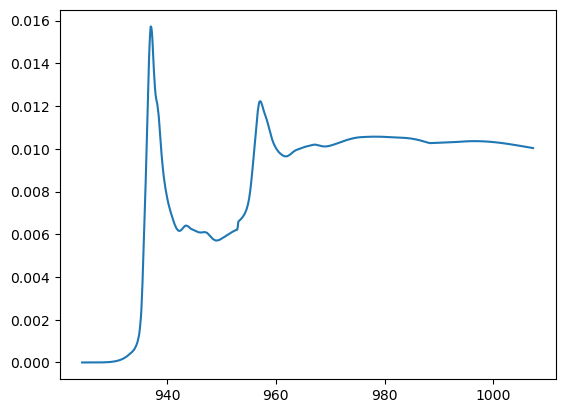

In [20]:
plt.plot(full_df_with_spectra_material_updated.iloc[900]['Scaled Energy (eV)'], 
            full_df_with_spectra_material_updated.iloc[900]['Scaled Intensities'])

In [21]:
L2_exp_path = 'C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Experimental_Cu_L2'
L3_exp_path = 'C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Experimental_Cu_L3'

experimental_cu_df = build_spectrum_from_FEFF(L2_exp_path, L3_exp_path, len(L2_exp_path)+1, 'Cu')

934 934
0


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
2


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
3


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
4


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
5


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
6


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
7


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
8


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
9


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
10


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.125, 3: 0.125, 6: 0.25, 9: 0.25}
added successfully
11


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
12


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
13


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
14


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
15


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
16


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
17


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
18


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
19


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
20


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
21


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
22


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
23


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
24


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
25


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
26


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
27


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
28


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
29


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
added successfully
30


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
31


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
32


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
33


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
34


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
35


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
36


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
37


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 2: 0.5}
added successfully
38


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
39


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
40


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
41


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
42


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
43


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
44


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
45


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
46


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
47


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
48


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
49


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
50


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
51


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
52


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
53


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
54


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 5: 0.25, 6: 0.5}
added successfully
55


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
56


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
57


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
58


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
59


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
60


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
61


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
62


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
63


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
64


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
65


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
66


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
67


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
68


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
69


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
70


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
71


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
72


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
73


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
74


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
75


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
76


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
77


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
78


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
79


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
80


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
81


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 5: 0.5, 10: 0.25}
added successfully
82


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
83


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.75}
added successfully
84


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
85


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
86


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
87


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
88


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
89


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
90


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
91


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 6: 0.75}
added successfully
92


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
93


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
94


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
95


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
96


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
97


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
98


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
99


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
100


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
101


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
102


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
103


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
104


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
105


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
106


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
107


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
108


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
109


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
110


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
111


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
112


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
113


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
114


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 2: 0.5}
added successfully
115


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
116


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
117


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
118


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
119


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 1: 0.4, 3: 0.4}
added successfully
120


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
121


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
122


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
123


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
124


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
125


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.375, 7: 0.125, 9: 0.125, 12: 0.375}
added successfully
126


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
127


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
128


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
129


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
130


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
131


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
132


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
133


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 2: 0.5}
added successfully
134


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
135


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
136


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
137


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
138


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
139


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
140


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 8: 0.75}
added successfully
141


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
142


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
143


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
144


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
145


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
146


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
147


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
148


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
149


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
150


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
151


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
added successfully
152


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
153


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
154


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
155


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
156


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
157


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.5, 13: 0.5}
added successfully
158


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
159


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
160


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
161


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
162


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
16
added successfully
163


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
164


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
165


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
166


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
167


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
168


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
169


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
170


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
171


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
172


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.4444444444444444, 14: 0.1111111111111111, 16: 0.4444444444444444}
added successfully
173


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
174


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
175


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
176


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
177


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 4: 0.5}
added successfully
178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
179


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 8: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
180


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
181


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
182


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
183


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
184


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 8: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
185


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 8: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
186


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
187


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 3: 0.5}
added successfully
188


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.5}
added successfully
189


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.5, 7: 0.5}
added successfully
190


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 8: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
192


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
193


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
194


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
16
added successfully
195


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
196


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
16
added successfully
197


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
198


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 8: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
199


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
200


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 6: 0.25, 8: 0.25, 10: 0.25}
added successfully
201


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 1: 0.2, 2: 0.4, 4: 0.2}
added successfully
202


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.375, 12: 0.375, 18: 0.125, 20: 0.125}
added successfully
203


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
204


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
205


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
206


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
207


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
208


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.043478260869565216, 7: 0.2608695652173913, 13: 0.34782608695652173, 21: 0.34782608695652173}
added successfully
209


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.07142857142857142, 1: 0.07142857142857142, 2: 0.21428571428571427, 5: 0.21428571428571427, 8: 0.21428571428571427, 11: 0.21428571428571427}
added successfully
210


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.3333333333333333}
added successfully
211


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
212


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.043478260869565216, 7: 0.2608695652173913, 13: 0.34782608695652173, 21: 0.34782608695652173}
added successfully
213


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 6: 0.6666666666666666}
added successfully
214


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
215


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
216


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
217


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
218


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 5: 0.5}
added successfully
219


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
220


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
221


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.043478260869565216, 7: 0.2608695652173913, 13: 0.34782608695652173, 21: 0.34782608695652173}
added successfully
222


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
223


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
224


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
225


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
226


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
227


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.043478260869565216, 7: 0.2608695652173913, 13: 0.34782608695652173, 21: 0.34782608695652173}
added successfully
228


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
229


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
230


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 6: 0.25, 8: 0.25, 10: 0.25}
added successfully
231


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
232


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.3333333333333333}
added successfully
233


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
234


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
235


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
236


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 12: 0.25, 16: 0.25, 20: 0.25}
added successfully
237


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
238


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
239


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
240


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
16
added successfully
241


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
16
added successfully
242


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
243


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
244


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
245


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.3333333333333333, 16: 0.3333333333333333, 20: 0.3333333333333333}
added successfully
246


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
247


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
248


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
249


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.3333333333333333, 16: 0.3333333333333333, 20: 0.3333333333333333}
added successfully
250


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
251


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2222222222222222, 6: 0.2222222222222222, 8: 0.2222222222222222, 10: 0.1111111111111111, 11: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
252


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
253


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
254


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 3: 0.2, 5: 0.2, 7: 0.2, 9: 0.2}
added successfully
255


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
256


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
257


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
258


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
259


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
260


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
261


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
262


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
263


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
264


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
265


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
266


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 12: 0.25, 16: 0.25, 20: 0.25}
added successfully
267


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
268


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
269


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
270


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
38
added successfully
271


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
272


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
273


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
274


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 6: 0.3333333333333333}
added successfully
275


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
276


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
277


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
278


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
279


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
280


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{18: 0.3333333333333333, 19: 0.6666666666666666}
added successfully
281


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
282


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
283


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
38
added successfully
284


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
285


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
286


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
287


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
288


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
289


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
290


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 12: 0.25, 16: 0.25, 20: 0.25}
added successfully
291


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
292


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 6: 0.3333333333333333}
added successfully
293


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
294


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
295


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
296


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
297


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
298


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 6: 0.25, 8: 0.5}
added successfully
299


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
32
added successfully
300


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
301


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 8: 0.16666666666666666, 10: 0.16666666666666666}
added successfully
302


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
303


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
304


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.125, 2: 0.125, 4: 0.125, 6: 0.125, 8: 0.125, 10: 0.125, 12: 0.125, 14: 0.125}
added successfully
305


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
306


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
92
added successfully
307


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
308


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
309


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
310


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
311


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{27: 0.3333333333333333, 31: 0.6666666666666666}
added successfully
312


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.6666666666666666}
added successfully
313


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.5, 11: 0.5}
added successfully
314


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
315


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
18
added successfully
316


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.25, 4: 0.25, 6: 0.5}
added successfully
317


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
318


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
319


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
320


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.1, 18: 0.1, 20: 0.1, 22: 0.1, 24: 0.1, 26: 0.1, 28: 0.1, 30: 0.1, 32: 0.1, 34: 0.1}
added successfully
321


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
322


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
323


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
28
added successfully
324


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
325


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 6: 0.25, 8: 0.25}
added successfully
326


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
327


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
328


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 6: 0.3333333333333333}
added successfully
329


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
330


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
331


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
332


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 4: 0.25, 8: 0.25, 12: 0.25}
added successfully
333


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
334


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
335


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
336


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5]
0
2
6
8
10
14
added successfully
337


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.2, 12: 0.2, 16: 0.2, 20: 0.2}
added successfully
338


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
339


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.3333333333333333, 8: 0.3333333333333333}
added successfully
340


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
341


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
342


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 6: 0.6666666666666666}
added successfully
343


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
12
added successfully
344


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
345


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
346


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
347


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
348


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.16666666666666666, 9: 0.16666666666666666, 10: 0.16666666666666666, 11: 0.16666666666666666, 12: 0.16666666666666666, 13: 0.16666666666666666}
added successfully
349


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 4: 0.5}
added successfully
350


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
351


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[8]
40
added successfully
352


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
353


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
354


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
355


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
356


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.125, 6: 0.125, 8: 0.25, 12: 0.25, 16: 0.25}
added successfully
357


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 6: 0.3333333333333333, 8: 0.3333333333333333}
added successfully
358


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
359


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
360


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{11: 0.05555555555555555, 12: 0.1111111111111111, 14: 0.1111111111111111, 16: 0.1111111111111111, 18: 0.1111111111111111, 20: 0.2222222222222222, 24: 0.2222222222222222, 28: 0.05555555555555555}
added successfully
361


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
362


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
363


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
364


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
365


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
366


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
367


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
368


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
369


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
370


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
371


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.3333333333333333, 8: 0.16666666666666666, 10: 0.16666666666666666}
added successfully
372


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
373


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
374


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
375


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
376


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
377


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
378


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
379


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
380


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
381


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
382


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
383


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
384


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
385


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
386


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
387


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
388


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
389


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
390


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
391


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
392


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
393


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
394


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
395


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
396


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
397


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
398


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
399


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
400


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
401


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
402


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
403


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
404


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
405


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.6666666666666666, 18: 0.3333333333333333}
added successfully
406


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
407


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
408


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
409


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.75, 8: 0.25}
error
410


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
411


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
412


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
413


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
414


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
415


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
416


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 5: 0.6666666666666666}
added successfully
417


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
418


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
419


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.3333333333333333, 8: 0.3333333333333333}
added successfully
420


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
421


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
422


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
423


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
424


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
425


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
426


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
427


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
428


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
429


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
430


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 9: 0.3333333333333333}
added successfully
431


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
432


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
433


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
434


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
435


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.16666666666666666, 24: 0.16666666666666666}
added successfully
436


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
437


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
438


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
439


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
440


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
441


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
442


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
443


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
444


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
445


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
446


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
447


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
448


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
449


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
450


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
451


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
452


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
453


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
454


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
455


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
456


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
457


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
458


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
459


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
460


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
461


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
462


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
463


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
464


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
465


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
466


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
467


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
468


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3157894736842105, 9: 0.3157894736842105, 14: 0.15789473684210525, 18: 0.15789473684210525, 21: 0.05263157894736842}
added successfully
469


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.3333333333333333, 16: 0.16666666666666666, 20: 0.16666666666666666, 24: 0.16666666666666666}
added successfully
470


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{18: 0.5, 22: 0.5}
added successfully
471


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
472


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
473


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
474


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.14285714285714285, 8: 0.2857142857142857, 16: 0.2857142857142857, 24: 0.2857142857142857}
added successfully
475


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
476


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
477


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
478


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
479


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
480


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
481


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
482


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
483


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
484


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
485


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
486


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
487


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
488


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
489


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 6: 0.3333333333333333}
added successfully
490


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
491


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
492


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
493


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
494


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
495


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
496


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
497


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
498


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
499


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
500


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
501


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
502


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
503


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
504


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
505


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
506


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
507


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
508


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
509


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
510


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
240
added successfully
511


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
512


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
513


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
514


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
515


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
516


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
517


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
518


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
519


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
520


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
521


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.2, 12: 0.2, 16: 0.2, 20: 0.2, 24: 0.2}
added successfully
522


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.4, 2: 0.4, 4: 0.2}
added successfully
523


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
524


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6, 8: 0.4}
added successfully
525


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
526


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.14285714285714285, 6: 0.14285714285714285, 8: 0.14285714285714285, 10: 0.14285714285714285, 12: 0.14285714285714285, 14: 0.14285714285714285, 16: 0.14285714285714285}
added successfully
527


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 12: 0.25, 16: 0.25, 20: 0.25}
added successfully
528


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
529


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
530


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 5: 0.5}
added successfully
531


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
532


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
533


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.18181818181818182, 7: 0.18181818181818182, 10: 0.18181818181818182, 12: 0.18181818181818182, 14: 0.18181818181818182, 16: 0.09090909090909091}
added successfully
534


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
535


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
536


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.14285714285714285, 4: 0.14285714285714285, 8: 0.14285714285714285, 12: 0.14285714285714285, 16: 0.14285714285714285, 20: 0.14285714285714285, 24: 0.14285714285714285}
added successfully
537


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
538


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
539


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
540


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
541


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.2, 12: 0.2, 14: 0.2, 16: 0.2, 18: 0.2}
added successfully
542


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
543


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
added successfully
544


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
545


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
546


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{9: 0.1111111111111111, 13: 0.1111111111111111, 17: 0.1111111111111111, 21: 0.1111111111111111, 25: 0.1111111111111111, 29: 0.1111111111111111, 33: 0.1111111111111111, 37: 0.2222222222222222}
added successfully
547


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.16666666666666666, 24: 0.16666666666666666}
added successfully
548


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
549


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.125, 2: 0.125, 4: 0.25, 8: 0.5}
added successfully
550


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.1, 1: 0.3, 4: 0.1, 5: 0.1, 6: 0.3, 9: 0.1}
error
551


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 4: 0.3333333333333333}
error
552


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
added successfully
553


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{20: 0.75, 26: 0.25}
added successfully
554


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.3333333333333333}
added successfully
555


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.3333333333333333}
added successfully
556


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
557


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
558


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
559


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
560


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
561


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
562


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
563


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
564


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
565


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
566


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
567


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
568


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
569


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
570


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
571


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
572


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
573


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
574


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
575


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
576


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.25, 4: 0.25, 6: 0.25, 8: 0.25}
added successfully
577


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
578


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
579


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
580


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
581


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.5, 3: 0.25}
added successfully
582


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
583


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
584


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
585


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
586


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
587


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
588


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
589


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
590


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
591


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666}
added successfully
592


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
593


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
594


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
595


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
596


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
597


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
3
added successfully
598


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
599


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
600


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
601


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
602


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
603


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
added successfully
604


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
605


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
606


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
607


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
608


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
609


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
610


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 3: 0.25, 6: 0.25}
added successfully
611


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
612


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.42857142857142855, 3: 0.42857142857142855, 6: 0.14285714285714285}
added successfully
613


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
614


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
615


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.3333333333333333, 8: 0.3333333333333333}
added successfully
616


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
617


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
618


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
619


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 4: 0.25, 6: 0.25}
added successfully
620


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
621


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
622


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
623


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 4: 0.3333333333333333, 6: 0.3333333333333333}
added successfully
624


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.4, 16: 0.4}
added successfully
625


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.3333333333333333, 3: 0.3333333333333333}
added successfully
626


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
627


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{11: 0.3333333333333333, 12: 0.3333333333333333, 15: 0.3333333333333333}
added successfully
628


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
629


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
630


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.1, 6: 0.6, 18: 0.2, 22: 0.1}
added successfully
631


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
632


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
633


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.1111111111111111, 10: 0.1111111111111111, 12: 0.6666666666666666}
added successfully
634


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
635


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
636


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
637


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
638


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
639


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
640


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
641


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
13
added successfully
642


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
643


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
644


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
645


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
646


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
647


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.3333333333333333, 8: 0.16666666666666666, 11: 0.16666666666666666}
added successfully
648


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.16666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 7: 0.16666666666666666, 11: 0.16666666666666666}
added successfully
649


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
650


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
651


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
652


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
653


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 5: 0.5}
added successfully
654


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
655


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.42857142857142855, 2: 0.42857142857142855, 3: 0.14285714285714285}
added successfully
656


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.1111111111111111, 5: 0.1111111111111111, 6: 0.1111111111111111, 7: 0.1111111111111111, 8: 0.1111111111111111, 9: 0.1111111111111111, 11: 0.1111111111111111, 14: 0.1111111111111111, 18: 0.1111111111111111}
added successfully
657


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.125, 2: 0.25, 6: 0.25, 10: 0.25, 14: 0.125}
added successfully
658


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.16666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666, 4: 0.16666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666}
added successfully
659


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
660


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
661


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
662


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
663


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
664


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
665


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
666


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
667


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
668


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
669


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
670


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.6666666666666666, 13: 0.3333333333333333}
added successfully
671


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
672


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
673


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
6
added successfully
674


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.5, 11: 0.5}
added successfully
675


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
676


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
677


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
678


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
679


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
680


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
681


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
682


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
683


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
684


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.3333333333333333, 7: 0.3333333333333333}
added successfully
685


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.5, 8: 0.5}
added successfully
686


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4, 3: 0.2, 5: 0.4}
added successfully
687


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
688


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
689


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
690


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
691


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
692


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
693


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 1: 0.3333333333333333}
added successfully
694


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
695


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
696


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
697


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
698


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
699


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
700


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
701


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
30
added successfully
702


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
703


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.4, 10: 0.4, 13: 0.2}
added successfully
704


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
705


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
706


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.3333333333333333, 11: 0.6666666666666666}
added successfully
707


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
708


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
709


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
710


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
711


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
712


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
713


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 9: 0.5}
added successfully
714


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
715


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
716


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
717


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
718


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
719


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 9: 0.5}
added successfully
720


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.5, 13: 0.5}
added successfully
721


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
12
added successfully
722


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.2222222222222222, 7: 0.2222222222222222, 9: 0.2222222222222222, 10: 0.1111111111111111, 13: 0.1111111111111111, 14: 0.1111111111111111}
added successfully
723


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
724


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
725


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
726


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
727


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
728


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
729


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
730


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
731


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
732


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
733


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666, 8: 0.16666666666666666, 13: 0.16666666666666666, 17: 0.16666666666666666}
added successfully
734


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
735


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
736


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{15: 0.3333333333333333, 16: 0.6666666666666666}
added successfully
737


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
12
added successfully
738


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.375, 11: 0.25, 12: 0.375}
added successfully
739


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
740


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.1, 1: 0.3, 4: 0.1, 5: 0.1, 6: 0.3, 9: 0.1}
added successfully
741


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 3: 0.4444444444444444, 12: 0.1111111111111111}
added successfully
742


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.06666666666666667, 1: 0.13333333333333333, 3: 0.13333333333333333, 5: 0.13333333333333333, 7: 0.13333333333333333, 9: 0.13333333333333333, 11: 0.13333333333333333, 13: 0.13333333333333333}
added successfully
743


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
744


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
745


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
746


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
747


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
748


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3, 1: 0.1, 3: 0.3, 7: 0.3}
added successfully
749


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
750


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
751


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
752


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 3: 0.4444444444444444, 9: 0.1111111111111111}
added successfully
753


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
754


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
755


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 8: 0.125, 11: 0.25, 16: 0.125}
added successfully
756


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.25, 3: 0.5, 4: 0.25}
added successfully
757


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[8]
20
added successfully
758


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 6: 0.4444444444444444, 16: 0.1111111111111111}
added successfully
759


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
760


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{42: 0.4, 43: 0.4, 45: 0.2}
added successfully
761


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
762


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
763


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
764


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
765


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4, 3: 0.2, 5: 0.4}
added successfully
766


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
767


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
768


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
769


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
770


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.8, 3: 0.2}
added successfully
771


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.041666666666666664, 1: 0.041666666666666664, 2: 0.041666666666666664, 4: 0.041666666666666664, 5: 0.041666666666666664, 6: 0.041666666666666664, 7: 0.041666666666666664, 8: 0.041666666666666664, 9: 0.041666666666666664, 10: 0.041666666666666664, 11: 0.041666666666666664, 12: 0.041666666666666664, 13: 0.041666666666666664, 14: 0.041666666666666664, 15: 0.041666666666666664, 17: 0.041666666666666664, 19: 0.041666666666666664, 20: 0.041666666666666664, 21: 0.041666666666666664, 22: 0.041666666666666664, 23: 0.041666666666666664, 29: 0.041666666666666664, 38: 0.041666666666666664, 44: 0.041666666666666664}
added successfully
772


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
773


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
774


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
775


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
added successfully
776


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
16
added successfully
777


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
778


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
779


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
780


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
781


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
782


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
783


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
784


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
785


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
786


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
787


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}
added successfully
788


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.3333333333333333}
added successfully
789


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 9: 0.25, 10: 0.25, 11: 0.25}
added successfully
790


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 3: 0.4444444444444444, 17: 0.1111111111111111}
added successfully
791


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
792


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
793


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
794


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
795


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
796


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
797


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
798


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.1, 3: 0.1, 4: 0.1, 6: 0.1, 7: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 16: 0.1}
added successfully
799


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
800


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
801


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
802


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.125, 1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125}
added successfully
803


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
804


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
805


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.3333333333333333, 6: 0.3333333333333333}
added successfully
806


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
807


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
808


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
809


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
810


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
811


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
812


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
813


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
814


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
815


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 5: 0.3333333333333333, 6: 0.16666666666666666, 7: 0.16666666666666666, 9: 0.16666666666666666}
added successfully
816


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
817


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.6666666666666666, 12: 0.3333333333333333}
added successfully
818


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
819


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.3333333333333333, 6: 0.3333333333333333}
added successfully
820


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
821


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.6, 11: 0.2, 15: 0.2}
added successfully
822


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
823


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
824


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 1: 0.2, 2: 0.1, 6: 0.2, 9: 0.1, 14: 0.1, 29: 0.1}
added successfully
825


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.07692307692307693, 4: 0.9230769230769231}
added successfully
826


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.6666666666666666}
added successfully
827


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
828


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
829


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
830


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.16666666666666666, 1: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.3333333333333333, 7: 0.08333333333333333, 10: 0.08333333333333333}
added successfully
831


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
832


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
833


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
834


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
835


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{54: 0.8571428571428571, 62: 0.14285714285714285}
added successfully
836


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.2, 15: 0.2, 16: 0.1, 17: 0.2, 25: 0.1, 26: 0.1, 27: 0.1}
added successfully
837


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{26: 0.2, 27: 0.4, 29: 0.4}
added successfully
838


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
839


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
840


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
841


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
842


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
843


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 12: 0.3333333333333333}
added successfully
844


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 4: 0.25, 6: 0.25}
added successfully
845


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
846


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.16666666666666666, 1: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666}
added successfully
847


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{20: 0.1, 21: 0.1, 22: 0.1, 23: 0.1, 24: 0.1, 25: 0.1, 26: 0.1, 27: 0.1, 28: 0.1, 29: 0.1}
added successfully
848


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
40
added successfully
849


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
850


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
851


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 5: 0.25, 8: 0.25, 10: 0.25}
added successfully
852


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
853


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
854


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
855


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
856


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
857


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 3: 0.25, 4: 0.25}
added successfully
858


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
859


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
added successfully
860


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
861


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
862


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2222222222222222, 1: 0.2222222222222222, 3: 0.2222222222222222, 8: 0.2222222222222222, 9: 0.1111111111111111}
added successfully
863


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.047619047619047616, 1: 0.047619047619047616, 2: 0.09523809523809523, 3: 0.09523809523809523, 5: 0.047619047619047616, 7: 0.09523809523809523, 8: 0.09523809523809523, 9: 0.09523809523809523, 10: 0.09523809523809523, 11: 0.09523809523809523, 13: 0.047619047619047616, 16: 0.047619047619047616, 17: 0.047619047619047616, 20: 0.047619047619047616}
added successfully
864


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
865


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.18181818181818182, 11: 0.18181818181818182, 13: 0.09090909090909091, 14: 0.18181818181818182, 16: 0.18181818181818182, 17: 0.18181818181818182}
added successfully
866


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{28: 0.16666666666666666, 30: 0.08333333333333333, 31: 0.08333333333333333, 32: 0.08333333333333333, 34: 0.08333333333333333, 36: 0.08333333333333333, 39: 0.16666666666666666, 42: 0.16666666666666666, 45: 0.041666666666666664, 62: 0.041666666666666664}
added successfully
867


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
868


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
869


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
870


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
871


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
872


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
873


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
874


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
875


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 5: 0.5}
added successfully
876


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
877


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
878


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
879


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
880


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
881


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
882


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
883


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
884


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
885


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 4: 0.25, 6: 0.25}
added successfully
886


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
887


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
888


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
889


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
890


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
891


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
892


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
893


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
894


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 4: 0.25, 6: 0.25}
added successfully
895


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
896


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
897


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
898


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 6: 0.4, 10: 0.4}
added successfully
899


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 4: 0.4, 12: 0.4}
added successfully
900


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
901


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
902


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
903


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
904


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
905


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
906


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}
added successfully
907


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
908


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
909


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.75}
added successfully
910


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
911


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.2, 8: 0.4, 12: 0.4}
added successfully
912


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
913


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
914


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
915


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
916


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
917


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
918


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
919


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
920


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
921


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
922


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
923


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 4: 0.2, 8: 0.2, 12: 0.2, 16: 0.2}
added successfully
924


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
925


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
926


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 4: 0.3333333333333333, 6: 0.3333333333333333}
added successfully
927


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
928


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
929


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
930


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
931


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
932


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
933
error


In [22]:
L2_stable_path = 'C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L2'
L3_stable_path = 'C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L3'

stable_cu_df = build_spectrum_from_FEFF(L2_stable_path, L3_stable_path, len(L2_stable_path)+1, 'Cu')

1243 1243
0


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
2


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
3


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
4


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
5


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
6


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
7


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
8


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
9


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
10


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
11


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
12


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
13


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
14


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
15


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
16


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
17


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
18


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
19


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
20


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
21


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
22


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
23


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
24


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
25


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
26


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
27


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
28


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
29


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
30


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
31


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
32


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
33


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
34


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
35


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
36


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
37


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
38


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
39


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
40


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
41


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
42


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
43


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
44


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
45


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
46


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
47


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
48


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
49


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
50


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
51


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
52


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
53


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
54


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
55


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
56


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
57


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
58


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
59


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
60


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
61


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
62


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
63


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
64


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
65


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
66


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
67


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
68


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
69


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
70


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
71


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
72


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
73


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
74


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 3: 0.5}
added successfully
75


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
76


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
77


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
78


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
79


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
80


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
81


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
82


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
83


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
84


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
85


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
86


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
87


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
88


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
89


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
90


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
91


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
92


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
93


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
94


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
95


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
96


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
97


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
98


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
99


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
100


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
101


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
102


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
103


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
104


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
105


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
106


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
107


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
108


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
109


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
110


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
111


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
112


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
113


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
10
added successfully
114


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
115


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
116


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
117


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
118


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
119


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
120


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
121


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
122


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
123


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
124


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
10
added successfully
125


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
126


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
127


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
20
added successfully
128


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
129


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
130


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666, 8: 0.16666666666666666}
added successfully
131


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
132


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
133


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
134


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
135


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
136


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
137


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
138


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
139


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
140


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
141


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
142


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
143


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
144


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
145


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
146


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3, 4]
9
11
added successfully
147


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 6: 0.3333333333333333}
added successfully
148


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{11: 0.3333333333333333, 12: 0.6666666666666666}
added successfully
149


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
150


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
151


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
152


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
153


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
154


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
155


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
156


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
157


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
158


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
159


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5, 6]
12
14
added successfully
160


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
161


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
162


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
163


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
164


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
165


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
166


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
167


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
168


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
169


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
170


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
171


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 10: 0.5}
added successfully
172


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
173


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
174


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
175


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
176


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6, 2: 0.4}
error
177


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
179


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
180


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
181


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
182


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
183


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
184


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
185


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 2]
1
2
added successfully
186


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
187


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
188


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
189


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
190


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
192


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
193


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
194


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
195


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
196


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
197


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
198


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
199


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
200


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
201


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
202


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
203


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
204


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
205


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
206


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
207


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
208


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
209


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
210


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
211


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
212


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
213


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
214


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
215


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
216


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
217


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
218


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
219


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
220


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
221


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
222


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
223


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
224


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
225


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
226


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
227


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
228


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
229


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.4, 22: 0.4, 30: 0.2}
added successfully
230


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
231


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
232


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
233


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
234


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 8: 0.5}
added successfully
235


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 8: 0.25, 12: 0.25, 16: 0.25}
added successfully
236


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
237


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
238


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
239


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
240


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
241


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
242


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
243


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
244


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
245


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
246


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
247


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
248


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
249


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
250


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.4444444444444444, 14: 0.4444444444444444, 22: 0.1111111111111111}
added successfully
251


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
252


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.3333333333333333, 16: 0.6666666666666666}
added successfully
253


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
254


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
255


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
8
added successfully
256


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
257


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
258


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
259


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
260


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 10: 0.4444444444444444, 18: 0.1111111111111111}
added successfully
261


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4444444444444444, 10: 0.4444444444444444, 18: 0.1111111111111111}
added successfully
262


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
263


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
264


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.3333333333333333}
added successfully
265


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
266


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
267


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
268


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
269


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
270


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{22: 0.14285714285714285, 23: 0.8571428571428571}
added successfully
271


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.5, 21: 0.5}
added successfully
272


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{22: 0.14285714285714285, 23: 0.8571428571428571}
added successfully
273


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.2, 12: 0.2, 16: 0.4}
added successfully
274


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.07692307692307693, 4: 0.9230769230769231}
added successfully
275


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 6: 0.6666666666666666}
added successfully
276


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.4, 11: 0.6}
added successfully
277


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.16666666666666666, 18: 0.16666666666666666, 20: 0.16666666666666666, 22: 0.16666666666666666, 24: 0.16666666666666666, 26: 0.16666666666666666}
added successfully
278


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
16
added successfully
279


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
280


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
281


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
282


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
283


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
42
added successfully
284


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.25, 20: 0.25, 28: 0.125, 32: 0.125, 36: 0.125, 40: 0.125}
added successfully
285


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
286


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
287


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.1111111111111111, 20: 0.1111111111111111, 24: 0.1111111111111111, 28: 0.16666666666666666, 34: 0.16666666666666666, 40: 0.3333333333333333}
added successfully
288


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{32: 0.125, 40: 0.125, 48: 0.125, 56: 0.125, 64: 0.125, 72: 0.125, 80: 0.125, 88: 0.125}
added successfully
289


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
290


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
291


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
292


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
293


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 6: 0.6666666666666666}
added successfully
294


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
295


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
32
added successfully
296


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{18: 0.3333333333333333, 20: 0.3333333333333333, 22: 0.3333333333333333}
added successfully
297


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
298


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
299


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.4, 22: 0.4, 30: 0.2}
added successfully
300


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
301


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 8: 0.3333333333333333, 10: 0.3333333333333333}
added successfully
302


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
303


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
304


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
32
added successfully
305


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
306


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.1, 20: 0.1, 24: 0.1, 28: 0.1, 32: 0.2, 40: 0.2, 48: 0.1, 52: 0.1}
added successfully
307


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
308


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
309


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
310


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
311


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
312


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
313


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
314


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
315


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
316


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
317


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
318


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
319


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
320


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
321


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
322


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
323


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
324


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
325


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
326


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
327


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
328


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
329


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
330


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
331


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
332


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
333


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
334


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
335


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
336


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
337


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
338


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
339


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.5}
added successfully
340


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
3
added successfully
341


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
342


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
343


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
344


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
345


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
21
added successfully
346


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
347


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
20
added successfully
348


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.4, 16: 0.2, 20: 0.2}
added successfully
349


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
12
added successfully
350


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.4, 16: 0.2, 20: 0.2}
added successfully
351


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
22
added successfully
352


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
10
added successfully
353


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
21
added successfully
354


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
355


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
356


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
357


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
358


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
359


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
360


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
361


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
362


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
363


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
364


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
365


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
366


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
367


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.2, 12: 0.4, 20: 0.2, 24: 0.2}
added successfully
368


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
369


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
370


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
371


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
372


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
373


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
374


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
375


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.16666666666666666, 10: 0.16666666666666666, 14: 0.16666666666666666, 18: 0.16666666666666666, 22: 0.16666666666666666, 26: 0.16666666666666666}
added successfully
376


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
377


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
378


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 8: 0.5}
added successfully
379


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
380


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
381


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
382


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.2, 8: 0.4, 16: 0.2, 20: 0.2}
added successfully
383


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
14
added successfully
384


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
385


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
386


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.16666666666666666, 10: 0.16666666666666666, 14: 0.16666666666666666, 18: 0.16666666666666666, 22: 0.16666666666666666, 26: 0.16666666666666666}
added successfully
387


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{66: 0.047619047619047616, 69: 0.047619047619047616, 72: 0.047619047619047616, 75: 0.047619047619047616, 78: 0.047619047619047616, 81: 0.047619047619047616, 84: 0.047619047619047616, 87: 0.047619047619047616, 90: 0.047619047619047616, 93: 0.047619047619047616, 96: 0.047619047619047616, 99: 0.047619047619047616, 102: 0.047619047619047616, 105: 0.047619047619047616, 108: 0.047619047619047616, 111: 0.047619047619047616, 114: 0.047619047619047616, 117: 0.047619047619047616, 120: 0.047619047619047616, 123: 0.047619047619047616, 126: 0.047619047619047616}
added successfully
388


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
21
added successfully
389


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
390


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
391


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
392


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
393


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
394


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
395


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
396


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
397


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
398


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
399


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
400


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
401


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
402


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 8: 0.25, 12: 0.25}
added successfully
403


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
404


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 4: 0.3333333333333333, 8: 0.3333333333333333}
added successfully
405


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
406


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.16666666666666666, 10: 0.16666666666666666, 14: 0.16666666666666666, 18: 0.16666666666666666, 22: 0.16666666666666666, 26: 0.16666666666666666}
added successfully
407


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.4, 16: 0.2, 20: 0.2, 24: 0.2}
added successfully
408


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
21
added successfully
409


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
3
added successfully
410


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
411


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
412


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
413


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
414


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
415


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
416


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
417


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
418


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
16
added successfully
419


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
420


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
421


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
422


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
28
added successfully
423


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
28
added successfully
424


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
425


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
426


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5714285714285714, 10: 0.14285714285714285, 11: 0.2857142857142857}
added successfully
427


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
428


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{13: 0.125, 15: 0.125, 17: 0.125, 19: 0.125, 21: 0.125, 23: 0.125, 25: 0.125, 27: 0.125}
added successfully
429


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
430


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
431


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
432


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.8, 6: 0.2}
added successfully
433


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
434


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.25, 3: 0.75}
added successfully
435


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
436


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.8, 12: 0.2}
added successfully
437


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
438


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
3
added successfully
439


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
440


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
441


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
442


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.8, 12: 0.2}
added successfully
443


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{35: 0.058823529411764705, 36: 0.058823529411764705, 37: 0.058823529411764705, 38: 0.058823529411764705, 39: 0.058823529411764705, 40: 0.058823529411764705, 41: 0.058823529411764705, 42: 0.058823529411764705, 43: 0.058823529411764705, 44: 0.058823529411764705, 45: 0.058823529411764705, 46: 0.058823529411764705, 47: 0.058823529411764705, 48: 0.058823529411764705, 49: 0.058823529411764705, 50: 0.058823529411764705, 51: 0.058823529411764705}
added successfully
444


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
445


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.5, 12: 0.5}
added successfully
446


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4, 3: 0.4, 6: 0.2}
added successfully
447


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 2, 3]
2
3
4
added successfully
448


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
449


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.8, 12: 0.2}
added successfully
450


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
451


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.058823529411764705, 17: 0.058823529411764705, 20: 0.11764705882352941, 23: 0.11764705882352941, 32: 0.0196078431372549, 33: 0.0196078431372549, 34: 0.11764705882352941, 37: 0.11764705882352941, 46: 0.0392156862745098, 47: 0.0392156862745098, 50: 0.11764705882352941, 53: 0.11764705882352941, 62: 0.058823529411764705}
added successfully
452


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.07692307692307693, 3: 0.07692307692307693, 4: 0.07692307692307693, 5: 0.07692307692307693, 10: 0.07692307692307693, 11: 0.07692307692307693, 12: 0.07692307692307693, 13: 0.07692307692307693, 14: 0.07692307692307693, 15: 0.07692307692307693, 22: 0.07692307692307693, 24: 0.07692307692307693, 25: 0.07692307692307693}
added successfully
453


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
454


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
455


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
456


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
457


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
458


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
459


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
460


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
4
added successfully
461


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
462


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.6666666666666666, 9: 0.3333333333333333}
added successfully
463


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
464


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
465


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
466


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
467


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
468


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{68: 0.5, 69: 0.25, 71: 0.25}
added successfully
469


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
470


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
4
added successfully
471


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
472


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
473


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
474


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
475


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.11764705882352941, 17: 0.11764705882352941, 26: 0.11764705882352941, 29: 0.11764705882352941, 38: 0.0196078431372549, 39: 0.0196078431372549, 40: 0.0392156862745098, 41: 0.0392156862745098, 44: 0.11764705882352941, 47: 0.11764705882352941, 56: 0.058823529411764705, 59: 0.058823529411764705, 62: 0.058823529411764705}
added successfully
476


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
477


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
478


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666}
added successfully
479


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666}
added successfully
480


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
481


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
482


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
483


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 9: 0.5, 11: 0.25}
added successfully
484


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
485


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{18: 0.3333333333333333, 19: 0.3333333333333333, 20: 0.3333333333333333}
added successfully
486


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.3333333333333333, 13: 0.3333333333333333, 14: 0.3333333333333333}
added successfully
487


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
488


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
489


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
490


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
491


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
492


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
493


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
494


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
495


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
496


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
4
added successfully
497


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
498


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{56: 0.3333333333333333, 57: 0.3333333333333333, 58: 0.3333333333333333}
added successfully
499


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
500


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
501


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
502


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
503


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
504


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.5, 13: 0.5}
added successfully
505


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
506


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.25, 2: 0.75}
added successfully
507


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
508


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
509


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
510


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.3333333333333333, 6: 0.3333333333333333}
added successfully
511


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
512


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
513


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
514


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
515


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 9: 0.5, 11: 0.25}
added successfully
516


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{56: 0.3333333333333333, 57: 0.3333333333333333, 58: 0.3333333333333333}
added successfully
517


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
518


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
519


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
520


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.5}
added successfully
521


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
522


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
523


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{9: 0.3333333333333333, 10: 0.3333333333333333, 11: 0.3333333333333333}
added successfully
524


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
525


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
526


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
527


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.3333333333333333, 6: 0.3333333333333333, 7: 0.3333333333333333}
added successfully
528


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
529


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.25, 12: 0.25, 13: 0.5}
added successfully
530


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
531


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
532


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
533


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
534


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
535


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
536


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
537


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
7
added successfully
538


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
539


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
540


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
541


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
542


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
543


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
544


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
545


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
546


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
547


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.6666666666666666}
added successfully
548


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 5: 0.5}
added successfully
549


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.8, 8: 0.2}
added successfully
550


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
551


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
552


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.2857142857142857, 6: 0.2857142857142857, 9: 0.14285714285714285, 10: 0.14285714285714285, 11: 0.14285714285714285}
added successfully
553


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
554


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
555


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.25, 2: 0.75}
added successfully
556


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
557


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
558


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{9: 0.5, 10: 0.5}
added successfully
559


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
560


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
561


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
562


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
563


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
564


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
3
added successfully
565


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
566


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
567


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
568


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
569


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.09090909090909091, 13: 0.09090909090909091, 14: 0.09090909090909091, 15: 0.09090909090909091, 16: 0.09090909090909091, 17: 0.09090909090909091, 18: 0.09090909090909091, 19: 0.09090909090909091, 20: 0.09090909090909091, 21: 0.09090909090909091, 22: 0.09090909090909091}
added successfully
570


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
5
added successfully
571


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
572


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
573


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.058823529411764705, 17: 0.058823529411764705, 20: 0.11764705882352941, 23: 0.11764705882352941, 32: 0.0196078431372549, 33: 0.0196078431372549, 34: 0.11764705882352941, 37: 0.11764705882352941, 46: 0.0392156862745098, 47: 0.0392156862745098, 50: 0.11764705882352941, 53: 0.11764705882352941, 62: 0.058823529411764705}
added successfully
574


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
575


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
576


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
577


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
578


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
579


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
580


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
581


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
582


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.25, 2: 0.75}
added successfully
583


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
584


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
585


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
586


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
587


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
588


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
589


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
590


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
591


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
592


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
593


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
594


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
595


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
596


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
597


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 2: 0.2, 4: 0.2, 6: 0.2, 8: 0.2}
added successfully
598


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
599


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
600


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
601


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2222222222222222, 1: 0.4444444444444444, 6: 0.2222222222222222, 8: 0.1111111111111111}
added successfully
602


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{20: 0.5, 21: 0.5}
added successfully
603


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
604


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
error
605


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.4, 3: 0.4, 6: 0.2}
added successfully
606


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
607


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
608


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
609


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
610


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
611


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 10: 0.3333333333333333}
added successfully
612


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
613


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 10: 0.3333333333333333}
added successfully
614


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
615


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
616


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
617


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
618


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
3
added successfully
619


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
620


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
621


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
622


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
623


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
624


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
625


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
626


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
627


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 8: 0.5}
added successfully
628


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
629


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.6666666666666666}
added successfully
630


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
631


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
632


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
633


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
8
added successfully
634


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
5
added successfully
635


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.6666666666666666, 11: 0.3333333333333333}
added successfully
636


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.14285714285714285, 9: 0.14285714285714285, 10: 0.14285714285714285, 11: 0.14285714285714285, 12: 0.14285714285714285, 13: 0.14285714285714285, 14: 0.14285714285714285}
added successfully
637


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
638


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{48: 0.16666666666666666, 56: 0.08333333333333333, 60: 0.16666666666666666, 68: 0.08333333333333333, 72: 0.16666666666666666, 80: 0.08333333333333333, 84: 0.16666666666666666, 92: 0.08333333333333333}
added successfully
639


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
640


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{7: 0.3333333333333333, 8: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
641


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.09090909090909091, 5: 0.09090909090909091, 6: 0.09090909090909091, 7: 0.09090909090909091, 8: 0.09090909090909091, 9: 0.09090909090909091, 10: 0.09090909090909091, 11: 0.09090909090909091, 12: 0.09090909090909091, 13: 0.09090909090909091, 14: 0.09090909090909091}
added successfully
642


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.3333333333333333}
added successfully
643


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
644


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
645


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.23529411764705882, 4: 0.23529411764705882, 5: 0.23529411764705882, 15: 0.11764705882352941, 16: 0.058823529411764705, 18: 0.11764705882352941}
added successfully
646


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
647


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
648


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
649


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{9: 0.16666666666666666, 10: 0.16666666666666666, 11: 0.16666666666666666, 15: 0.16666666666666666, 16: 0.16666666666666666, 17: 0.16666666666666666}
added successfully
650


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{49: 0.5, 50: 0.5}
added successfully
651


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 4: 0.5}
added successfully
652


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
4
added successfully
653


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
654


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
655


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
656


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
657


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
658


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
659


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
660


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
661


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
662


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
663


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.05263157894736842, 6: 0.05263157894736842, 7: 0.05263157894736842, 8: 0.05263157894736842, 9: 0.05263157894736842, 10: 0.05263157894736842, 11: 0.05263157894736842, 12: 0.05263157894736842, 13: 0.05263157894736842, 14: 0.05263157894736842, 15: 0.05263157894736842, 16: 0.05263157894736842, 17: 0.05263157894736842, 18: 0.05263157894736842, 19: 0.05263157894736842, 20: 0.05263157894736842, 21: 0.05263157894736842, 22: 0.05263157894736842, 23: 0.05263157894736842}
added successfully
664


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{15: 0.1, 16: 0.1, 17: 0.1, 18: 0.1, 19: 0.1, 25: 0.1, 26: 0.1, 27: 0.1, 28: 0.1, 29: 0.1}
added successfully
665


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
666


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
667


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 2: 0.5}
added successfully
668


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
669


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
8
added successfully
670


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
671


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
672


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
20
added successfully
673


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
674


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.4, 12: 0.2, 16: 0.2, 20: 0.2}
added successfully
675


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
676


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
677


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2, 3]
3
4
added successfully
678


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
679


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
680


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 4: 0.6666666666666666}
added successfully
681


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 8: 0.16666666666666666, 12: 0.16666666666666666, 16: 0.16666666666666666, 20: 0.16666666666666666}
added successfully
682


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
683


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
684


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
685


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
686


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
687


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
688


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
689


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
690


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
691


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
692


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
693


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
694


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 9: 0.1111111111111111, 14: 0.1111111111111111, 16: 0.1111111111111111}
added successfully
695


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.6666666666666666, 10: 0.1111111111111111, 12: 0.1111111111111111}
added successfully
696


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.3333333333333333, 10: 0.1111111111111111, 12: 0.05555555555555555, 13: 0.05555555555555555, 14: 0.3333333333333333}
added successfully
697


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
698


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
699


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
700


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
701


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
702


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.4, 12: 0.2, 16: 0.2, 20: 0.2}
added successfully
703


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.4, 20: 0.6}
added successfully
704


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
705


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
706


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
707


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
708


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.25, 6: 0.25}
added successfully
709


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 2: 0.5}
added successfully
710


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
711


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
712


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
713


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
714


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
715


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
716


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.18181818181818182, 8: 0.18181818181818182, 10: 0.18181818181818182, 12: 0.18181818181818182, 14: 0.18181818181818182, 16: 0.09090909090909091}
added successfully
717


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
718


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.75, 5: 0.25}
added successfully
719


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
720


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
721


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3, 4, 5]
9
10
11
added successfully
722


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.2, 13: 0.2, 16: 0.2, 20: 0.2, 24: 0.2}
added successfully
723


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
724


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.375, 14: 0.375, 16: 0.0625, 17: 0.1875}
added successfully
725


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
726


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
727


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
728


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
729


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
730


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{48: 0.6666666666666666, 50: 0.3333333333333333}
added successfully
731


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
732


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
733


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
32
added successfully
734


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 9: 0.3333333333333333}
added successfully
735


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
736


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
737


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
3
added successfully
738


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
739


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
740


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
741


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
742


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
743


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
744


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
745


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
746


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
12
added successfully
747


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
748


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
749


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
750


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
751


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
752


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
753


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
754


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
755


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
756


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
757


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
758


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
759


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6, 2: 0.4}
added successfully
760


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
761


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
762


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 2]
2
4
added successfully
763


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
764


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
765


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
766


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2, 3]
3
5
added successfully
767


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
768


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
769


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
770


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
771


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
772


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.25, 4: 0.25}
added successfully
773


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.6666666666666666, 13: 0.3333333333333333}
added successfully
774


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 14: 0.5}
added successfully
775


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.4, 16: 0.2, 20: 0.2, 24: 0.2}
added successfully
776


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
777


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.03571428571428571, 13: 0.03571428571428571, 14: 0.07142857142857142, 16: 0.07142857142857142, 18: 0.07142857142857142, 20: 0.07142857142857142, 22: 0.07142857142857142, 24: 0.07142857142857142, 26: 0.07142857142857142, 28: 0.07142857142857142, 30: 0.07142857142857142, 32: 0.07142857142857142, 34: 0.07142857142857142, 36: 0.07142857142857142, 38: 0.07142857142857142}
added successfully
778


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
779


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
780


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
781


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
782


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
783


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
784


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
785


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
786


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
787


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
788


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
789


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
790


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
791


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
792


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
793


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
794


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
795


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2, 3]
6
7
added successfully
796


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
797


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 3: 0.6666666666666666}
added successfully
798


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
799


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
800


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
801


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
802


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
803


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
804


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{5: 0.2, 6: 0.4, 8: 0.4}
added successfully
805


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6, 2: 0.4}
error
806


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
807


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
808


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
809


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6, 2: 0.4}
added successfully
810


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
811


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
812


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
813


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
814


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
815


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
816


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
817


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
818


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 2: 0.25, 4: 0.25, 6: 0.25}
added successfully
819


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
24
added successfully
820


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.4, 8: 0.2, 10: 0.4}
added successfully
821


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{36: 0.3333333333333333, 40: 0.3333333333333333, 44: 0.3333333333333333}
added successfully
822


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
823


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
824


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
825


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
826


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{32: 0.5, 40: 0.5}
added successfully
827


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 3: 0.5}
added successfully
828


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.3333333333333333, 14: 0.6666666666666666}
added successfully
829


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
830


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
831


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
832


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
833


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
834


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
835


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{21: 0.6666666666666666, 33: 0.3333333333333333}
added successfully
836


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
837


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
838


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
error
839


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
21
added successfully
840


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
841


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
error
842


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
843


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
844


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
845


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.6}
added successfully
846


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
847


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
848


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
849


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
850


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
851


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.2, 2: 0.8}
added successfully
852


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{21: 0.6666666666666666, 30: 0.3333333333333333}
added successfully
853


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
854


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
855


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
856


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
68
added successfully
857


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
858


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
859


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
860


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
861


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

error
862


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.6666666666666666}
added successfully
863


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
864


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.75}
added successfully
865


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
866


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
867


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
868


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
869


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
870


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
871


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
872


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
873


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
874


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
875


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
876


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
877


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
878


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
879


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
880


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 7: 0.3333333333333333}
added successfully
881


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
882


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
883


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
884


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
885


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
886


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
887


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
888


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
32
added successfully
889


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
890


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
891


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
892


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
893


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
894


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
895


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
896


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
897


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
898


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
899


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 4: 0.5}
added successfully
900


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
901


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
902


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
903


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
904


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
905


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
906


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 12: 0.5}
added successfully
907


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
908


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
909


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
910


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
911


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.2, 2: 0.2, 4: 0.2, 6: 0.2, 8: 0.2}
added successfully
912


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
913


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
914


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
915


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
916


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
917


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.1111111111111111, 10: 0.1111111111111111, 12: 0.6666666666666666}
added successfully
918


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
919


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
920


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
921


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.029411764705882353, 7: 0.029411764705882353, 8: 0.029411764705882353, 9: 0.029411764705882353, 10: 0.029411764705882353, 11: 0.029411764705882353, 12: 0.029411764705882353, 13: 0.029411764705882353, 14: 0.029411764705882353, 15: 0.029411764705882353, 16: 0.029411764705882353, 17: 0.029411764705882353, 18: 0.029411764705882353, 19: 0.029411764705882353, 20: 0.029411764705882353, 21: 0.029411764705882353, 22: 0.029411764705882353, 23: 0.029411764705882353, 24: 0.029411764705882353, 25: 0.029411764705882353, 26: 0.029411764705882353, 27: 0.029411764705882353, 28: 0.029411764705882353, 29: 0.029411764705882353, 30: 0.029411764705882353, 31: 0.029411764705882353, 32: 0.029411764705882353, 33: 0.029411764705882353, 34: 0.029411764705882353, 35: 0.029411764705882353, 36: 0.029411764705882353, 37: 0.029411764705882353, 38: 0.029411764705882353, 39: 0.029411764705882353}
added successfully
922


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
923


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{47: 0.2857142857142857, 48: 0.14285714285714285, 49: 0.2857142857142857, 50: 0.2857142857142857}
added successfully
924


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
925


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.25, 10: 0.5, 14: 0.25}
added successfully
926


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
927


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
928


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
929


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
930


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.1111111111111111, 8: 0.1111111111111111, 10: 0.1111111111111111, 12: 0.6666666666666666}
added successfully
931


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
932


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
933


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
934


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
935


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
936


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
937


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
938


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
939


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
940


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.25, 5: 0.25, 7: 0.25, 8: 0.25}
added successfully
941


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.5}
added successfully
942


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
943


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
944


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 13: 0.3333333333333333}
added successfully
945


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
946


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
947


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
948


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
13
added successfully
949


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
950


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
951


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
952


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
953


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 10: 0.3333333333333333}
added successfully
954


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
955


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
956


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
957


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 10: 0.3333333333333333}
added successfully
958


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 3: 0.5}
added successfully
959


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
960


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
961


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
962


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
7
added successfully
963


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.25, 3: 0.25, 6: 0.25, 8: 0.25}
added successfully
964


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
965


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
966


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
967


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
968


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
969


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
970


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
971


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
972


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
973


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
974


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
975


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
976


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
977


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[7]
28
added successfully
978


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
979


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
980


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
981


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
982


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
983


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
984


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
985


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
986


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
987


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
8
added successfully
988


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
989


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
added successfully
990


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
991


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.25, 4: 0.25, 5: 0.25, 6: 0.25}
added successfully
992


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 2: 0.6666666666666666}
added successfully
993


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
994


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
32
added successfully
995


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
996


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
997


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[8]
20
added successfully
998


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
999


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1000


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1001


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
32
added successfully
1002


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{36: 0.4, 37: 0.4, 38: 0.2}
added successfully
1003


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1004


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
1005


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1006


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1007


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
1008


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1009


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 2: 0.5}
added successfully
1010


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1011


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1012


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
14
added successfully
1013


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1014


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
20
added successfully
1015


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
1016


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1017


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.16666666666666666, 1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666}
added successfully
1018


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 2: 0.3333333333333333}
added successfully
1019


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1020


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
40
added successfully
1021


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
1022


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.375, 7: 0.125, 8: 0.375, 15: 0.125}
added successfully
1023


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
20
added successfully
1024


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1025


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 2: 0.5}
added successfully
1026


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.3333333333333333, 9: 0.3333333333333333}
added successfully
1027


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1028


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1029


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2, 3]
3
4
added successfully
1030


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
1031


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1032


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1033


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
1034


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.3333333333333333, 15: 0.3333333333333333, 19: 0.3333333333333333}
added successfully
1035


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1036


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1037


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1038


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1039


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
1040


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1041


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1042


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
6
added successfully
1043


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.8, 3: 0.2}
added successfully
1044


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1045


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
1046


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{10: 0.6666666666666666, 13: 0.3333333333333333}
added successfully
1047


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
1048


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
10
added successfully
1049


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.16666666666666666, 6: 0.16666666666666666, 7: 0.16666666666666666, 8: 0.16666666666666666, 9: 0.16666666666666666, 14: 0.16666666666666666}
added successfully
1050


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.5, 13: 0.5}
added successfully
1051


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
1052


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.5, 13: 0.5}
added successfully
1053


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
10
added successfully
1054


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1055


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{20: 0.2, 21: 0.2, 23: 0.2, 24: 0.2, 30: 0.2}
added successfully
1056


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{16: 0.1111111111111111, 17: 0.16666666666666666, 22: 0.16666666666666666, 28: 0.3333333333333333, 43: 0.1111111111111111, 47: 0.1111111111111111}
added successfully
1057


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 8: 0.5}
added successfully
1058


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5]
28
added successfully
1059


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1060


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1061


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
1062


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
4
added successfully
1063


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1064


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.3333333333333333, 9: 0.3333333333333333, 13: 0.16666666666666666, 18: 0.16666666666666666}
added successfully
1065


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1066


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 10: 0.5}
error
1067


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.6666666666666666, 8: 0.3333333333333333}
added successfully
1068


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1069


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1070


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
1071


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1072


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
8
added successfully
1073


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
12
added successfully
1074


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6, 2: 0.4}
added successfully
1075


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
1076


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.4, 7: 0.2, 9: 0.2, 11: 0.2}
added successfully
1077


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.6666666666666666, 5: 0.3333333333333333}
added successfully
1078


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1079


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.3333333333333333, 5: 0.16666666666666666, 6: 0.3333333333333333, 8: 0.16666666666666666}
added successfully
1080


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1081


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1082


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[6]
24
added successfully
1083


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
10
added successfully
1084


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 4: 0.3333333333333333}
added successfully
1085


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1086


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1087


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1088


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5714285714285714, 5: 0.14285714285714285, 7: 0.2857142857142857}
added successfully
1089


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1090


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{4: 0.5, 6: 0.5}
added successfully
1091


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.5, 5: 0.5}
added successfully
1092


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.25, 7: 0.25, 8: 0.25, 9: 0.25}
added successfully
1093


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.16666666666666666, 7: 0.16666666666666666, 8: 0.16666666666666666, 9: 0.16666666666666666, 10: 0.16666666666666666, 11: 0.16666666666666666}
added successfully
1094


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
1095


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1096


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{14: 0.3333333333333333, 15: 0.3333333333333333, 16: 0.3333333333333333}
added successfully
1097


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1098


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}
added successfully
1099


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{28: 0.14285714285714285, 29: 0.14285714285714285, 30: 0.2857142857142857, 31: 0.07142857142857142, 33: 0.07142857142857142, 34: 0.14285714285714285, 37: 0.14285714285714285}
added successfully
1100


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
1101


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.07692307692307693, 1: 0.07692307692307693, 2: 0.07692307692307693, 3: 0.07692307692307693, 4: 0.07692307692307693, 5: 0.07692307692307693, 6: 0.07692307692307693, 7: 0.07692307692307693, 8: 0.07692307692307693, 9: 0.07692307692307693, 10: 0.07692307692307693, 11: 0.07692307692307693, 12: 0.07692307692307693}
added successfully
1102


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{20: 0.16666666666666666, 21: 0.16666666666666666, 22: 0.16666666666666666, 23: 0.16666666666666666, 24: 0.16666666666666666, 25: 0.16666666666666666}
added successfully
1103


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1104


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1105


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
1106


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1107


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
1108


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{12: 0.125, 16: 0.125, 20: 0.125, 24: 0.25, 32: 0.25, 40: 0.125}
added successfully
1109


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.1111111111111111, 1: 0.2222222222222222, 3: 0.2222222222222222, 5: 0.2222222222222222, 7: 0.2222222222222222}
added successfully
1110


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1111


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1112


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.4, 3: 0.4, 4: 0.2}
added successfully
1113


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1114


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
5
added successfully
1115


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1116


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.25, 4: 0.125, 5: 0.125, 6: 0.25}
added successfully
1117


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1118


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 2]
2
3
added successfully
1119


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1120


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1121


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
12
added successfully
1122


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1123


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{21: 0.3333333333333333, 22: 0.3333333333333333, 23: 0.3333333333333333}
added successfully
1124


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1125


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1126


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{18: 0.16666666666666666, 19: 0.3333333333333333, 20: 0.16666666666666666, 21: 0.3333333333333333}
added successfully
1127


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
added successfully
1128


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
8
added successfully
1129


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1130


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.5, 1: 0.5}
added successfully
1131


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1132


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1133


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.25, 1: 0.75}
added successfully
1134


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1, 2]
2
3
added successfully
1135


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 9: 0.5}
added successfully
1136


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{8: 0.5, 9: 0.5}
added successfully
1137


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
4
added successfully
1138


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{3: 0.25, 4: 0.75}
added successfully
1139


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1140


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1141


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1142


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1143


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.5, 3: 0.5}
added successfully
1144


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1145


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1146


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1147


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1148


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1149


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1150


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
1151


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1152


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1153


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{1: 0.6666666666666666, 3: 0.3333333333333333}
added successfully
1154


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
1155


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[5, 6]
9
10
added successfully
1156


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1157


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1158


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1159


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1160


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1161


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1162


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1163


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1164


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1165


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1166


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1167


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1168


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1169


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1170


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1171


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1172


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1173


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1174


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1175


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1176


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
1177


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1178


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1179


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1180


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1181


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1182


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1183


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1184


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.3333333333333333, 7: 0.6666666666666666}
added successfully
1185


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1186


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1187


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1188


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1189


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
5
added successfully
1190


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1191


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1192


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1193


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1194


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1195


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3]
9
added successfully
1196


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1197


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1198


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[4]
10
added successfully
1199


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1200


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1201


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1202


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1203


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
1204


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1205


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1206


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1207


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1208


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
4
added successfully
1209


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1210


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.18181818181818182, 7: 0.18181818181818182, 8: 0.09090909090909091, 9: 0.09090909090909091, 10: 0.18181818181818182, 11: 0.18181818181818182, 14: 0.09090909090909091}
added successfully
1211


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1212


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1213


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1214


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1215


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1216


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1217


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1218


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
6
added successfully
1219


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1220


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1221


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
6
added successfully
1222


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1223


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
3
added successfully
1224


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1225


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{6: 0.5, 7: 0.5}
added successfully
1226


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1227


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1228


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[2]
2
added successfully
1229


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{2: 0.5, 4: 0.5}
added successfully
1230


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1231


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 0.6666666666666666, 1: 0.3333333333333333}
added successfully
1232


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[3, 4, 5]
9
11
12
added successfully
1233


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1234


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
1
added successfully
1235


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1236


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1237


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1238


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1239


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[0]
0
added successfully
1240


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1241


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[1]
2
added successfully
1242
error


In [26]:
experimental_cu_df

,mp_id,Energies,Spectrum,Structure,pretty_formula,L3_Fermis,L2_Fermis,L3_avg_Fermi,L2_avg_Fermi,Absorbing_indicies,bv_sum,avg_bv_sum,bv_sum_0.975,avg_bv_sum_0.975,bv_sum_0.95,avg_bv_sum_0.95,Integer_BV
0,mp-10092,"[933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933...","[0.04649283458275886, 0.04829645531248924, 0.0...","[[2.0039155 2.0039155 4.933876 ] K, [2.0039155...",KCu4Se3,[935.253],[955.221],935.253,955.221,[1],[0.9148190945142454],0.914819,[1.1178325266497817],1.117833,[1.3659339148578513],1.365934,[1]
1,mp-1018685,"[933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...","[0.056876610683152605, 0.0595111463612618, 0.0...","[[ 0. 0. -3.629002] Er, [0. 0. 0....",ErCuSn,[936.068],[956.037],936.068,956.037,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
2,mp-1018723,"[936.8, 936.9, 937.0, 937.1, 937.2, 937.3, 937...","[0.08242481734137702, 0.08690201565992121, 0.0...","[[0. 0. 0.] Ho, [-2.440826 0. -2.0339...",HoCo3Cu2,[939.079],[959.047],939.079,959.047,[4],[0],0.0,[0],0.0,[0],0.0,get valences failed
3,mp-1018724,"[933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...","[0.05905130722742862, 0.061863812668146785, 0....","[[ 0. 0. -3.6503785] Ho, [0. 0....",HoCuSn,[936.107],[956.075],936.107,956.075,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
4,mp-1018741,"[933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...","[0.06627432876379193, 0.06958478139169977, 0.0...","[[0. 0. 4.0634445] La, [0. 0. 0....",LaCuPb,[936.178],[956.146],936.178,956.146,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,mp-8927,"[932.8, 932.9, 933.0, 933.1, 933.2, 933.3, 933...","[0.09841140355572113, 0.10393345543544699, 0.1...","[[8.667912 0. 1.3492145] Ta, [0. 0. 0....",TaCuN2,[935.077],[955.045],935.077,955.045,[1],[0.7987524365959877],0.798752,[0.9279251804160975],0.927925,[1.077987497753033],1.077987,[1]
929,mp-9248,"[932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933...","[0.06941203962483804, 0.0731071800556253, 0.07...","[[ 1.04131363 -1.77066012 5.96981964] Cu, [5....",Cu2SiS3,[934.903],[954.871],934.903,954.871,[0],[1.02623458184988],1.026235,[1.236497772752164],1.236498,[1.4898444718768427],1.489844,[1]
930,mp-9660,"[933.2, 933.3, 933.4, 933.5, 933.6, 933.7, 933...","[0.09674876640669863, 0.10233511634241475, 0.1...","[[5.35204087 4.32367926 4.5536732 ] Sr, [0.932...",Sr2Cu(BO3)2,[935.459],[955.427],935.459,955.427,[4],[0.8009968578379342],0.800997,[0.9386250604409876],0.938625,[1.0999028990245772],1.099903,[2]
931,mp-998,"[934.2, 934.3, 934.4, 934.5, 934.6, 934.7, 934...","[0.07616817007840392, 0.08004575111441237, 0.0...","[[1.69750884 2.12054073 1.85595866] Al, [3.113...",Al2Cu,[936.459],[956.427],936.459,956.427,[4],[0],0.0,[0],0.0,[0],0.0,get valences failed


In [27]:
stable_cu_df

,mp_id,Energies,Spectrum,Structure,pretty_formula,L3_Fermis,L2_Fermis,L3_avg_Fermi,L2_avg_Fermi,Absorbing_indicies,bv_sum,avg_bv_sum,bv_sum_0.975,avg_bv_sum_0.975,bv_sum_0.95,avg_bv_sum_0.95,Integer_BV
0,mp-1001780,"[932.9, 933.0, 933.1, 933.2, 933.3, 933.4, 933...","[0.06782502666587345, 0.07128720813317856, 0.0...",[[4.61881040e-05 1.55521119e-05 1.73821720e-02...,LuCuS2,[935.158],[955.126],935.158,955.126,[1],[0.9763538006460548],0.976354,[1.177781652683266],1.177782,[1.420773533639902],1.420774,[1]
1,mp-1005792,"[933.6, 933.7, 933.8, 933.9, 934.0, 934.1, 934...","[0.05829210096206927, 0.06111100186522079, 0.0...","[[ 2.993532 3.00460347 33.66932291] Sm, [ 0...",Sm2CuAs3O,[935.939],[955.907],935.939,955.907,[8],[0.918787375602668],0.918787,[1.1266300760086894],1.12663,[1.3814898060861394],1.38149,[1]
2,mp-1008511,"[934.3, 934.4, 934.5, 934.6, 934.7, 934.8, 934...","[0.060617368998487235, 0.06358669949326352, 0....","[[0. 0. 0.] Ba, [-4.27873066 -2.47032659 -2.84...",BaGaCu2,[936.584],[956.552],936.584,956.552,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
3,mp-1017556,"[936.6, 936.7, 936.8, 936.9, 937.0, 937.1, 937...","[0.05097351367758648, 0.05326392320065473, 0.0...","[[0. 0. 0.] Cu, [0. 1.85104277 1.85111...",CuNi3N,[938.938],[958.906],938.938,958.906,[0],[0],0.0,[0],0.0,[0],0.0,get valences failed
4,mp-1018029,"[932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933...","[0.05759806381490313, 0.0602437442013944, 0.06...","[[0. 0. 0.] Cu, [1.49020858 1.49020858 1.49020...",CuPd,[934.989],[954.957],934.989,954.957,[0],[0],0.0,[0],0.0,[0],0.0,get valences failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,mp-996975,"[932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933...","[0.1493964925406086, 0.15973472152831703, 0.17...","[[1.67694629 2.70208862 1.4082214 ] Cu, [0. 0....",CuAgO2,[934.919],[954.887],934.919,954.887,[0],[1.0754763696693974],1.075476,[1.2510651193847335],1.251065,[1.4553215459510938],1.455322,[1]
1238,mp-996978,"[932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933...","[0.11772013400929032, 0.1249369807061286, 0.13...","[[0.55431732 1.148347 0.57644624] Cu, [-2.79...",CuAuO2,[934.871],[954.839],934.871,954.839,[0],[1.0953478020606742],1.095348,[1.2735978146533802],1.273598,[1.4808551132693257],1.480855,get valences failed
1239,mp-997012,"[932.4, 932.5, 932.6, 932.7, 932.8, 932.9, 933...","[0.0911954761259145, 0.09654631850173348, 0.10...",[[ 0.00000000e+00 -1.46400000e-05 -2.10806462e...,CuPdO2,[934.734],[954.702],934.734,954.702,[0],[0.8533597908643131],0.85336,[0.9984422179533493],0.998442,[1.1681905724453232],1.168191,[2]
1240,mp-997034,"[933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...","[0.17157059621230725, 0.18378744291128538, 0.1...","[[3.10493475 1.30415957 1.00636689] Ba, [6.361...",BaCuO2,[936.192],[956.16],936.192,956.16,[2],[0.8738194628117202],0.873819,[1.0211079524235023],1.021108,[1.193261958065102],1.193262,[2]


In [25]:
experimental_cu_df = experimental_cu_df.drop(933)
stable_cu_df = stable_cu_df.drop(1242)

In [28]:
joblib.dump(experimental_cu_df, 'test_experimental_df.joblib')
joblib.dump(stable_cu_df, 'test_stable_df.joblib')

['test_stable_df.joblib']

In [33]:
test_stable = joblib.load('stable_cu_df.joblib')
test_exp = joblib.load('experimental_cu_df.joblib')

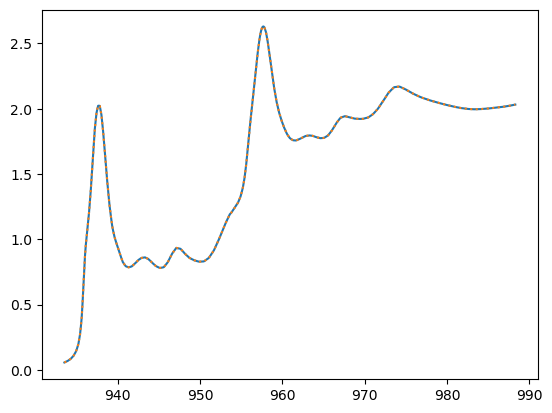

In [32]:
plt.plot(stable_cu_df.iloc[100]['Energies'], stable_cu_df.iloc[100]['Spectrum'])
plt.plot(test_stable.iloc[100]['Energies'], test_stable.iloc[100]['Spectrum'], linestyle = ':')

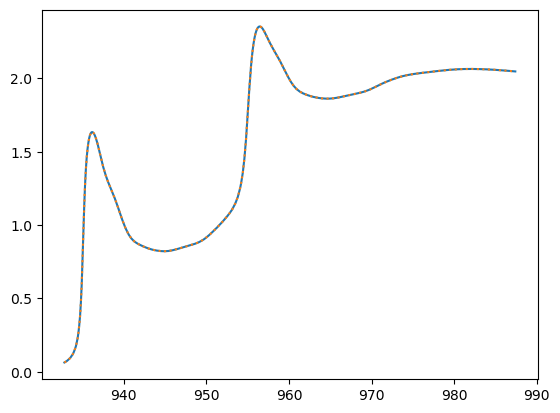

In [37]:
plt.plot(experimental_cu_df.iloc[10]['Energies'], experimental_cu_df.iloc[10]['Spectrum'])
plt.plot(test_exp.iloc[10]['Energies'], test_exp.iloc[10]['Spectrum'], linestyle = ':')

In [38]:
new_df = pd.concat([experimental_cu_df, stable_cu_df])

In [40]:
full_df_with_spectra_material_updated = full_df_with_spectra_material_updated.rename(columns={'materials_id': 'mp_id'}) 

In [41]:
new_df_list = []
for i in range(0, len(full_df_with_spectra_material_updated)):
    row = full_df_with_spectra_material_updated.iloc[i]
    new_df_list.append([row['mp_id'], row['Scaled Energy (eV)'], row['Scaled Intensities'],
                      row['structure'], row['pretty formula'], row['Fermi_Energy'], None, row['Fermi_avg'], None, 
                       row['Absorbing Index'], None, row['BV Sum no rounding'], None, row['BV Sum Scale 0.975'], None, 
                      row['BV Sum Scale 0.95'], [row['BV Get Valence']]])

In [42]:
full_df_stable_exp_TO_JOIN = pd.DataFrame(new_df_list, columns = new_df.columns)

In [43]:
final_df = pd.concat([new_df, full_df_stable_exp_TO_JOIN])

In [44]:
final_df.reset_index(inplace = True)

In [45]:
final_df

,index,mp_id,Energies,Spectrum,Structure,pretty_formula,L3_Fermis,L2_Fermis,L3_avg_Fermi,L2_avg_Fermi,Absorbing_indicies,bv_sum,avg_bv_sum,bv_sum_0.975,avg_bv_sum_0.975,bv_sum_0.95,avg_bv_sum_0.95,Integer_BV
0,0,mp-10092,"[933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933...","[0.04649283458275886, 0.04829645531248924, 0.0...","[[2.0039155 2.0039155 4.933876 ] K, [2.0039155...",KCu4Se3,[935.253],[955.221],935.253,955.221,[1],[0.9148190945142454],0.914819,[1.1178325266497817],1.117833,[1.3659339148578513],1.365934,[1]
1,1,mp-1018685,"[933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...","[0.056876610683152605, 0.0595111463612618, 0.0...","[[ 0. 0. -3.629002] Er, [0. 0. 0....",ErCuSn,[936.068],[956.037],936.068,956.037,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
2,2,mp-1018723,"[936.8, 936.9, 937.0, 937.1, 937.2, 937.3, 937...","[0.08242481734137702, 0.08690201565992121, 0.0...","[[0. 0. 0.] Ho, [-2.440826 0. -2.0339...",HoCo3Cu2,[939.079],[959.047],939.079,959.047,[4],[0],0.0,[0],0.0,[0],0.0,get valences failed
3,3,mp-1018724,"[933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...","[0.05905130722742862, 0.061863812668146785, 0....","[[ 0. 0. -3.6503785] Ho, [0. 0....",HoCuSn,[936.107],[956.075],936.107,956.075,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
4,4,mp-1018741,"[933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...","[0.06627432876379193, 0.06958478139169977, 0.0...","[[0. 0. 4.0634445] La, [0. 0. 0....",LaCuPb,[936.178],[956.146],936.178,956.146,[2],[0],0.0,[0],0.0,[0],0.0,get valences failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,1528,mp-554097,"[924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...","[0.0, 1.091595222533806e-10, 3.034799821635035...","[[-0.53962793 3.11652222 4.31700832] Sm, [2....",Sm3CuSiS7,[935.726],None,935.726,None,6,None,0.927123,None,1.111938,None,1.333595,[1]
3704,1529,mp-569764,"[924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...","[0.0, 1.1532060619855456e-10, 3.24990569902943...","[[1.35008175 5.78164817 2.58743721] Rb, [ 1.35...",RbCu2I3,[935.026],None,935.026,None,4,None,0.848726,None,1.052113,None,1.304264,[1]
3705,1530,mp-560601,"[924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...","[0.0, 1.1927709884694547e-10, 3.39019127677229...","[[ 1.554829 2.98389227 14.98347538] K, [1.5...",K2CuS(ClO2)2,[934.996],None,934.996,None,8,None,0.579358,None,0.688533,None,0.818325,[2]
3706,1531,mp-6090,"[924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...","[0.0, 1.2710747673178537e-10, 3.67270359225144...","[[-1.24237856 4.95259874 5.9645451 ] C, [2.9...",Na2Cu(CO3)2,[935.006],None,935.006,None,20,None,0.798887,None,0.93623,None,1.097185,[2]


In [46]:
full_ox_states = []
avg_bv_int = []
potential_error = []
print(len(final_df))
for k in range(0, len(final_df)):
    print(k)
    row = final_df.iloc[k]    
    if row['mp_id'] != 'Failed':
        with MPRester("CEvsr9tiYxi6MaxfRnSU7V9FCaIAcAZh") as mpr:
            docs = mpr.oxidation_states.get_data_by_id(row['mp_id'])
            # get_inequivalent_site_info(docs[0].structure)
        try: 
        # print(docs.average_oxidation_states)
            val = docs.average_oxidation_states[materials_containing]
            avg_bv_int.append(round(val, 2))
            full_ox_states.append(docs.average_oxidation_states)

            print(val, row.Integer_BV, row.mp_id)

            if row.Integer_BV != [] and type(row.Integer_BV) != str and row.Integer_BV[len(row.Integer_BV)-1] != 'get valences failed':
                # print(row.Integer_BV)
                print(np.mean(row.Integer_BV), val)
                if round(np.abs(np.mean(row.Integer_BV) - val), 2) > 0.01:
                    # raise ValueError
                    potential_error.append(True)
                else:
                    potential_error.append(False)
            else:
                potential_error.append(False)
        except KeyError:
            print(row.Integer_BV, row.mp_id)
            avg_bv_int.append(None)
            potential_error.append(False)
            full_ox_states.append(docs.average_oxidation_states)
    else:
        avg_bv_int.append('Failed')
        potential_error.append('Failed')
        full_ox_states.append('Failed')

3708
0


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10092
1.0 1.0
1


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018685
2


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018723
3


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018724
4


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018741
5


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018798
6


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018900
7


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1019275
8


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10335
2.0 2.0
9


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1034
10


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1] mp-10428
1.0 1.0
11


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1067210
12


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1068
2.0 2.0
13


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1069723
1.0 1.0
14


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071618
15


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071623
16


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071839
17


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071877
18


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072011
19


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072398
20


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072653
21


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072756
22


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072823
23


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072824
24


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072944
25


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077001
26


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077023
27


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077108
28


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077175
29


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1077262
30


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077341
31


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077348
32


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077372
33


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077377
34


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077463
35


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077744
36


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-1078387
1.5 1.6666666666666667
37


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1078420
2.0 2.0
38


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078469
1.0 1.0
39


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078587
40


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078672
41


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078706
1.0 1.0
42


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1078909
2.0 2.0
43


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079017
44


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079070
2.0 2.0
45


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079193
46


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079204
47


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079351
2.0 2.0
48


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079383
49


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1079457
50


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079468
2.0 2.0
51


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1079602
52


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1079782
53


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079797
54


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080022
55


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080057
56


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080074
57


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080173
58


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080650
1.0 1.0
59


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080696
60


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080708
1.0 1.0
61


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080722
62


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080743
63


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080828
2.0 2.0
64


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1084809
65


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1084813
66


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1087471
1.0 1.0
67


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10886
68


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1091416
1.0 1.0
69


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1092251
70


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095027
71


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1095106
72


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095168
73


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095504
74


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095537
75


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1095679
2.0 2.0
76


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10966
2.0 2.0
77


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1101077
78


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1101786
79


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-1101883
3.0 3.0
80


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1101915
2.0 2.0
81


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1102046
82


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1102243
83


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1102345
2.0 2.0
84


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1102607
2.0 2.0
85


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1103053
86


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103118
1.0 1.0
87


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103166
88


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1103249
89


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103291
1.0 1.0
90


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103352
91


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1103426
92


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103457
1.0 1.0
93


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 [3, 2] mp-1103484
2.5 2.6666666666666665
94


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103519
1.0 1.0
95


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103557
2.0 2.0
96


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103650
1.0 1.0
97


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103698
98


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103827
2.0 2.0
99


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103905
100


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103973
2.0 2.0
101


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104057
2.0 2.0
102


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104173
2.0 2.0
103


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104198
2.0 2.0
104


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1104343
3.0 3.0
105


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104488
106


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104535
107


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104542
2.0 2.0
108


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1104732
109


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1] mp-1104755
1.5 1.5
110


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1104843
1.0 1.0
111


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104990
2.0 2.0
112


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105109
2.0 2.0
113


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-1105161
114


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1105163
115


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105220
2.0 2.0
116


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105229
1.0 1.0
117


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105256
1.0 1.0
118


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105298
1.0 1.0
119


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1105463
2.0 2.0
120


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105650
2.0 2.0
121


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1105690
3.0 3.0
122


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105845
1.0 1.0
123


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1106150
3.0 3.0
124


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1106173
2.0 2.0
125


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-11638
126


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11760
127


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11771
2.0 2.0
128


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1178771
1.0 1.0
129


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11791
1.0 1.0
130


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1180676
2.0 2.0
131


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1181578
1.0 1.0
132


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1181628
1.0 1.0
133


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1181656
2.0 2.0
134


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1181705
135


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1181730
3.0 3.0
136


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181826
2.0 2.0
137


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1182273
2.0 2.0
138


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1182304
2.0 2.0
139


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1182677
2.0 2.0
140


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1182885
141


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11833
1.0 1.0
142


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1188097
3.0 3.0
143


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11882
144


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1188223
2.0 2.0
145


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1188402
2.0 2.0
146


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188558
1.0 1.0
147


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188561
148


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188578
149


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188600
150


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1188611
3.0 3.0
151


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-1188802
2.0 2.0
152


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1188871
2.0 2.0
153


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189056
1.0 1.0
154


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189076
1.0 1.0
155


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1189224
3.0 3.0
156


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1189352
2.0 2.0
157


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1189362
158


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1189416
2.0 2.0
159


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189555
160


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189666
161


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189755
162


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189765
163


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1189973
3.0 3.0
164


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1190022
165


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190137
1.0 1.0
166


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190173
2.0 2.0
167


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1190198
168


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1190264
169


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190393
2.0 2.0
170


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190440
2.0 2.0
171


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190474
2.0 2.0
172


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1190573
173


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190630
1.0 1.0
174


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 [3, 2] mp-1190666
2.5 2.6666666666666665
175


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190783
2.0 2.0
176


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1190785
1.0 1.0
177


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1190990
2.0 2.0
178


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191076
1.0 1.0
179


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1191086
1.0 1.0
180


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1191092
1.0 1.0
181


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191148
2.0 2.0
182


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1191238
1.0 1.0
183


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1191323
2.0 2.0
184


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1191350
1.0 1.0
185


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1191383
1.0 1.0
186


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191497
2.0 2.0
187


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1191505
2.0 2.0
188


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1191650
2.0 2.0
189


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1191679
2.0 2.0
190


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191912
2.0 2.0
191


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1191913
1.0 1.0
192


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1192124
193


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1192205
1.0 1.0
194


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1192264
195


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1192275
1.0 1.0
196


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1192282
197


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192353
1.0 1.0
198


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1192355
1.0 1.0
199


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192472
2.0 2.0
200


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-1192531
1.0 1.0
201


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.8 [2, 3, 3, 3] mp-1192555
2.75 2.8
202


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192625
203


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192713
1.0 1.0
204


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1192779
2.0 2.0
205


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192806
2.0 2.0
206


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1192807
2.0 2.0
207


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1192830
2.0 2.0
208


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192934
209


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192989
210


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193079
211


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1193103
3.0 3.0
212


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193217
213


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [3, 2] mp-1193249
2.5 2.3333333333333335
214


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1193268
2.0 2.0
215


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1193339
3.0 3.0
216


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193439
2.0 2.0
217


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 [2, 3] mp-1193512
2.5 2.6666666666666665
218


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1193540
2.0 2.0
219


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1193551
2.0 2.0
220


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193617
2.0 2.0
221


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193632
222


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1193701
1.0 1.0
223


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1193718
1.0 1.0
224


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193752
2.0 2.0
225


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1193873
226


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193941
2.0 2.0
227


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194041
228


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1194267
2.0 2.0
229


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194283
2.0 2.0
230


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-1194436
1.0 1.0
231


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1194694
232


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194708
233


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-1194779
234


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1194948
2.0 2.0
235


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194983
2.0 2.0
236


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-1195036
1.0 1.0
237


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195153
2.0 2.0
238


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195165
2.0 2.0
239


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-1195238
3.0 3.0
240


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195300
2.0 2.0
241


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195498
2.0 2.0
242


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1195501
3.0 3.0
243


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195739
2.0 2.0
244


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1195928
1.0 1.0
245


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1196031
2.0 2.0
246


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1196039
2.0 2.0
247


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1196064
3.0 3.0
248


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1196110
3.0 3.0
249


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1196135
2.0 2.0
250


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-1196166
251


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-1196185
2.0 2.0
252


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1196187
2.0 2.0
253


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1196314
254


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.4 [2, 2, 3, 2, 3] mp-1196322
2.4 2.4
255


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [2, 3] mp-1196376
2.5 2.5
256


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1196587
257


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196599
2.0 2.0
258


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1196682
259


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1196726
1.0 1.0
260


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196871
2.0 2.0
261


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1196993
1.0 1.0
262


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1197183
2.0 2.0
263


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197302
2.0 2.0
264


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197502
1.0 1.0
265


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197546
2.0 2.0
266


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-1197678
2.0 2.0
267


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197738
1.0 1.0
268


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1197753
269


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1197779
2.0 2.0
270


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1197841
271


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197914
1.0 1.0
272


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197943
2.0 2.0
273


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [3, 2] mp-1198006
2.5 2.5
274


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198047
2.0 2.0
275


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1198174
3.0 3.0
276


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1198264
277


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1198265
278


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198405
2.0 2.0
279


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198524
2.0 2.0
280


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198701
2.0 2.0
281


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1198752
3.0 3.0
282


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198809
2.0 2.0
283


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1198821
284


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1198838
285


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1198851
286


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198901
2.0 2.0
287


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199050
2.0 2.0
288


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1199099
2.0 2.0
289


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1199109
3.0 3.0
290


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-1199182
1.0 1.0
291


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1199298
292


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1199313
2.0 2.0
293


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1199396
1.0 1.0
294


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1199461
3.0 3.0
295


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1199484
2.0 2.0
296


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1199734
297


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199822
2.0 2.0
298


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1199882
2.0 2.0
299


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1199930
300


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199970
2.0 2.0
301


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1199983
2.0 2.0
302


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1200069
2.0 2.0
303


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200133
2.0 2.0
304


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2, 2, 2] mp-1200177
2.0 2.0
305


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200215
2.0 2.0
306


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1200279
307


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200315
2.0 2.0
308


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200529
2.0 2.0
309


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1200663
310


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200668
2.0 2.0
311


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1200769
312


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-1200772
1.5 1.6666666666666667
313


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1200812
1.0 1.0
314


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200865
2.0 2.0
315


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1201135
316


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1201149
2.0 2.0
317


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1201234
318


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1201240
3.0 3.0
319


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1201317
2.0 2.0
320


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] mp-1201389
1.0 1.0
321


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1201390
322


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1201409
1.0 1.0
323


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1201607
1.0 1.0
324


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1201655
2.0 2.0
325


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1201664
2.0 2.0
326


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201761
2.0 2.0
327


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1201766
328


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1201854
329


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1202064
2.0 2.0
330


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202099
2.0 2.0
331


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1202152
2.0 2.0
332


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [2, 1, 1, 1] mp-1202250
1.25 1.25
333


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1202347
334


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1202466
335


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202524
2.0 2.0
336


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202570
2.0 2.0
337


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.2 [3, 2, 2, 2, 2] mp-1202588
2.2 2.2
338


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1202646
1.0 1.0
339


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1202851
2.0 2.0
340


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203110
2.0 2.0
341


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203192
2.0 2.0
342


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1203611
2.0 2.0
343


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203696
2.0 2.0
344


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1203697
345


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1203708
1.0 1.0
346


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203872
2.0 2.0
347


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203931
2.0 2.0
348


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-1203941
2.0 2.0
349


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1204058
2.0 2.0
350


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [3, 2] mp-1204064
2.5 2.3333333333333335
351


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1204344
352


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1204374
353


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204438
2.0 2.0
354


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1204474
1.0 1.0
355


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-1204573
1.5 1.6666666666666667
356


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2] mp-1204584
2.0 2.0
357


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1204591
2.0 2.0
358


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1204686
3.0 3.0
359


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1204931
360


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2777777777777777 [2, 2, 1, 1, 2, 1, 1, 1] mp-1205239
1.375 1.2777777777777777
361


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1205250
2.0 2.0
362


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1205359
2.0 2.0
363


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1205438
2.0 2.0
364


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12087
1.0 1.0
365


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12118
366


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12145
2.0 2.0
367


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12161
2.0 2.0
368


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12185
2.0 2.0
369


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12268
2.0 2.0
370


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1232413
2.0 2.0
371


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1233
372


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1238498
2.0 2.0
373


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1239022
2.0 2.0
374


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1239037
375


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12457
1.0 1.0
376


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12546
377


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12586
378


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12777
379


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12794
380


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12801
381


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12854
2.0 2.0
382


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13020
383


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13045
384


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-13089
2.0 2.0
385


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13138
386


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13287
1.0 1.0
387


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13480
1.0 1.0
388


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13486
389


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13589
1.0 1.0
390


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14089
1.0 1.0
391


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-14735
2.0 2.0
392


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-14824
1.5 1.6666666666666667
393


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14862
2.0 2.0
394


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1] mp-15252
1.5 1.5
395


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-15335
2.0 2.0
396


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-15336
2.0 2.0
397


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15481
2.0 2.0
398


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-15895
1.0 1.0
399


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15900
1.0 1.0
400


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16056
2.0 2.0
401


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16115
2.0 2.0
402


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16179
1.0 1.0
403


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16320
1.0 1.0
404


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16366
1.0 1.0
405


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-16435
2.0 2.0
406


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16494
407


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16496
408


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16565
2.0 2.0
409


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-16775
410


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17119
2.0 2.0
411


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17145
2.0 2.0
412


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17194
1.0 1.0
413


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17262
2.0 2.0
414


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17268
2.0 2.0
415


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-17336
416


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-17388
417


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17598
2.0 2.0
418


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17687
2.0 2.0
419


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-17691
1.0 1.0
420


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17699
2.0 2.0
421


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17738
2.0 2.0
422


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-17801
423


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17878
2.0 2.0
424


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17916
1.0 1.0
425


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18124
2.0 2.0
426


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18126
1.0 1.0
427


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-18279
428


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18444
2.0 2.0
429


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18490
2.0 2.0
430


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-18540
1.0 1.0
431


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18576
2.0 2.0
432


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1861
1.0 1.0
433


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-18637
2.0 2.0
434


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [2, 3] mp-18713
2.5 2.3333333333333335
435


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1945
436


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1966
1.0 1.0
437


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19735
2.0 2.0
438


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-19834
439


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-19946
440


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-19968
441


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-19983
442


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-2002
1.0 1.0
443


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20083
1.0 1.0
444


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20087
2.0 2.0
445


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20140
2.0 2.0
446


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20203
1.0 1.0
447


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20212
2.0 2.0
448


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20307
449


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-20324
2.0 2.0
450


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20370
1.0 1.0
451


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-20437
1.5 1.6666666666666667
452


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20476
2.0 2.0
453


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20491
454


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20977
2.0 2.0
455


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20982
2.0 2.0
456


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-2103
457


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21141
1.0 1.0
458


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21148
459


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21360
460


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21376
2.0 2.0
461


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21388
462


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-21458
463


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21475
464


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21500
465


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21560
2.0 2.0
466


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21568
2.0 2.0
467


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-21617
2.0 2.0
468


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2105263157894737 [1, 1, 1, 2, 2] mp-21684
1.4 1.2105263157894737
469


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-21708
470


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1] mp-21827
1.5 1.5
471


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21861
2.0 2.0
472


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21865
473


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-21868
1.5 1.6666666666666667
474


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-21964
1.0 1.0
475


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22037
2.0 2.0
476


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2210
477


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22196
2.0 2.0
478


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-22215
1.5 1.6666666666666667
479


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22221
480


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22237
481


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22271
2.0 2.0
482


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-22297
1.0 1.0
483


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-22301
1.5 1.6666666666666667
484


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22305
1.0 1.0
485


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22392
1.0 1.0
486


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22407
2.0 2.0
487


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22414
2.0 2.0
488


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22550
2.0 2.0
489


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-22601
2.0 2.0
490


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22611
1.0 1.0
491


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22673
492


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22680
493


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22685
494


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-22719
2.0 2.0
495


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22761
496


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22810
497


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22863
1.0 1.0
498


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22914
1.0 1.0
499


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22917
1.0 1.0
500


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22941
1.0 1.0
501


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22960
1.0 1.0
502


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23095
2.0 2.0
503


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-23133
2.0 2.0
504


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23212
1.0 1.0
505


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23227
1.0 1.0
506


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2323
507


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23508
2.0 2.0
508


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-23733
2.0 2.0
509


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23795
2.0 2.0
510


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23857
2.0 2.0
511


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24038
2.0 2.0
512


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-24093
1.0 1.0
513


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24103
2.0 2.0
514


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24164
2.0 2.0
515


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24197
2.0 2.0
516


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24228
2.0 2.0
517


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24559
2.0 2.0
518


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1] mp-27124
1.5 1.5
519


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27249
2.0 2.0
520


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27548
2.0 2.0
521


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2] mp-27550
2.0 2.0
522


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-27589
2.0 2.0
523


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27719
2.0 2.0
524


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-28317
1.0 1.0
525


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28491
1.0 1.0
526


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0714285714285714 [] mp-28656
527


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-28743
2.0 2.0
528


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-2882
2.0 2.0
529


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-2918
1.0 1.0
530


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-29225
1.0 1.0
531


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-29450
532


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-29476
1.0 1.0
533


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-29507
2.0 2.0
534


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29643
1.0 1.0
535


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-2977
2.0 2.0
536


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [1, 1, 1, 2, 1, 1, 1] mp-29823
1.1428571428571428 1.1428571428571428
537


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29828
2.0 2.0
538


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-30449
1.0 1.0
539


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30450
540


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-30451
1.0 1.0
541


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30471
542


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30504
543


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30578
544


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30582
545


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30583
546


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30589
547


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30590
548


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30593
549


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30594
550


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-30597
551


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-30599
552


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30603
553


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30696
554


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30698
555


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30699
556


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-31145
1.0 1.0
557


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-3120
2.0 2.0
558


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-31510
1.0 1.0
559


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3179
1.0 1.0
560


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3255
2.0 2.0
561


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3421
2.0 2.0
562


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-34765
1.0 1.0
563


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-3648
564


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-36480
2.0 2.0
565


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3682
2.0 2.0
566


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-3702
567


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-3736
568


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4158
2.0 2.0
569


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4210
2.0 2.0
570


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4320
2.0 2.0
571


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4367
572


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-4473
1.0 1.0
573


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-4541
3.0 3.0
574


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4552
575


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4643
2.0 2.0
576


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.125 [] mp-4647
577


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4711
2.0 2.0
578


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4826
2.0 2.0
579


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2, 1] mp-488
1.5 1.3333333333333333
580


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-504
2.0 2.0
581


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1, 2, 1] mp-504536
1.3333333333333333 1.5
582


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504580
2.0 2.0
583


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504711
2.0 2.0
584


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504862
2.0 2.0
585


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504927
2.0 2.0
586


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504978
2.0 2.0
587


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505105
2.0 2.0
588


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505131
2.0 2.0
589


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505151
2.0 2.0
590


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505194
1.0 1.0
591


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-505215
592


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505268
2.0 2.0
593


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505310
1.0 1.0
594


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-505404
2.0 2.0
595


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505421
2.0 2.0
596


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-505576
597


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505589
2.0 2.0
598


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505611
1.0 1.0
599


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-505785
600


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505804
1.0 1.0
601


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505811
2.0 2.0
602


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510056
2.0 2.0
603


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-510148
604


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510292
2.0 2.0
605


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510539
1.0 1.0
606


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510570
2.0 2.0
607


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510608
2.0 2.0
608


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510642
2.0 2.0
609


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-510657
1.5 1.6666666666666667
610


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-5169
2.0 2.0
611


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5178
2.0 2.0
612


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [1, 1, 2] mp-540665
1.3333333333333333 1.1428571428571428
613


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-540724
1.0 1.0
614


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-540812
2.0 2.0
615


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-540858
2.0 2.0
616


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-540999
617


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541087
2.0 2.0
618


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541136
2.0 2.0
619


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-541147
2.0 2.0
620


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541324
2.0 2.0
621


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541330
2.0 2.0
622


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541332
2.0 2.0
623


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-541622
1.0 1.0
624


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-541923
1.0 1.0
625


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-541991
2.0 2.0
626


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-542176
627


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-542197
2.0 2.0
628


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542426
1.0 1.0
629


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5425
1.0 1.0
630


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-542750
631


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542806
1.0 1.0
632


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542807
2.0 2.0
633


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-542934
634


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542944
2.0 2.0
635


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-545369
1.0 1.0
636


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-546449
2.0 2.0
637


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-546790
1.0 1.0
638


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-551135
2.0 2.0
639


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-551219
1.0 1.0
640


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-552089
2.0 2.0
641


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-553974
2.0 2.0
642


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554075
2.0 2.0
643


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554117
2.0 2.0
644


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554120
1.0 1.0
645


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-554177
2.0 2.0
646


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554184
2.0 2.0
647


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 2, 1, 1] mp-554200
1.5 1.6666666666666667
648


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-554272
1.0 1.0
649


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554298
2.0 2.0
650


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554335
2.0 2.0
651


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554343
1.0 1.0
652


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554352
2.0 2.0
653


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-554419
2.0 2.0
654


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-554440
2.0 2.0
655


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.4285714285714286 [1, 2, 1] mp-554511
1.3333333333333333 1.4285714285714286
656


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2, 2, 2, 2] mp-554562
2.0 2.0
657


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1] mp-5546
1.0 1.0
658


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1666666666666667 [1, 1, 2, 1, 1, 1] mp-554627
1.1666666666666667 1.1666666666666667
659


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554781
1.0 1.0
660


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554812
2.0 2.0
661


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-554874
2.0 2.0
662


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555093
2.0 2.0
663


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-555139
2.0 2.0
664


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555369
2.0 2.0
665


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555515
2.0 2.0
666


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555519
2.0 2.0
667


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555570
2.0 2.0
668


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-555729
669


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555827
2.0 2.0
670


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1, 2] mp-555856
1.5 1.3333333333333333
671


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-555937
2.0 2.0
672


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555984
1.0 1.0
673


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556002
2.0 2.0
674


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556036
2.0 2.0
675


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556045
2.0 2.0
676


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556238
2.0 2.0
677


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556402
2.0 2.0
678


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556575
2.0 2.0
679


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556582
2.0 2.0
680


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556590
2.0 2.0
681


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556604
2.0 2.0
682


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556635
2.0 2.0
683


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556640
1.0 1.0
684


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-556714
1.0 1.0
685


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556733
2.0 2.0
686


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-556753
2.0 2.0
687


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556755
2.0 2.0
688


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556822
2.0 2.0
689


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556926
2.0 2.0
690


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-557055
3.0 3.0
691


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557084
2.0 2.0
692


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557123
2.0 2.0
693


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-557136
2.0 2.0
694


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2, 1] mp-557249
1.5 1.3333333333333333
695


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-557274
1.0 1.0
696


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557339
2.0 2.0
697


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557341
2.0 2.0
698


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557373
1.0 1.0
699


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557510
2.0 2.0
700


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557552
2.0 2.0
701


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557801
2.0 2.0
702


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1666666666666667 [] mp-557929
703


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-557936
2.0 2.0
704


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557980
2.0 2.0
705


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-558144
2.0 2.0
706


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-558156
2.0 2.0
707


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558338
1.0 1.0
708


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558364
2.0 2.0
709


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558472
2.0 2.0
710


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-558486
2.0 2.0
711


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558696
2.0 2.0
712


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-559094
2.0 2.0
713


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-559209
2.0 2.0
714


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-559307
1.0 1.0
715


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559415
2.0 2.0
716


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-560100
2.0 2.0
717


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560165
2.0 2.0
718


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560273
2.0 2.0
719


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-560285
2.0 2.0
720


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-560291
2.0 2.0
721


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560345
2.0 2.0
722


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-560368
2.0 2.0
723


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560533
2.0 2.0
724


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-560776
2.0 2.0
725


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560805
2.0 2.0
726


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-561012
2.0 2.0
727


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-561081
728


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-561308
2.0 2.0
729


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-561515
3.0 3.0
730


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-562090
1.0 1.0
731


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-565843
2.0 2.0
732


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1, 2] mp-566937
1.5 1.5
733


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-567201
734


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-567366
2.0 2.0
735


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567840
1.0 1.0
736


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-567932
737


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-568224
2.0 2.0
738


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-568315
739


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-568354
740


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-568495
741


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-568497
742


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-568524
743


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-568532
2.0 2.0
744


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568587
1.0 1.0
745


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568598
1.0 1.0
746


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-568816
2.0 2.0
747


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569292
1.0 1.0
748


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-569339
749


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-569526
2.0 2.0
750


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5696
2.0 2.0
751


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569687
1.0 1.0
752


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-569691
753


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569715
1.0 1.0
754


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-569834
755


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1] mp-570393
1.0 1.0
756


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-570702
757


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-570765
758


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-571034
759


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-571054
1.0 1.0
760


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-571074
761


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-571268
1.5 1.6666666666666667
762


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571386
1.0 1.0
763


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571468
1.0 1.0
764


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572929
2.0 2.0
765


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-573024
2.0 2.0
766


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-573069
2.0 2.0
767


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-573877
768


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-574507
769


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-579718
770


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-580364
771


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] mp-581212
1.0 1.0
772


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-581303
2.0 2.0
773


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-581641
2.0 2.0
774


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-581786
775


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-582681
776


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-583800
777


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5866
1.0 1.0
778


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5938
2.0 2.0
779


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-600172
780


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-600604
2.0 2.0
781


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-6013
1.0 1.0
782


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-601952
2.0 2.0
783


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-603257
2.0 2.0
784


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6036
2.0 2.0
785


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-604273
2.0 2.0
786


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-604996
2.0 2.0
787


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-605172
788


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-605196
1.0 1.0
789


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-605485
2.0 2.0
790


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-607080
791


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6127
2.0 2.0
792


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-614489
793


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-614964
1.5 1.6666666666666667
794


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-616166
1.5 1.6666666666666667
795


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-616610
1.0 1.0
796


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-617247
2.0 2.0
797


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-6181
1.0 1.0
798


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] mp-618788
1.0 1.0
799


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-618991
1.0 1.0
800


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-620033
2.0 2.0
801


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-620325
2.0 2.0
802


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1, 1, 1] mp-622026
1.0 1.0
803


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-622108
2.0 2.0
804


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-622110
2.0 2.0
805


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-622570
806


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-622576
1.5 1.6666666666666667
807


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-622636
808


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6252
2.0 2.0
809


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-628568
2.0 2.0
810


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6297
2.0 2.0
811


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-635456
1.0 1.0
812


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-635469
1.0 1.0
813


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-636198
814


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-636240
815


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-636256
816


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-636978
2.0 2.0
817


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-638086
1.0 1.0
818


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-639675
819


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-639719
2.0 2.0
820


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-639756
821


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-640899
822


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-640925
2.0 2.0
823


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-641065
3.0 3.0
824


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2, 2] mp-641710
2.0 2.0
825


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-642
826


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-642157
2.0 2.0
827


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-642804
2.0 2.0
828


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-642811
829


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-643052
830


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.8333333333333333 [2, 1, 2, 2, 2, 2] mp-643203
1.8333333333333333 1.8333333333333333
831


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-643378
2.0 2.0
832


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-643743
2.0 2.0
833


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-643934
2.0 2.0
834


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-645435
2.0 2.0
835


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-645504
836


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-646039
837


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-646125
838


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-646750
839


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-647452
840


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-647606
1.0 1.0
841


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-649774
1.0 1.0
842


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6498
1.0 1.0
843


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-649944
2.0 2.0
844


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-650741
2.0 2.0
845


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-651682
2.0 2.0
846


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-651706
1.0 1.0
847


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.8 [1, 2, 1, 2, 2, 2, 2, 2, 2, 2] mp-652781
1.8 1.8
848


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-653631
2.0 2.0
849


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6537
2.0 2.0
850


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-653925
2.0 2.0
851


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-654109
1.0 1.0
852


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-654900
1.0 1.0
853


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-655377
1.0 1.0
854


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-669354
2.0 2.0
855


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-669361
2.0 2.0
856


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-672285
1.0 1.0
857


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [1, 1, 1, 2] mp-672295
1.25 1.25
858


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-672345
2.0 2.0
859


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1, 2, 1] mp-677105
1.5 1.5
860


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-679991
1.0 1.0
861


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6802
1.0 1.0
862


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2] mp-680211
2.0 2.0
863


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-680639
864


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-6829
865


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-683906
866


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0833333333333335 [2, 2, 2, 2, 3, 2, 2, 2, 2, 2] mp-683950
2.1 2.0833333333333335
867


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6885
2.0 2.0
868


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-690769
2.0 2.0
869


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-696200
870


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696384
2.0 2.0
871


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696956
2.0 2.0
872


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-697008
2.0 2.0
873


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-697994
2.0 2.0
874


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-698276
1.0 1.0
875


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-698313
1.0 1.0
876


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-698361
877


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-698396
1.0 1.0
878


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-698413
2.0 2.0
879


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-699474
2.0 2.0
880


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-703398
2.0 2.0
881


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-703515
2.0 2.0
882


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-703531
2.0 2.0
883


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-704617
2.0 2.0
884


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-704645
2.0 2.0
885


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-704745
886


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-705439
887


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-705524
888


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-706287
2.0 2.0
889


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-706528
2.0 2.0
890


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-706670
2.0 2.0
891


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707052
2.0 2.0
892


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-707169
893


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707170
2.0 2.0
894


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-707201
2.0 2.0
895


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-707464
896


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707484
2.0 2.0
897


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-707852
898


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-707879
2.0 2.0
899


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-709325
2.0 2.0
900


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-709886
3.0 3.0
901


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-712
902


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-720299
2.0 2.0
903


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-720337
2.0 2.0
904


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-720417
1.0 1.0
905


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-720876
2.0 2.0
906


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-721072
2.0 2.0
907


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721604
2.0 2.0
908


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721789
2.0 2.0
909


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-721943
2.0 2.0
910


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-722280
2.0 2.0
911


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-722867
2.0 2.0
912


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-723175
2.0 2.0
913


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-733590
2.0 2.0
914


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-752783
2.0 2.0
915


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-753954
2.0 2.0
916


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-756758
2.0 2.0
917


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-766274
2.0 2.0
918


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-774723
2.0 2.0
919


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-774726
920


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-7861
2.0 2.0
921


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8124
1.0 1.0
922


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-838
923


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-845
924


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-861595
925


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-862687
2.0 2.0
926


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-8800
1.0 1.0
927


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8806
1.0 1.0
928


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8927
1.0 1.0
929


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9248
1.0 1.0
930


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9660
2.0 2.0
931


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-998
932


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-999135
1.0 1.0
933


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1001780
1.0 1.0
934


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1005792
1.0 1.0
935


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1008511
936


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1017556
937


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018029
938


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018149
939


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018705
940


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018713
941


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018714
942


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1018784
1.0 1.0
943


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1018893
944


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1023132
2.0 2.0
945


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10244
1.0 1.0
946


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1024954
947


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1024957
948


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1024987
949


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1024991
950


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1024994
951


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025013
952


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025021
953


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-1025032
954


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025116
955


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025122
956


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025128
957


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025134
958


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1025136
959


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025177
2.0 2.0
960


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025265
2.0 2.0
961


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025338
2.0 2.0
962


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1025340
1.0 1.0
963


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1025402
964


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025502
2.0 2.0
965


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025532
2.0 2.0
966


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10288
1.0 1.0
967


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10336
1.0 1.0
968


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1038
969


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10381
1.0 1.0
970


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10533
1.0 1.0
971


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10598
972


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1068891
973


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1069287
974


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1069357
975


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1069375
976


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1069443
977


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1069825
978


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1070573
979


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1070869
980


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071051
981


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071645
982


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071732
983


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071835
984


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1071904
985


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072033
986


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072041
987


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1072264
988


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10746
989


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10749
1.0 1.0
990


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1076933
991


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077154
992


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077165
993


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077167
994


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077209
995


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077290
996


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077293
997


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077351
998


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077428
999


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077453
1000


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077498
1001


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077518
1002


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077741
1003


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077750
1004


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077752
1005


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1077802
1006


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1077929
2.0 2.0
1007


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [] mp-1078005
1008


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078292
1.0 1.0
1009


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078460
1010


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078489
1011


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078543
1012


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078544
1013


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078592
1014


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078630
1.0 1.0
1015


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078692
1016


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078729
1017


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078738
1018


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078853
1019


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1078857
1020


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078916
1021


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1078920
1022


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1078982
2.0 2.0
1023


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079091
1024


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079261
2.0 2.0
1025


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079357
1026


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079361
1027


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079498
1028


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079508
1029


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079779
1030


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1079868
1031


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1079890
1032


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080085
1033


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080116
2.0 2.0
1034


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080149
1.0 1.0
1035


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080384
1036


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080443
1037


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080560
1038


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080588
1.0 1.0
1039


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080594
1040


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080612
1041


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1080624
1042


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1080814
1043


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10834
1.0 1.0
1044


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1087483
1.0 1.0
1045


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1087547
1046


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10876
1047


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10877
1048


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-10887
1049


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10950
2.0 2.0
1050


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1095111
1051


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10952
1.0 1.0
1052


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095201
1053


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1095273
1.0 1.0
1054


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1095403
1.0 1.0
1055


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095575
1056


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1095591
1057


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1095660
1058


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1096867
1.0 1.0
1059


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1096897
1060


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10973
1.0 1.0
1061


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10991
2.0 2.0
1062


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10992
2.0 2.0
1063


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-1100809
1.0 1.0
1064


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 error mp-1101139
1065


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1101476
3.0 3.0
1066


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1101850
1067


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1101867
1068


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11019
1.0 1.0
1069


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1102015
1.0 1.0
1070


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1102042
1071


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1102297
1.0 1.0
1072


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1102382
3.0 3.0
1073


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 get valences failed mp-1102518
1074


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1102536
1.0 1.0
1075


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11029
1076


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103123
1.0 1.0
1077


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103415
1078


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103511
1079


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1103929
1080


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-1104000
1.5 1.6666666666666667
1081


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1104253
1082


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104269
1083


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104741
1084


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104798
1085


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104848
1086


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104923
1087


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1104954
1088


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 get valences failed mp-1104960
1089


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105138
2.0 2.0
1090


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1105186
1091


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105187
2.0 2.0
1092


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1105558
1093


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105893
1.0 1.0
1094


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105955
1.0 1.0
1095


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1106051
1.0 1.0
1096


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1106068
3.0 3.0
1097


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1106301
1098


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1106310
1.0 1.0
1099


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11086
1100


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11114
2.0 2.0
1101


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11115
2.0 2.0
1102


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1113297
1.0 1.0
1103


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1113598
1.0 1.0
1104


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [] mp-1120730
1105


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11293
1106


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11359
1107


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11360
1108


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11361
1109


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-11363
1110


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11366
1111


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1140
1112


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1147551
1113


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1147553
1114


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1147629
1115


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1147650
2.0 2.0
1116


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1147653
2.0 2.0
1117


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1147660
1118


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1147679
1.0 1.0
1119


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1147709
2.0 2.0
1120


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1147715
2.0 2.0
1121


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11604
1.0 1.0
1122


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11700
1.0 1.0
1123


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11701
1.0 1.0
1124


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1172870
1.0 1.0
1125


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1173386
3.0 3.0
1126


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1177695
1.0 1.0
1127


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11790
1.0 1.0
1128


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11792
1.0 1.0
1129


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11793
1.0 1.0
1130


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1179530
1131


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1179864
1.0 1.0
1132


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1180119
1.0 1.0
1133


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1183114
1134


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1183120
1135


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1183810
1136


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1183995
1137


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184092
1138


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184119
1139


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184202
1140


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184422
1141


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184522
1142


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184609
1143


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1184891
1144


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-11852
1145


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1185442
1146


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1185452
1147


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1185457
1148


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1185508
1149


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1185509
1150


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186451
1151


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186452
1152


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186453
1153


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186454
1154


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186462
1155


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1186667
1156


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187436
1157


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187455
1158


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187459
1159


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187538
1160


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187606
1161


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1187800
1162


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1188077
1163


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188159
1164


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188172
1165


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188208
1.0 1.0
1166


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1188264
2.0 2.0
1167


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [3, 2] mp-1188268
2.5 2.5
1168


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1188441
1169


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1188531
1170


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189550
1171


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1189588
1172


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1189612
2.0 2.0
1173


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189828
1.0 1.0
1174


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189879
1.0 1.0
1175


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1190072
1176


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190117
2.0 2.0
1177


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190199
2.0 2.0
1178


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190435
2.0 2.0
1179


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190446
2.0 2.0
1180


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190515
2.0 2.0
1181


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190539
1.0 1.0
1182


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190656
1.0 1.0
1183


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1191054
1184


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191264
1.0 1.0
1185


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1191305
1186


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191406
1.0 1.0
1187


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191419
1.0 1.0
1188


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191858
2.0 2.0
1189


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191985
1.0 1.0
1190


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1192085
1.0 1.0
1191


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11923
1.0 1.0
1192


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-11925
1.0 1.0
1193


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192662
1194


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192715
1195


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192723
2.0 2.0
1196


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192782
2.0 2.0
1197


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1192935
1198


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1192952
1199


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193200
1200


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193533
1201


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193693
1202


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1193845
1203


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194036
1204


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194170
1205


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194230
1206


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194241
1207


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1194443
1208


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1194546
2.0 2.0
1209


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.15 [] mp-1194744
1210


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-1194809
1.0 1.0
1211


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195070
2.0 2.0
1212


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195143
2.0 2.0
1213


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1195291
1.0 1.0
1214


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195655
2.0 2.0
1215


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195676
2.0 2.0
1216


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1195710
1217


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1195821
1218


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1196390
1219


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-1197298
1220


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1197621
1221


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.625 [] mp-1197658
1222


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-1197719
1223


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198036
2.0 2.0
1224


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [] mp-1198048
1225


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198565
2.0 2.0
1226


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1198918
2.0 2.0
1227


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [] mp-1199244
1228


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1199290
1.0 1.0
1229


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1199735
1.0 1.0
1230


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12007
1231


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12009
1232


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1200988
1233


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1201069
1.0 1.0
1234


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1201167
2.0 2.0
1235


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201654
2.0 2.0
1236


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1203135
3.0 3.0
1237


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1203307
1.0 1.0
1238


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203834
2.0 2.0
1239


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1203883
1240


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205497
1241


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205563
1242


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205577
1243


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205581
1244


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205707
1245


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205745
1246


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205861
1247


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205864
1248


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205902
1249


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205970
1250


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1205987
1251


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1206020
1.0 1.0
1252


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206022
1253


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 error mp-1206085
1254


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206095
1255


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-1206169
1256


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1206176
3.0 3.0
1257


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206262
1258


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206278
1259


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206421
1260


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1206427
3.0 3.0
1261


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206430
1262


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206438
1263


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206453
1264


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206454
1265


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1206535
3.0 3.0
1266


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206555
1267


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206691
1268


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206800
1269


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1206870
2.0 2.0
1270


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1206905
1271


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1206944
1272


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1207003
1273


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1207068
2.0 2.0
1274


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1207193
2.0 2.0
1275


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1207213
3.0 3.0
1276


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1207399
1.0 1.0
1277


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1207410
1.0 1.0
1278


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1207422
1279


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1207590
1280


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1207620
1281


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1207636
1282


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1207797
1283


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1208066
1284


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1208222
1.0 1.0
1285


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208239
1286


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208242
1287


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208292
1288


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208323
1289


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1208325
2.0 2.0
1290


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208445
1291


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1208521
1292


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12086
1293


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1208916
2.0 2.0
1294


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1209000
1295


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1209018
1.0 1.0
1296


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209206
2.0 2.0
1297


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209376
2.0 2.0
1298


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209738
2.0 2.0
1299


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1209760
2.0 2.0
1300


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1209796
1301


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209832
2.0 2.0
1302


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209940
2.0 2.0
1303


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209951
2.0 2.0
1304


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1209963
2.0 2.0
1305


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1210067
1306


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1210068
2.0 2.0
1307


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1210079
2.0 2.0
1308


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-1210159
1.0 1.0
1309


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1210224
2.0 2.0
1310


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1210463
3.0 3.0
1311


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1, 2] mp-1210695
1.5 1.5
1312


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1211261
2.0 2.0
1313


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1211368
2.0 2.0
1314


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1211416
2.0 2.0
1315


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1211431
1316


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1211434
2.0 2.0
1317


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1211474
1.0 1.0
1318


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1211692
1.0 1.0
1319


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-1211723
1.0 1.0
1320


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1212343
1321


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1212455
1322


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1212597
1323


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1212638
2.0 2.0
1324


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1212660
1.0 1.0
1325


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1212752
1.0 1.0
1326


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1212837
1.0 1.0
1327


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1212937
1.0 1.0
1328


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213055
2.0 2.0
1329


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 error mp-1213075
1330


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213198
2.0 2.0
1331


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213222
2.0 2.0
1332


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213273
2.0 2.0
1333


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1213285
1334


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1213290
1335


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1213317
2.0 2.0
1336


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213368
2.0 2.0
1337


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1213613
1.0 1.0
1338


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1213889
2.0 2.0
1339


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-1214035
1.0 1.0
1340


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1214036
1341


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1214241
1342


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1214324
2.0 2.0
1343


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1214381
1.0 1.0
1344


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1214402
1.0 1.0
1345


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1214501
1346


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1214524
1347


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 get valences failed mp-1214552
1348


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1214577
2.0 2.0
1349


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-1214585
1.5 1.6666666666666667
1350


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1214695
2.0 2.0
1351


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1214697
1352


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1214709
2.0 2.0
1353


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1214720
2.0 2.0
1354


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1214730
2.0 2.0
1355


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1214866
1356


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1214887
1357


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1214933
1358


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1215318
1359


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215338
1360


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1215370
1361


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215380
1362


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1215494
1.0 1.0
1363


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 get valences failed mp-1215495
1364


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1215514
1.0 1.0
1365


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215553
1366


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1215563
1367


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215637
1368


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1215639
1369


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215672
1370


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1215705
1.0 1.0
1371


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1215719
1372


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1215808
1373


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 get valences failed mp-1215887
1374


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1215905
1.0 1.0
1375


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216017
1376


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216020
1377


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1216081
1378


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216128
1379


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216156
1380


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1216184
1.0 1.0
1381


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216210
1382


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216319
1383


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1, 2] mp-1216363
1.5 1.3333333333333333
1384


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216441
1385


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.4615384615384615 [2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2] mp-1216515
1.4615384615384615 1.4615384615384615
1386


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1216524
1387


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1216599
1.0 1.0
1388


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1216740
1.0 1.0
1389


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1216745
1390


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1216850
1391


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1216911
1.0 1.0
1392


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1216972
1.0 1.0
1393


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1216980
2.0 2.0
1394


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [] mp-1217046
1395


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1217065
1396


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1217139
1.0 1.0
1397


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2, 1] mp-1217232
1.5 1.3333333333333333
1398


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217294
1399


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217570
1400


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217589
1401


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1217600
1.0 1.0
1402


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1217605
1.0 1.0
1403


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217627
1404


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217677
1405


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217694
1406


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1217701
1407


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1217715
1408


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1217740
1409


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1217839
1410


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1217848
1.0 1.0
1411


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1666666666666667 [1, 1, 2] mp-1217849
1.3333333333333333 1.1666666666666667
1412


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-1217925
1.0 1.0
1413


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1217996
1.0 1.0
1414


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1218032
1.0 1.0
1415


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1218053
1.0 1.0
1416


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1218096
1417


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1218223
1.0 1.0
1418


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1218681
2.0 2.0
1419


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1218745
2.0 2.0
1420


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1218849
2.0 2.0
1421


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1218982
1.0 1.0
1422


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1218991
1.0 1.0
1423


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219014
1424


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219064
1425


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219105
1426


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219195
1427


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1219222
1428


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219296
1429


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219337
1430


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1219343
1.0 1.0
1431


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1219397
1432


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219423
1433


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1219557
1.0 1.0
1434


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1219603
2.0 2.0
1435


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1219852
1436


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1219923
1437


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1219942
2.0 2.0
1438


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1219977
1.0 1.0
1439


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1219996
1440


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1220000
1441


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1220168
1442


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1220173
1443


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1220196
1444


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1220204
1445


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-1220386
1446


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1220403
1447


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1220452
1.0 1.0
1448


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1220484
1449


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1220615
1450


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1220674
1.0 1.0
1451


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1221084
2.0 2.0
1452


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1221565
1.0 1.0
1453


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1, 2] mp-1221609
1.5 1.5
1454


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1221692
2.0 2.0
1455


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1, 2] mp-1221747
1.5 1.3333333333333333
1456


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1221752
2.0 2.0
1457


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1221951
1458


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1222023
1459


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2, 1] mp-1222062
1.5 1.5
1460


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1222158
2.0 2.0
1461


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222187
1462


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1222208
1463


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222284
1.0 1.0
1464


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222325
1.0 1.0
1465


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222329
1466


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222365
1467


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222411
1.0 1.0
1468


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1222454
1469


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1222564
2.0 2.0
1470


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222572
1.0 1.0
1471


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222617
1472


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222673
1473


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222744
1.0 1.0
1474


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222853
1475


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1222898
1476


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222916
1477


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1222919
1.0 1.0
1478


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222942
1479


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1222960
1480


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1223074
2.0 2.0
1481


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1223089
2.0 2.0
1482


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1223147
2.0 2.0
1483


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 error mp-1223212
1484


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1223228
1485


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1223301
1486


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1223339
1487


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1223366
1.0 1.0
1488


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1223765
1489


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1223820
1490


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1223908
1491


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1223921
2.0 2.0
1492


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1223929
1.0 1.0
1493


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1224004
1494


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224006
1.0 1.0
1495


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224037
1.0 1.0
1496


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1224046
1497


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1224059
1498


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1224113
1499


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224178
1.0 1.0
1500


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1224210
2.0 2.0
1501


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224445
1.0 1.0
1502


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.1818181818181817 [2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2] mp-1224525
2.1818181818181817 2.1818181818181817
1503


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224528
1.0 1.0
1504


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1224550
1.0 1.0
1505


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1224607
1506


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1224756
1507


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1224851
2.0 2.0
1508


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225017
1.0 1.0
1509


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225036
1510


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225070
1511


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225071
1512


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225072
1513


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225120
1.0 1.0
1514


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225152
1515


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225153
1516


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225157
1517


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225307
1518


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225325
1519


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225327
1.0 1.0
1520


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1225340
2.0 2.0
1521


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225396
1.0 1.0
1522


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225514
1523


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225549
1524


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225592
1525


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225597
1526


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225628
1.0 1.0
1527


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1225663
1528


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225665
1529


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225724
1.0 1.0
1530


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.8 [2, 2, 2, 2, 1] mp-1225822
1.8 1.8
1531


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225826
1532


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1225836
1.0 1.0
1533


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1225882
2.0 2.0
1534


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 2, 1, 1] mp-1225890
1.5 1.6666666666666667
1535


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225911
1536


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1225926
2.0 2.0
1537


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 error mp-1225946
1538


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1225966
1539


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1225976
2.0 2.0
1540


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1225979
2.0 2.0
1541


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1225986
2.0 2.0
1542


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1226046
2.0 2.0
1543


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1226070
2.0 2.0
1544


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1226091
2.0 2.0
1545


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1226116
2.0 2.0
1546


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-1226198
2.0 2.0
1547


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226247
1.0 1.0
1548


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226296
1.0 1.0
1549


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226299
1.0 1.0
1550


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226304
1.0 1.0
1551


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1226326
2.0 2.0
1552


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226384
1.0 1.0
1553


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1226405
2.0 2.0
1554


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226509
1.0 1.0
1555


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226605
1.0 1.0
1556


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1226625
1.0 1.0
1557


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1226644
1558


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1226656
1559


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1226676
1560


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1226688
2.0 2.0
1561


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1226702
1562


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2, 1] mp-1226848
1.5 1.3333333333333333
1563


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1226885
1564


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1226887
1565


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1226908
1566


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1226991
1567


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1226999
1568


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1227648
1569


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2, 2] mp-1228013
2.0 2.0
1570


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228084
2.0 2.0
1571


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1228096
1572


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228148
2.0 2.0
1573


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1228194
1574


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0909090909090908 [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1] mp-1228217
1.0909090909090908 1.0909090909090908
1575


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2, 2] mp-1228257
1.6666666666666667 1.6666666666666667
1576


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228350
1.0 1.0
1577


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228360
1.0 1.0
1578


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1228373
1579


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228402
2.0 2.0
1580


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228434
2.0 2.0
1581


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228503
2.0 2.0
1582


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 [] mp-1228560
1583


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1228719
1584


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-1228812
2.0 2.0
1585


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228885
2.0 2.0
1586


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228920
2.0 2.0
1587


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228942
2.0 2.0
1588


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228960
1.0 1.0
1589


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228961
1.0 1.0
1590


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228975
1.0 1.0
1591


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1228980
2.0 2.0
1592


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1228984
1.0 1.0
1593


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1229004
1.0 1.0
1594


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1229021
2.0 2.0
1595


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1229027
1.0 1.0
1596


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.105263157894737 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1] mp-1229080
1.105263157894737 1.105263157894737
1597


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1229131
1598


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-1232290
1599


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1232302
2.0 2.0
1600


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-1232332
1.0 1.0
1601


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1232423
1602


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1239167
1.0 1.0
1603


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12444
1.0 1.0
1604


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12453
1.0 1.0
1605


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1246246
1.0 1.0
1606


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-12550
1607


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12562
1608


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-12608
1609


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12614
1610


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 get valences failed mp-12732
1611


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12759
1612


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12791
1613


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12802
1614


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-12834
1615


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-12947
1616


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12984
1.0 1.0
1617


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13171
1618


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13172
1619


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13200
1620


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13202
1621


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13203
1622


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13218
1623


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13220
1624


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13221
1625


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13222
1626


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13223
1627


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13225
1628


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13226
1629


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13227
1630


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13240
1631


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-13361
2.0 2.0
1632


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-13392
1633


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13400
1.0 1.0
1634


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13401
1.0 1.0
1635


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-13413
1636


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1368
1637


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1377
1638


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-13967
1639


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14116
1.0 1.0
1640


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14205
1.0 1.0
1641


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-14455
2.0 2.0
1642


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [] mp-14786
1643


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14969
1.0 1.0
1644


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-15039
2.0 2.0
1645


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15147
2.0 2.0
1646


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15222
1.0 1.0
1647


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15223
1.0 1.0
1648


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1527
1649


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-15387
2.0 2.0
1650


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-15472
3.0 3.0
1651


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-15987
1652


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1607
1653


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16497
1654


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16498
1655


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1] mp-16543
1.0 1.0
1656


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16638
1657


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0625 [1, 1, 2, 1] mp-16668
1.25 1.0625
1658


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16684
1.0 1.0
1659


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16750
1660


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16751
1661


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-16753
1662


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16867
1.0 1.0
1663


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-17017
1664


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-17224
2.0 2.0
1665


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17660
1.0 1.0
1666


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-17856
1667


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-17929
1.0 1.0
1668


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18267
2.0 2.0
1669


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1837
1670


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18685
1.0 1.0
1671


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-1882
1672


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-193
1673


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1937
1674


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1955
1675


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-1971
1676


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-19724
1677


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-19782
1678


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-19955
1.0 1.0
1679


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-19970
3.0 3.0
1680


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-2000
2.0 2.0
1681


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20003
1682


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20010
1683


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20024
1684


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20157
1.0 1.0
1685


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20173
1.0 1.0
1686


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20219
1.0 1.0
1687


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20290
1688


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2031
1689


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20502
2.0 2.0
1690


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2051
1691


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20637
1692


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2066
1693


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20663
1694


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-20665
1695


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-20707
1696


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20774
1697


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2078
1698


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20809
1.0 1.0
1699


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20844
1700


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-20865
1701


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21067
1702


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-21436
1703


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21478
1.0 1.0
1704


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21533
2.0 2.0
1705


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-21578
2.0 2.0
1706


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-21609
1.0 1.0
1707


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-21612
1.0 1.0
1708


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-21670
1709


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21855
1.0 1.0
1710


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-21985
1711


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22066
1.0 1.0
1712


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22188
1713


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22229
1714


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22261
1.0 1.0
1715


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22277
1.0 1.0
1716


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22295
1.0 1.0
1717


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22306
2.0 2.0
1718


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22485
2.0 2.0
1719


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2258
1720


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22683
1721


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-22696
1722


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-227
1723


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-22725
1724


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22740
1.0 1.0
1725


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22913
1.0 1.0
1726


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22953
1.0 1.0
1727


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23017
1.0 1.0
1728


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23032
2.0 2.0
1729


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23065
1.0 1.0
1730


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-23085
2.0 2.0
1731


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23102
2.0 2.0
1732


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23219
2.0 2.0
1733


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2334
1734


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24196
2.0 2.0
1735


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2462
1736


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2481
1737


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2500
1738


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-2613
1739


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2643
1740


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2698
1741


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27234
2.0 2.0
1742


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2726
1743


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [] mp-27321
1744


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27336
2.0 2.0
1745


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-27424
1.0 1.0
1746


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27804
2.0 2.0
1747


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-27961
1748


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-2797
1749


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-27999
1.0 1.0
1750


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-2801
1751


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [] mp-28034
1752


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28273
1.0 1.0
1753


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2 [1, 2, 1] mp-28467
1.3333333333333333 1.2
1754


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [3, 2, 2] mp-28556
2.3333333333333335 2.3333333333333335
1755


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28687
1.0 1.0
1756


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-28692
1757


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-28741
1758


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-2877
1759


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-28789
1.0 1.0
1760


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 [] mp-29069
1761


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-29136
1.0 1.0
1762


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-29199
1.0 1.0
1763


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29362
1.0 1.0
1764


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29403
1.0 1.0
1765


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29440
1.0 1.0
1766


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30
1767


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-3015
1768


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30178
1769


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-30195
2.0 2.0
1770


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-3034
1771


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-30428
1772


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30439
1773


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30472
1774


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-30579
1775


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30580
1776


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30581
1777


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30584
1778


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30585
1779


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30586
1780


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30587
1781


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30591
1782


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30595
1783


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-30598
1784


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30600
1785


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-30910
1786


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-30971
3.0 3.0
1787


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-31036
3.0 3.0
1788


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-31037
3.0 3.0
1789


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-31194
1790


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-31273
2.0 2.0
1791


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 get valences failed mp-31423
1792


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-31469
1793


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3177
1.0 1.0
1794


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

error mp-33218
1795


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1, 2] mp-3345
1.5 1.6666666666666667
1796


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-3390
1797


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-34126
2.0 2.0
1798


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-3456
1799


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3522
1.0 1.0
1800


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-35267
1.0 1.0
1801


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3557
1.0 1.0
1802


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-35841
1803


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3642
1.0 1.0
1804


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-3650
1.0 1.0
1805


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-3676
1806


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-3683
1807


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3739
1.0 1.0
1808


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3748
1.0 1.0
1809


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3852
1.0 1.0
1810


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3879
2.0 2.0
1811


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3880
2.0 2.0
1812


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3925
2.0 2.0
1813


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-3950
1814


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3951
2.0 2.0
1815


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-3995
1816


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-3997
1817


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-4093
2.0 2.0
1818


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4441
1.0 1.0
1819


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4476
1.0 1.0
1820


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4521
1.0 1.0
1821


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4689
1822


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4771
1823


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4835
1.0 1.0
1824


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4840
1.0 1.0
1825


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4841
1.0 1.0
1826


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4861
2.0 2.0
1827


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4886
1.0 1.0
1828


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4901
1829


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-4903
1830


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4911
1831


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-4972
1832


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-504476
2.0 2.0
1833


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-504650
1.0 1.0
1834


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505042
2.0 2.0
1835


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505171
2.0 2.0
1836


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505172
1.0 1.0
1837


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-505292
1838


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505312
1.0 1.0
1839


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-505322
1.0 1.0
1840


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505558
1.0 1.0
1841


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-505769
2.0 2.0
1842


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510011
1.0 1.0
1843


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510370
2.0 2.0
1844


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2 [2, 1, 1, 1, 1] mp-510418
1.2 1.2
1845


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510528
1.0 1.0
1846


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510566
1.0 1.0
1847


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510567
1.0 1.0
1848


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510596
1.0 1.0
1849


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510625
1.0 1.0
1850


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-510643
1851


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5111
1.0 1.0
1852


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-522
1853


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-5267
1854


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2058823529411764 [1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1] mp-530144
1.2058823529411764 1.2058823529411764
1855


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-5305
3.0 3.0
1856


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-532007
1.0 1.0
1857


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-541037
1.0 1.0
1858


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1] mp-541407
1.0 1.0
1859


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-541587
1.0 1.0
1860


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542132
2.0 2.0
1861


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542860
2.0 2.0
1862


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-542881
1863


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-542933
1864


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-5452
1865


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-545481
2.0 2.0
1866


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-546295
1867


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-546898
2.0 2.0
1868


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5486
1.0 1.0
1869


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-551456
1.0 1.0
1870


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-552537
1.0 1.0
1871


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-553303
1.0 1.0
1872


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-553310
3.0 3.0
1873


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-554421
1.0 1.0
1874


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-554430
2.0 2.0
1875


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554492
2.0 2.0
1876


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554724
1.0 1.0
1877


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-554726
2.0 2.0
1878


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554882
2.0 2.0
1879


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555081
1.0 1.0
1880


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555113
1.0 1.0
1881


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555609
1.0 1.0
1882


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555871
1.0 1.0
1883


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555884
2.0 2.0
1884


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555893
1.0 1.0
1885


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555978
1.0 1.0
1886


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556333
2.0 2.0
1887


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556522
1.0 1.0
1888


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556536
1.0 1.0
1889


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556782
1.0 1.0
1890


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-556787
2.0 2.0
1891


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-556868
2.0 2.0
1892


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556975
1.0 1.0
1893


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557020
1.0 1.0
1894


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557171
2.0 2.0
1895


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557447
2.0 2.0
1896


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-557728
1.0 1.0
1897


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557871
1.0 1.0
1898


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558012
2.0 2.0
1899


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558042
1.0 1.0
1900


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558063
1.0 1.0
1901


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558303
1.0 1.0
1902


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558375
1.0 1.0
1903


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558415
2.0 2.0
1904


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558650
2.0 2.0
1905


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558663
2.0 2.0
1906


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558740
1.0 1.0
1907


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-558944
2.0 2.0
1908


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558980
1.0 1.0
1909


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559126
2.0 2.0
1910


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559474
1.0 1.0
1911


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559633
2.0 2.0
1912


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559944
2.0 2.0
1913


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-560014
1.0 1.0
1914


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-560300
1.0 1.0
1915


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-560501
1.0 1.0
1916


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560502
2.0 2.0
1917


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560675
2.0 2.0
1918


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561173
1.0 1.0
1919


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-561179
1.0 1.0
1920


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561248
1.0 1.0
1921


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561495
2.0 2.0
1922


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-561512
2.0 2.0
1923


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5621
1.0 1.0
1924


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.125 [] mp-562230
1925


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-565597
1.0 1.0
1926


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567428
1.0 1.0
1927


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-567502
1928


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-567538
1929


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567644
1.0 1.0
1930


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-567690
1931


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567753
1.0 1.0
1932


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567808
1.0 1.0
1933


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567983
1.0 1.0
1934


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-568017
1935


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-568046
1936


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568189
1.0 1.0
1937


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568191
1.0 1.0
1938


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568397
1.0 1.0
1939


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568474
1.0 1.0
1940


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-568519
1941


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568638
1.0 1.0
1942


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-568778
2.0 2.0
1943


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568954
1.0 1.0
1944


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-568974
1945


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-569168
2.0 2.0
1946


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569557
1.0 1.0
1947


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569603
1.0 1.0
1948


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569617
1.0 1.0
1949


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-569661
1950


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-570136
1.0 1.0
1951


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-5702
1.5 1.6666666666666667
1952


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570226
1.0 1.0
1953


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-570621
1954


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570700
1.0 1.0
1955


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-570710
1956


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-570757
2.0 2.0
1957


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-570769
1958


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-570817
1959


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-570879
1960


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571015
1.0 1.0
1961


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571184
1.0 1.0
1962


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-571223
1963


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571306
1.0 1.0
1964


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571347
1.0 1.0
1965


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571472
1.0 1.0
1966


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1, 2] mp-571486
1.5 1.3333333333333333
1967


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-573073
2.0 2.0
1968


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-573114
1.0 1.0
1969


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5737
1.0 1.0
1970


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-574369
1971


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-574448
1.0 1.0
1972


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1, 2] mp-5756
1.5 1.3333333333333333
1973


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5787
2.0 2.0
1974


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-5792
1975


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-579544
1976


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-580136
1977


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-580357
1978


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-581167
2.0 2.0
1979


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-581419
1.0 1.0
1980


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-581696
1.0 1.0
1981


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-581831
1982


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-581942
1983


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-582024
1.0 1.0
1984


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-582421
1.0 1.0
1985


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-582423
1.0 1.0
1986


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-582663
2.0 2.0
1987


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5831
2.0 2.0
1988


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-585949
1989


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-593
1990


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-5970
1.0 1.0
1991


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-5981
1992


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-600125
1993


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-601286
1.0 1.0
1994


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-607409
1995


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-607477
1.0 1.0
1996


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-614455
1997


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2] mp-615789
2.0 2.0
1998


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-616501
1.0 1.0
1999


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 error mp-617442
2000


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-6182
1.0 1.0
2001


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-623134
2002


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6244
1.0 1.0
2003


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-628637
2.0 2.0
2004


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-628643
1.0 1.0
2005


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-630820
2006


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6323
2.0 2.0
2007


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-636253
2008


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-636264
2009


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-637204
2010


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-638252
2.0 2.0
2011


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-640324
1.0 1.0
2012


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-640889
1.0 1.0
2013


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-640926
2.0 2.0
2014


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6412
2.0 2.0
2015


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-642315
2016


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 get valences failed mp-643409
2017


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-643793
2.0 2.0
2018


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-644280
2019


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 get valences failed mp-644311
2020


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6449
1.0 1.0
2021


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2] mp-653840
2.0 2.0
2022


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-653930
1.0 1.0
2023


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-6599
1.0 1.0
2024


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2] mp-6691
2.0 2.0
2025


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1] mp-669578
1.0 1.0
2026


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1, 1, 1, 1, 1] mp-672258
1.0 1.0
2027


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-675120
1.0 1.0
2028


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-675349
1.0 1.0
2029


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-676854
2030


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-677164
1.0 1.0
2031


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [] mp-679930
2032


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-680813
2033


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-6841
3.0 3.0
2034


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1538461538461537 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2] mp-684621
1.1538461538461537 1.1538461538461537
2035


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2, 2] mp-694913
2.0 2.0
2036


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-699498
2.0 2.0
2037


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7129
1.0 1.0
2038


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7151
1.0 1.0
2039


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721471
2.0 2.0
2040


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-7248
2041


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-7353
2042


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2, 2, 2, 2, 2] mp-740764
2.0 2.0
2043


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-742
2044


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7469
1.0 1.0
2045


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.2 [2, 2, 3] mp-753031
2.3333333333333335 2.2
2046


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-753257
3.0 3.0
2047


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-753353
3.0 3.0
2048


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-753519
3.0 3.0
2049


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [] mp-753552
2050


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-754068
1.0 1.0
2051


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-754220
3.0 3.0
2052


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-754322
2.0 2.0
2053


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-754674
2054


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-755401
1.0 1.0
2055


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-755492
3.0 3.0
2056


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-757299
2057


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 get valences failed mp-758265
2058


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-759169
2059


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3, 3, 3] mp-760255
3.0 3.0
2060


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3, 3] mp-760825
3.0 3.0
2061


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-766217
3.0 3.0
2062


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-767534
3.0 3.0
2063


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-768451
3.0 3.0
2064


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-770767
3.0 3.0
2065


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-771032
3.0 3.0
2066


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-771359
3.0 3.0
2067


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-772099
3.0 3.0
2068


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-772788
3.0 3.0
2069


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3, 3] mp-772813
3.0 3.0
2070


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7911
1.0 1.0
2071


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-7930
2072


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8017
1.0 1.0
2073


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8125
1.0 1.0
2074


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8219
1.0 1.0
2075


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8432
1.0 1.0
2076


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [] mp-8607
2077


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-861883
2078


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-861901
2079


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-861926
1.0 1.0
2080


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-861971
2081


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862256
2082


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862338
2083


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862340
2084


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862485
2085


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862657
2086


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-862658
2087


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862683
2088


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862763
2089


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-862772
1.0 1.0
2090


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862786
2091


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862823
2092


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862838
2093


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862900
2094


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862906
2095


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862916
2096


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-862944
2097


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863664
2098


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863665
2099


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863668
2100


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863669
2101


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863670
2102


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863671
2103


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863676
2104


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-863677
2105


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 get valences failed mp-864606
2106


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864623
2107


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864661
2108


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864717
2109


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864792
2110


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864897
2111


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-864946
2112


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865220
2113


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865306
2114


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865308
2115


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865317
2116


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865319
2117


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-865402
2118


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865470
2119


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865547
2120


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865588
2121


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865595
2122


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 get valences failed mp-865734
2123


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865829
2124


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865830
2125


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865845
2126


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865847
2127


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865854
2128


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865864
2129


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865869
2130


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865930
2131


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-865990
2132


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-866094
2133


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-866100
2134


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867117
2135


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867122
2136


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-867188
2137


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867272
2138


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867273
2139


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867283
2140


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867306
2141


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-867312
2142


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 get valences failed mp-8676
2143


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5454545454545454 [3, 2, 2, 2, 3, 3, 2] mp-867628
2.4285714285714284 2.5454545454545454
2144


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867771
2145


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867794
2146


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867802
2147


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867863
2148


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867896
2149


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-867917
2150


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8851
2.0 2.0
2151


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8972
1.0 1.0
2152


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9295
1.0 1.0
2153


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9387
1.0 1.0
2154


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-972042
2155


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-973019
1.0 1.0
2156


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-973662
2157


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-973951
2158


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1, 1] mp-977368
1.0 1.0
2159


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-977567
2160


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-979045
2161


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-979433
2162


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[] mp-980084
2163


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-980665
2164


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2, 1] mp-9814
1.5 1.6666666666666667
2165


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-984726
2166


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-985806
2167


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

get valences failed mp-987
2168


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9898
1.0 1.0
2169


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9929
1.0 1.0
2170


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-996975
1.0 1.0
2171


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 get valences failed mp-996978
2172


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-997012
2.0 2.0
2173


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-997034
2.0 2.0
2174


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-997041
3.0 3.0
2175


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-7422
2.0 2.0
2176


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3638
2.0 2.0
2177


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18033
2.0 2.0
2178


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-570040
2179


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23431
1.0 1.0
2180


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-623030
1.0 1.0
2181


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6980
1.0 1.0
2182


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15613
2.0 2.0
2183


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558794
2.0 2.0
2184


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-22432
2185


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3497
1.0 1.0
2186


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6203
2.0 2.0
2187


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189564
1.0 1.0
2188


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1203607
2189


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-641534
1.0 1.0
2190


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17874
2.0 2.0
2191


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190834
1.0 1.0
2192


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190671
1.0 1.0
2193


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-541754
1.0 1.5
2194


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23287
1.0 1.0
2195


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-13906
2.0 2.0
2196


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16566
2.0 2.0
2197


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6 [1] mp-28737
1.0 1.6
2198


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707413
2.0 2.0
2199


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 ['get valences failed'] mp-8608
2200


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-652224
2.0 2.0
2201


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-2004
2202


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555425
1.0 1.0
2203


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22592
2.0 2.0
2204


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-13797
3.0 3.0
2205


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542333
1.0 1.0
2206


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13695
1.0 1.0
2207


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555912
2.0 2.0
2208


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15553
1.0 1.0
2209


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-553942
1.0 1.0
2210


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-690658
2.0 2.0
2211


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 ['get valences failed'] mp-643471
2212


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9439
1.0 1.0
2213


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192050
1.0 1.0
2214


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12843
1.0 1.0
2215


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-624191
1.0 1.0
2216


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-614981
1.0 1.6666666666666667
2217


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-582767
1.0 1.0
2218


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568801
1.0 1.0
2219


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-30070
1.0 1.0
2220


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-13128
2.0 2.0
2221


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6815
2.0 2.0
2222


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-540921
3.0 3.0
2223


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-733866
2.0 2.0
2224


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197383
2.0 2.0
2225


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557043
2.0 2.0
2226


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696152
2.0 2.0
2227


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199324
2.0 2.0
2228


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.4 [2] mp-510328
2.0 1.4
2229


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560466
2.0 2.0
2230


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14885
2.0 2.0
2231


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1102385
1.0 1.0
2232


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-15186
2233


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555332
2.0 2.0
2234


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-559926
3.0 3.0
2235


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-541430
1.0 1.0
2236


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078430
1.0 1.0
2237


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203235
2.0 2.0
2238


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10489
1.0 1.0
2239


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1025447
1.0 1.0
2240


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542332
2.0 2.0
2241


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9581
1.0 1.0
2242


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542185
2.0 2.0
2243


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-1006321
1.0 1.5
2244


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16884
1.0 1.0
2245


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-862802
2246


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1181537
2247


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16254
1.0 1.0
2248


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558202
2.0 2.0
2249


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193267
2.0 2.0
2250


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-720263
2.0 2.0
2251


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-8837
2252


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191830
1.0 1.0
2253


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505311
1.0 1.0
2254


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-646720
2.0 2.0
2255


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14090
1.0 1.0
2256


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707485
2.0 2.0
2257


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22612
2.0 2.0
2258


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192020
2.0 2.0
2259


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1193274
3.0 3.0
2260


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080702
2.0 2.0
2261


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 ['get valences failed'] mp-558193
2262
2263


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542733
2.0 2.0
2264


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505104
2.0 2.0
2265


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558647
2.0 2.0
2266


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559558
1.0 1.0
2267


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1189806
2268


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.8888888888888888 [1] mp-680433
1.0 1.8888888888888888
2269


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1193717
2270


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194301
2.0 2.0
2271


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12860
2.0 2.0
2272


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3241
1.0 1.0
2273


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-4520
2274


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5566
2.0 2.0
2275


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542314
1.0 1.0
2276


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203092
2.0 2.0
2277


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8126
1.0 1.0
2278


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24362
2.0 2.0
2279


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505262
1.0 1.0
2280


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1102311
2281


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203923
2.0 2.0
2282


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-616439
2.0 2.0
2283


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-30019
2.0 1.0
2284


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16560
1.0 1.0
2285


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-560845
2286


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21390
1.0 1.0
2287


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1087496
2288


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-675626
1.0 1.6666666666666667
2289


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510659
2.0 2.0
2290


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-672253
1.0 1.0
2291


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13352
1.0 1.0
2292


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6168
2.0 2.0
2293


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1189790
3.0 3.0
2294


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9238
2.0 2.0
2295


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [2] mp-1191242
2.0 2.3333333333333335
2296


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559644
2.0 2.0
2297


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505349
2.0 2.0
2298


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1192522
3.0 3.0
2299


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-849086
2.0 2.0
2300


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201576
2.0 2.0
2301


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-9417
3.0 3.0
2302


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21713
1.0 1.0
2303


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1181591
2304


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200641
2.0 2.0
2305


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554014
2.0 2.0
2306


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20859
2.0 2.0
2307


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554775
2.0 2.0
2308


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569531
1.0 1.0
2309


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20674
2.0 2.0
2310


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-22618
2311


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-672708
1.0 1.0
2312


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559044
1.0 1.0
2313


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559028
2.0 2.0
2314


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197335
2.0 2.0
2315


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196454
2.0 2.0
2316


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1198893
2317


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17243
1.0 1.0
2318


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8159
1.0 1.0
2319


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-973553
2320


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-979972
2321


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-699636
1.0 1.0
2322


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20588
1.0 1.0
2323


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29917
2.0 2.0
2324


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17711
2.0 2.0
2325


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1104894
2326


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1204475
1.0 1.0
2327


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554614
2.0 2.0
2328


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9075
2.0 2.0
2329


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17252
1.0 1.0
2330


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22648
2.0 2.0
2331


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8911
1.0 1.0
2332


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561318
2.0 2.0
2333


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1191344
2334


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [2] mp-1193279
2.0 2.3333333333333335
2335


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11605
1.0 1.0
2336


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-30069
1.0 1.0
2337


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1078741
2338


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103275
1.0 1.0
2339


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6496
1.0 1.0
2340


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-5684
2341


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10062
2.0 2.0
2342


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194240
2.0 2.0
2343


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28752
1.0 1.0
2344


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-649472
2.0 2.0
2345


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6779
2.0 2.0
2346


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-977428
2347


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1087540
1.0 1.0
2348


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23875
2.0 2.0
2349


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-567621
2350


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554238
1.0 1.0
2351


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561468
1.0 1.0
2352


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199380
2.0 2.0
2353


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7785
1.0 1.0
2354


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-683957
1.0 1.0
2355


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561243
1.0 1.0
2356


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1059259
2357


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1195675
1.0 1.0
2358


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-622210
2.0 2.0
2359


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15748
2.0 2.0
2360


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1180294
2361


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192137
1.0 1.0
2362


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8976
1.0 1.0
2363


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198030
2.0 2.0
2364


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203217
2.0 2.0
2365


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1077811
1.0 1.0
2366


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14549
2.0 2.0
2367


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-17281
1.0 1.5
2368


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-29279
3.0 3.0
2369


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554606
2.0 2.0
2370


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23055
2.0 2.0
2371


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191456
1.0 1.0
2372


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103953
2.0 2.0
2373


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197282
1.0 1.0
2374


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204893
2.0 2.0
2375


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202476
2.0 2.0
2376


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-30133
1.0 1.0
2377


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559180
2.0 2.0
2378


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504573
2.0 2.0
2379


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559038
2.0 2.0
2380


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21727
2.0 2.0
2381


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28717
1.0 1.0
2382


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190224
2.0 2.0
2383


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-3982
3.0 3.0
2384


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196858
2.0 2.0
2385


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1] mp-1197453
1.0 1.3333333333333333
2386


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721317
2.0 2.0
2387


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558434
2.0 2.0
2388


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1818181818181819 [2] mp-1195752
2.0 1.1818181818181819
2389


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9639
2.0 2.0
2390


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190563
1.0 1.0
2391


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-745163
2.0 2.0
2392


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181782
2.0 2.0
2393


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1195405
1.0 1.0
2394


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555459
2.0 2.0
2395


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.1538461538461537 [2] mp-1195387
2.0 2.1538461538461537
2396


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15219
2.0 2.0
2397


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1202203
1.0 1.0
2398


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541824
2.0 2.0
2399


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4083
1.0 1.0
2400


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3237
2.0 2.0
2401


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.125 ['get valences failed'] mp-17174
2402


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559895
2.0 2.0
2403


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556962
1.0 1.0
2404


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-620364
2.0 2.0
2405


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17323
2.0 2.0
2406


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11658
2.0 2.0
2407


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558998
2.0 2.0
2408


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-722906
2.0 2.0
2409


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197751
2.0 2.0
2410


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23370
1.0 1.0
2411


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570354
1.0 1.0
2412


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [2] mp-662567
2.0 2.3333333333333335
2413


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200513
2.0 2.0
2414


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202966
2.0 2.0
2415


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1192982
3.0 3.0
2416


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5384615384615385 [2] mp-1202812
2.0 1.5384615384615385
2417


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-556842
2418


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23955
2.0 2.0
2419


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22895
1.0 1.0
2420


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-7775
2421


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-361
1.0 1.0
2422


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560561
2.0 2.0
2423


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-2865
2.0 2.0
2424


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-600167
2.0 2.0
2425


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20826
2.0 2.0
2426


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16052
1.0 1.0
2427


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556016
2.0 2.0
2428


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079012
2.0 2.0
2429


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9003
1.0 1.0
2430


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1192382
2431


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9344
2.0 2.0
2432


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-566150
2.0 2.0
2433


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202551
2.0 2.0
2434


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5841
1.0 1.0
2435


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192764
2.0 2.0
2436


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192362
1.0 1.0
2437


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189135
1.0 1.0
2438


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-21779
2439


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554553
1.0 1.0
2440


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16988
1.0 1.0
2441


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-31038
3.0 3.0
2442


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560136
2.0 2.0
2443


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192549
1.0 1.0
2444


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555345
1.0 1.0
2445


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192826
2.0 2.0
2446


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17947
1.0 1.0
2447


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-1178150
2448


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16321
1.0 1.0
2449


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504867
2.0 2.0
2450


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-550722
2.0 2.0
2451


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 [2] mp-1180871
2.0 2.3333333333333335
2452


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196579
2.0 2.0
2453


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10495
1.0 1.0
2454


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-3102
2.0 1.0
2455


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1078111
2.0 2.0
2456


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1101781
1.0 1.0
2457


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12455
1.0 1.0
2458


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 ['get valences failed'] mp-1202327
2459


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572778
2.0 2.0
2460


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1188453
2.0 2.0
2461


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194046
2.0 2.0
2462


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3839
1.0 1.0
2463


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557905
2.0 2.0
2464


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29343
2.0 2.0
2465


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-641576
1.0 1.0
2466


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1210824
1.0 1.0
2467


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5238
1.0 1.0
2468


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570594
1.0 1.0
2469


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1200299
3.0 3.0
2470


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 ['get valences failed'] mp-6583
2471


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17734
2.0 2.0
2472


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-614565
2.0 2.0
2473


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6088
1.0 1.0
2474


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558286
1.0 1.0
2475


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188951
1.0 1.0
2476


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-727231
2.0 2.0
2477


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1087238
2478


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542101
2.0 2.0
2479


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-697492
2.0 2.0
2480


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-740757
2.0 2.0
2481


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21770
2.0 2.0
2482


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560766
2.0 2.0
2483


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8388
2.0 2.0
2484


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-698414
2.0 2.0
2485


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20897
2.0 2.0
2486


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556725
2.0 2.0
2487


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1933
1.0 1.0
2488


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20205
2.0 2.0
2489


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189702
1.0 1.0
2490


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4280
1.0 1.0
2491


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-608358
2.0 2.0
2492


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13694
1.0 1.0
2493


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-1103514
1.0 1.6666666666666667
2494


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554393
2.0 2.0
2495


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510729
2.0 2.0
2496


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6610
1.0 1.0
2497


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-672012
1.0 1.0
2498


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4979
1.0 1.0
2499


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22625
2.0 2.0
2500


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194684
2.0 2.0
2501


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555656
2.0 2.0
2502


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-567657
2503


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-652548
1.0 1.0
2504


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-654359
2.0 2.0
2505


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8198
1.0 1.0
2506


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-687096
2.0 2.0
2507


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1009020
1.0 1.0
2508


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7152
1.0 1.0
2509


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559927
2.0 2.0
2510


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-22374
2511


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8096
2.0 2.0
2512


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569015
1.0 1.0
2513


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-7466
2.0 2.0
2514


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561861
2.0 2.0
2515


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-698375
2516


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5699
2.0 2.0
2517


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1178694
1.0 1.0
2518


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1199348
2519


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542482
1.0 1.0
2520


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15220
2.0 2.0
2521


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [1] mp-624299
1.0 1.1428571428571428
2522


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192231
2.0 2.0
2523


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-504587
1.0 1.0
2524


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21209
2.0 2.0
2525


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13349
1.0 1.0
2526


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1203139
3.0 3.0
2527


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10994
2.0 2.0
2528


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1201121
2529


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10634
1.0 1.0
2530


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103369
2.0 2.0
2531


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23119
2.0 2.0
2532


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17982
1.0 1.0
2533


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1069055
2534


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-19953
2535


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555120
2.0 2.0
2536


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1202743
1.0 1.0
2537


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1105851
2538


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1196623
1.0 1.0
2539


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-672709
1.0 1.0
2540


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-640381
1.0 1.0
2541


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21963
2.0 2.0
2542


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-7247
2543


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-1825
2.0 1.5
2544


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555044
1.0 1.0
2545


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7463
1.0 1.0
2546


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8121
1.0 1.0
2547


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-729033
2.0 2.0
2548


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-669347
2.0 2.0
2549


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-505315
2.0 1.6666666666666667
2550


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15065
2.0 2.0
2551


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21451
2.0 2.0
2552


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-634716
2553


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4120
1.0 1.0
2554


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20824
2.0 2.0
2555


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557258
2.0 2.0
2556


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-20751
2557


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1079332
1.0 1.0
2558


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9868
1.0 1.0
2559


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4636
1.0 1.0
2560


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9815
1.0 1.0
2561


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7877
1.0 1.0
2562


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192171
1.0 1.0
2563


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1202656
3.0 3.0
2564


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-1198333
1.0 1.5
2565


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201631
2.0 2.0
2566


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-623012
2.0 2.0
2567


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542802
1.0 1.0
2568


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193833
2.0 2.0
2569


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-721035
2570


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18006
1.0 1.0
2571


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1195736
2572


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10441
1.0 1.0
2573


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555953
2.0 2.0
2574


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-607291
1.0 1.0
2575


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21344
2.0 2.0
2576


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191302
2.0 2.0
2577


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-733650
2.0 2.0
2578


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190344
2.0 2.0
2579


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23116
1.0 1.0
2580


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 [2] mp-1199337
2.0 2.6666666666666665
2581


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1007922
1.0 1.0
2582


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-608162
2.0 2.0
2583


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-695966
2.0 2.0
2584


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505094
2.0 2.0
2585


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [2] mp-1196216
2.0 1.1428571428571428
2586


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.125 ['get valences failed'] mp-616220
2587


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16445
1.0 1.0
2588


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4181
2.0 2.0
2589


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22472
2.0 2.0
2590


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7237
1.0 1.0
2591


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-680461
1.0 1.0
2592


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7786
1.0 1.0
2593


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22219
2.0 2.0
2594


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-582585
2.0 2.0
2595


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1064456
2.0 2.0
2596


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-699550
2.0 2.0
2597


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200516
2.0 2.0
2598


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505508
2.0 2.0
2599


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1196438
1.0 1.0
2600


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1072037
2601


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20239
2.0 2.0
2602


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-5948
2603


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542765
1.0 1.0
2604


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19863
2.0 2.0
2605


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15614
2.0 2.0
2606


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7540
1.0 1.0
2607


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1189208
2.0 2.0
2608


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1025467
2.0 2.0
2609


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572465
2.0 2.0
2610


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556951
1.0 1.0
2611


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-766026
1.0 1.0
2612


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23306
1.0 1.0
2613


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-579536
1.0 1.0
2614


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192520
2.0 2.0
2615


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-30196
2.0 2.0
2616


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-20806
2617


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-603934
2.0 2.0
2618


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-734395
1.0 1.0
2619


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204774
2.0 2.0
2620


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [3] mp-1198520
3.0 2.5
2621


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-552488
1.0 1.0
2622


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-622211
2.0 2.0
2623


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-697660
1.0 1.0
2624


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078441
1.0 1.0
2625


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-27383
1.0 1.0
2626


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-652196
1.0 1.0
2627


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541201
2.0 2.0
2628


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1072589
1.0 1.0
2629


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078405
1.0 1.0
2630


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558708
2.0 2.0
2631


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191835
2.0 2.0
2632


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696931
2.0 2.0
2633


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510474
2.0 2.0
2634


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14970
2.0 2.0
2635


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181499
2.0 2.0
2636


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22420
2.0 2.0
2637


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1198842
1.0 1.0
2638


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188547
1.0 1.0
2639


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [2] mp-1201955
2.0 1.1428571428571428
2640


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-28235
1.0 1.5
2641
2642


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-697969
2.0 1.3333333333333333
2643


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1202278
1.0 1.0
2644


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4701
2.0 2.0
2645


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707509
2.0 2.0
2646


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554973
2.0 2.0
2647


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-699483
2.0 2.0
2648


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-28661
2.0 2.0
2649


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-680171
1.0 1.0
2650


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-1204488
2.0 1.3333333333333333
2651


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18303
1.0 1.0
2652


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-550306
2653


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4386
2.0 2.0
2654


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505031
2.0 2.0
2655


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193763
2.0 2.0
2656


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15322
1.0 1.0
2657


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-722963
2.0 2.0
2658


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-667803
2.0 2.0
2659


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1078472
2660


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1202845
2661


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17625
1.0 1.0
2662


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721062
2.0 2.0
2663


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-560493
2.0 1.3333333333333333
2664


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105890
1.0 1.0
2665


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-709019
2.0 2.0
2666


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5700
2.0 2.0
2667


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554401
2.0 2.0
2668


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4870
2.0 2.0
2669


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1018053
2670


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7050
1.0 1.0
2671


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196158
2.0 2.0
2672


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1091413
2.0 2.0
2673


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188322
1.0 1.0
2674


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8119
1.0 1.0
2675


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202297
2.0 2.0
2676


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1080469
2677


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188666
1.0 1.0
2678


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189165
1.0 1.0
2679


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14948
2.0 2.0
2680


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558139
2.0 2.0
2681


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28270
1.0 1.0
2682


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505173
1.0 1.0
2683


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9107
1.0 1.0
2684


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197653
1.0 1.0
2685


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9397
1.0 1.0
2686


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21015
2.0 2.0
2687


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-553972
1.0 1.0
2688


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3199
2.0 2.0
2689


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1188206
2.0 2.0
2690


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-653450
2.0 2.0
2691


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7639
1.0 1.0
2692


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202454
2.0 2.0
2693


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199425
2.0 2.0
2694


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510018
2.0 2.0
2695


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-19928
1.0 1.0
2696


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-359
1.0 1.0
2697


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556595
1.0 1.0
2698


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181633
2.0 2.0
2699


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1079385
1.0 1.0
2700


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196410
2.0 2.0
2701


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1204427
1.0 1.0
2702


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28995
1.0 1.0
2703


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197797
1.0 1.0
2704


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203515
2.0 2.0
2705


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1194007
1.0 1.0
2706


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17344
1.0 1.0
2707


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8122
1.0 1.0
2708


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-568857
2.0 2.0
2709


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1201449
2710


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-558231
2711


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11602
1.0 1.0
2712


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560049
2.0 2.0
2713


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-14581
2714


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-11145
2715


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20900
1.0 1.0
2716


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558907
1.0 1.0
2717


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557595
2.0 2.0
2718


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7049
1.0 1.0
2719


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-863429
2.0 2.0
2720


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078498
1.0 1.0
2721


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-6376
2.0 1.5
2722


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105594
1.0 1.0
2723


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28356
1.0 1.0
2724


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1188827
1.0 1.0
2725


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 [2] mp-1202558
2.0 1.75
2726


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-505090
1.0 1.5
2727


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1229
2.0 2.0
2728


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-561174
2.0 1.5
2729


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194919
2.0 2.0
2730


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-680135
1.0 1.0
2731


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [2] mp-559817
2.0 2.5
2732


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17954
1.0 1.0
2733


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-571305
2.0 2.0
2734


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-19888
1.0 1.0
2735


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189617
1.0 1.0
2736


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20188
2.0 2.0
2737


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103235
2.0 2.0
2738


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.6666666666666665 [3] mp-1202614
3.0 2.6666666666666665
2739


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193070
2.0 2.0
2740


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21728
2.0 2.0
2741


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1079671
2742


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103918
2.0 2.0
2743


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4081
1.0 1.0
2744


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-695830
2.0 2.0
2745


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080109
1.0 1.0
2746


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-571638
2.0 2.0
2747


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-640073
1.0 1.0
2748


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505289
2.0 2.0
2749


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23567
1.0 1.0
2750


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-581370
2.0 2.0
2751


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-20041
2.0 1.6666666666666667
2752


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1106008
3.0 3.0
2753


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6598
2.0 2.0
2754


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-579463
2.0 2.0
2755


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555814
2.0 2.0
2756


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505424
2.0 2.0
2757


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-551283
2.0 2.0
2758


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4860
2.0 2.0
2759


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19732
2.0 2.0
2760


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8090
2.0 2.0
2761


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-1204000
2.0 1.6666666666666667
2762


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510036
2.0 2.0
2763


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21160
2.0 2.0
2764


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1198907
2765


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554658
2.0 2.0
2766


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28584
1.0 1.0
2767


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1078511
2768


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10685
1.0 1.0
2769


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195955
2.0 2.0
2770


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-639659
2771


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554291
1.0 1.0
2772


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7352
1.0 1.0
2773


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190208
2.0 2.0
2774


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-553914
2.0 2.0
2775


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105527
1.0 1.0
2776


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1197254
2777


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-622105
2.0 2.0
2778


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1105546
3.0 3.0
2779


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198285
2.0 2.0
2780


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080799
2.0 2.0
2781


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17599
2.0 2.0
2782


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195601
2.0 2.0
2783


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510475
2.0 2.0
2784


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6205
2.0 2.0
2785


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-698171
2.0 2.0
2786


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721086
2.0 2.0
2787


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-581733
2788


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-22489
2789


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-30534
2.0 2.0
2790


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560007
2.0 2.0
2791


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-991652
2.0 2.0
2792


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16053
2.0 2.0
2793


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-1199896
2.0 1.3333333333333333
2794


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204432
2.0 2.0
2795


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559343
2.0 2.0
2796


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-679985
2.0 2.0
2797


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-5083
2798


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22688
2.0 2.0
2799


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1104691
3.0 3.0
2800


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16772
1.0 1.0
2801


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505321
1.0 1.0
2802


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21373
1.0 1.0
2803


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1070242
2804


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-30592
2805


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105348
2.0 2.0
2806


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554879
1.0 1.0
2807


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556946
2.0 2.0
2808


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080126
2.0 2.0
2809


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541325
2.0 2.0
2810


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6571
2.0 2.0
2811


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561033
1.0 1.0
2812


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559620
2.0 2.0
2813


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-632759
2.0 2.0
2814


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [2] mp-1197083
2.0 2.5
2815


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10914
1.0 1.0
2816


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696778
2.0 2.0
2817


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559727
1.0 1.0
2818


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541202
2.0 2.0
2819


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-866635
1.0 1.0
2820


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21356
1.0 1.0
2821


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204253
2.0 2.0
2822


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21025
2.0 2.0
2823


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189719
1.0 1.0
2824


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1190316
3.0 3.0
2825


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8123
1.0 1.0
2826


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4468
1.0 1.0
2827


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22067
2.0 2.0
2828


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8858
2.0 2.0
2829


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20331
1.0 1.0
2830


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103775
2.0 2.0
2831


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195349
2.0 2.0
2832


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557517
1.0 1.0
2833


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190652
2.0 2.0
2834


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18190
2.0 2.0
2835


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5766
1.0 1.0
2836


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-17095
3.0 3.0
2837


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1200181
2838


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181551
2.0 2.0
2839


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1193545
2.0 2.0
2840


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-22413
2841


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17475
1.0 1.0
2842


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21228
1.0 1.0
2843


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28006
1.0 1.0
2844


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22053
1.0 1.0
2845


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16786
2.0 2.0
2846


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195138
2.0 2.0
2847


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12365
1.0 1.0
2848


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-601396
2849


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21611
2.0 2.0
2850


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1190646
2851


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105938
1.0 1.0
2852


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21859
2.0 2.0
2853


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-4305
2854


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13339
1.0 1.0
2855


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-722515
2856


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [1] mp-5934
1.0 2.5
2857


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6710
2.0 2.0
2858


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191431
1.0 1.0
2859


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9495
2.0 2.0
2860


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-30208
2.0 2.0
2861


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5910
1.0 1.0
2862


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5365
1.0 1.0
2863


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1078646
2864


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-581778
1.0 1.6666666666666667
2865


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1080131
1.0 1.0
2866


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191152
1.0 1.0
2867


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560551
2.0 2.0
2868


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105827
1.0 1.0
2869


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195565
2.0 2.0
2870


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-28896
2871


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 ['get valences failed'] mp-6790
2872


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191467
2.0 2.0
2873


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-582882
2.0 2.0
2874


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17465
2.0 2.0
2875


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1] mp-20683
1.0 1.3333333333333333
2876


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197804
1.0 1.0
2877


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-568998
2.0 1.3333333333333333
2878


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570706
1.0 1.0
2879


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-20942
3.0 3.0
2880


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199156
2.0 2.0
2881


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560425
2.0 2.0
2882


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-669425
2.0 2.0
2883


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6309
2.0 2.0
2884


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1205413
1.0 1.0
2885


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-740737
2886


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13872
1.0 1.0
2887


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22515
2.0 2.0
2888


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559899
2.0 2.0
2889


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12855
1.0 1.0
2890


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190889
1.0 1.0
2891


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570045
1.0 1.0
2892


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-616471
2.0 2.0
2893


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-765091
2.0 2.0
2894


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559681
2.0 2.0
2895


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1196734
1.0 1.0
2896


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1203055
1.0 1.0
2897


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-504753
1.0 1.5
2898


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5869
2.0 2.0
2899


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-4105
2900


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557210
2.0 2.0
2901


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20505
1.0 1.0
2902


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1] mp-7112
1.0 1.3333333333333333
2903


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194512
2.0 2.0
2904


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-3412
2905


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9317
1.0 1.0
2906


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7433
1.0 1.0
2907


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-5346
2908


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-570564
2.0 2.0
2909


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-569204
2910


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13212
1.0 1.0
2911


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1106004
3.0 3.0
2912


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555818
1.0 1.0
2913


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505342
2.0 2.0
2914


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-14825
2.0 1.6666666666666667
2915


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1200376
2916


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555517
2.0 2.0
2917


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559141
2.0 2.0
2918


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14623
1.0 1.0
2919


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560455
2.0 2.0
2920


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22292
1.0 1.0
2921


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9855
1.0 1.0
2922


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-7194
2.0 2.0
2923


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555219
2.0 2.0
2924


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 ['get valences failed'] mp-1205488
2925


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.125 ['get valences failed'] mp-1188128
2926


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1079564
1.0 1.0
2927


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0833333333333333 [1] mp-28807
1.0 1.0833333333333333
2928


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8016
1.0 1.0
2929


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567720
1.0 1.0
2930


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.4 [2] mp-556538
2.0 2.4
2931


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1199530
1.0 1.0
2932


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-3574
2933


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557574
1.0 1.0
2934


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-510589
2.0 1.0
2935


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6616
2.0 2.0
2936


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560888
2.0 2.0
2937


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568811
1.0 1.0
2938


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9763
1.0 1.0
2939


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23129
2.0 2.0
2940


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201134
2.0 2.0
2941


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 ['get valences failed'] mp-20509
2942


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9503
1.0 1.0
2943


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-975640
2944


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504588
2.0 2.0
2945


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-545467
2946


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-22543
2.0 1.6666666666666667
2947


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1105642
3.0 3.0
2948


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8790
2.0 2.0
2949


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-683917
2950


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4043
1.0 1.0
2951


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6166
1.0 1.0
2952


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1095661
1.0 1.0
2953


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105196
2.0 2.0
2954


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 ['get valences failed'] mp-14785
2955


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190351
2.0 2.0
2956


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202008
2.0 2.0
2957


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-558055
1.0 1.0
2958


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15684
1.0 1.0
2959


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17570
2.0 2.0
2960


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-546035
2.0 2.0
2961


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559159
2.0 2.0
2962


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3762
1.0 1.0
2963


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105457
2.0 2.0
2964


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-546226
2.0 2.0
2965


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554590
2.0 2.0
2966


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10350
2.0 2.0
2967


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-753181
2.0 2.0
2968


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12070
1.0 1.0
2969


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1103664
1.0 1.0
2970


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079294
2.0 2.0
2971


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-721415
2.0 2.0
2972


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13306
1.0 1.0
2973


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-707973
2974


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555821
2.0 2.0
2975


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555595
2.0 2.0
2976


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-568659
2.0 2.0
2977


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20072
1.0 1.0
2978


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557935
2.0 2.0
2979


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559099
2.0 2.0
2980


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554071
2.0 2.0
2981


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192725
2.0 2.0
2982


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-4371
3.0 3.0
2983


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1205378
1.0 1.0
2984


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-545706
2.0 2.0
2985


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23143
2.0 2.0
2986


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-567097
2987


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-541149
1.0 1.0
2988


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-20677
2989


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22736
1.0 1.0
2990


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-642316
1.0 1.0
2991


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191807
2.0 2.0
2992


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557998
1.0 1.0
2993


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1198506
1.0 1.0
2994


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1202875
1.0 1.0
2995


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10748
1.0 1.0
2996


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556074
2.0 2.0
2997


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21552
2.0 2.0
2998


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1079688
2999


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22400
2.0 2.0
3000


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19722
2.0 2.0
3001


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-621619
3002


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-556781
1.0 1.0
3003


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-636476
2.0 2.0
3004


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15988
1.0 1.0
3005


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20936
2.0 2.0
3006


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568779
1.0 1.0
3007


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20322
1.0 1.0
3008


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560238
2.0 2.0
3009


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5256
1.0 1.0
3010


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20107
1.0 1.0
3011


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17486
1.0 1.0
3012


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-6968
3.0 3.0
3013


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203203
2.0 2.0
3014


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-672265
3015


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13348
1.0 1.0
3016


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10824
2.0 2.0
3017


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-18089
1.0 1.6666666666666667
3018


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5555555555555556 ['get valences failed'] mp-11143
3019


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-600449
2.0 2.0
3020


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557143
2.0 2.0
3021


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20525
2.0 2.0
3022


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078922
1.0 1.0
3023


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1069520
3024


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1198812
1.0 1.0
3025


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-978092
1.0 1.0
3026


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1200105
1.0 1.0
3027


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-14012
1.0 1.0
3028


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-619067
1.0 1.0
3029


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-640894
2.0 2.0
3030


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1195160
1.0 1.0
3031


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554150
1.0 1.0
3032


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-624928
2.0 2.0
3033


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1103265
3034


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569952
1.0 1.0
3035


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-641487
2.0 2.0
3036


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1105352
3.0 3.0
3037


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-761
3038


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556303
2.0 2.0
3039


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1102920
3040


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556252
2.0 2.0
3041


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-28073
2.0 2.0
3042


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1008923
1.0 1.0
3043


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-559551
1.0 1.5
3044


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22010
2.0 2.0
3045


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1179980
1.0 1.0
3046


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6562
2.0 2.0
3047


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1205271
2.0 2.0
3048


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12728
1.0 1.0
3049


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-28888
3050


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-730473
3051


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15221
1.0 1.0
3052


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1102425
3053


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201552
2.0 2.0
3054


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [3] mp-1198068
3.0 2.5
3055


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2 [2] mp-504746
2.0 1.2
3056


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-554375
3.0 3.0
3057


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29396
1.0 1.0
3058


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-10379
3059


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559339
2.0 2.0
3060


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707987
2.0 2.0
3061


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-636383
2.0 2.0
3062


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10835
1.0 1.0
3063


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568800
1.0 1.0
3064


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556177
2.0 2.0
3065


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11147
1.0 1.0
3066


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-28488
3067


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569710
1.0 1.0
3068


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504747
2.0 2.0
3069


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-757878
1.0 1.0
3070


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1078081
2.0 2.0
3071


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556982
2.0 2.0
3072


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11924
1.0 1.0
3073


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560018
2.0 2.0
3074


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105830
1.0 1.0
3075


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559811
1.0 1.0
3076


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555509
1.0 1.0
3077


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-553966
2.0 1.5
3078


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6879
2.0 2.0
3079


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696795
2.0 2.0
3080


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12322
1.0 1.0
3081


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-574367
2.0 2.0
3082


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572313
2.0 2.0
3083


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1080538
2.0 2.0
3084


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9425
1.0 1.0
3085


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-980195
3086


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23481
1.0 1.0
3087


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-12008
3088


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2 [2] mp-1103757
2.0 1.2
3089


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1102432
2.0 2.0
3090


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-738675
3091


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201127
2.0 2.0
3092


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554777
2.0 2.0
3093


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21527
2.0 2.0
3094


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-30999
2.0 2.0
3095


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-690725
2.0 2.0
3096


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-619126
3.0 3.0
3097


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504939
2.0 2.0
3098


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-542434
2.0 2.0
3099


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-552934
1.0 1.0
3100


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190579
1.0 1.0
3101


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1428571428571428 [1] mp-624307
1.0 1.1428571428571428
3102


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-615682
2.0 2.0
3103


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-648519
3.0 3.0
3104


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1203798
1.0 1.0
3105


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21259
2.0 2.0
3106


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199239
2.0 2.0
3107


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5514
1.0 1.0
3108


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-23353
1.0 1.0
3109


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22623
1.0 1.0
3110


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-704317
2.0 2.0
3111


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-18003
3.0 3.0
3112


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-31237
2.0 2.0
3113


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203632
2.0 2.0
3114


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-633403
2.0 1.3333333333333333
3115


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7435
1.0 1.0
3116


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9194
1.0 1.0
3117


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-605120
2.0 2.0
3118


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-4728
2.0 1.0
3119


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-601257
1.0 1.0
3120


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-563041
2.0 2.0
3121


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-623862
1.0 1.0
3122


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1199816
3123


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14931
2.0 2.0
3124


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20484
2.0 2.0
3125


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-570909
2.0 2.0
3126


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-698483
2.0 2.0
3127


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558437
2.0 2.0
3128
3129


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191920
1.0 1.0
3130


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-28376
3131


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557454
2.0 2.0
3132


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-632802
2.0 2.0
3133


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-2280
2.0 2.0
3134


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-6595
3135


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078269
1.0 1.0
3136


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-615754
2.0 2.0
3137


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1203507
3138


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-557735
3.0 3.0
3139


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105167
2.0 2.0
3140


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5127
1.0 1.0
3141


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29557
1.0 1.0
3142


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197716
2.0 2.0
3143


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27450
2.0 2.0
3144


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-697072
2.0 2.0
3145


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4362
2.0 2.0
3146


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20474
1.0 1.0
3147


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-640053
1.0 1.0
3148


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1024988
1.0 1.0
3149


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505562
1.0 1.0
3150


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196772
2.0 2.0
3151


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-11144
3152


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1194215
3.0 3.0
3153


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-27677
1.0 1.0
3154


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-606617
3155


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-734811
1.0 1.5
3156


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11613
2.0 2.0
3157


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-559813
3158


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560271
2.0 2.0
3159


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557618
2.0 2.0
3160


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105144
2.0 2.0
3161


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560865
2.0 2.0
3162


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1199172
1.0 1.0
3163


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18672
1.0 1.0
3164


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696290
2.0 2.0
3165


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1080723
3166


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1200375
3167


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.1818181818181819 [2] mp-1196262
2.0 1.1818181818181819
3168


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557097
2.0 2.0
3169


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-759393
2.0 2.0
3170


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9600
2.0 2.0
3171


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571189
1.0 1.0
3172


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7434
1.0 1.0
3173


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181649
2.0 2.0
3174


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-698120
1.0 1.0
3175


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1182377
2.0 2.0
3176


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558431
2.0 2.0
3177


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16118
1.0 1.0
3178


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11769
1.0 1.0
3179


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10498
2.0 2.0
3180


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9202
2.0 2.0
3181


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561024
2.0 2.0
3182


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-5000
3183


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-865972
1.0 1.0
3184


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22773
2.0 2.0
3185


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-27226
2.0 2.0
3186


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-1079541
2.0 1.0
3187


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-22085
3188


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-696360
2.0 2.0
3189


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3435
1.0 1.0
3190


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29049
2.0 2.0
3191


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-7298
3192


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6820
2.0 2.0
3193


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1106295
1.0 1.0
3194


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197218
1.0 1.0
3195


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-6969
3196


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10245
1.0 1.0
3197


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203102
2.0 2.0
3198


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1198103
3199


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16559
1.0 1.0
3200


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6704
2.0 2.0
3201


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20930
1.0 1.0
3202


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22982
1.0 1.0
3203


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6312
2.0 2.0
3204


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561182
2.0 2.0
3205


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-581749
1.0 1.0
3206


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1106233
1.0 1.0
3207


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1181662
2.0 2.0
3208


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203302
2.0 2.0
3209


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7470
1.0 1.0
3210


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1205241
3211


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079944
2.0 2.0
3212


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-698318
3213


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505244
1.0 1.0
3214


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505223
2.0 2.0
3215


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-977414
1.0 1.0
3216


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12954
1.0 1.0
3217


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192367
1.0 1.0
3218


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-561312
2.0 2.0
3219


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-727093
1.0 1.0
3220


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15896
1.0 1.0
3221


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-1104157
3222


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-3988
2.0 2.0
3223


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-553890
2.0 2.0
3224


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 ['get valences failed'] mp-7473
3225


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22803
2.0 2.0
3226


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-617283
2.0 2.0
3227


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204081
2.0 2.0
3228


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1056079
3229


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-1198573
2.0 1.6666666666666667
3230


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6408
1.0 1.0
3231


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-15742
2.0 2.0
3232


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.3333333333333335 ['get valences failed'] mp-653337
3233


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-18365
3.0 3.0
3234


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203208
2.0 2.0
3235


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556030
2.0 2.0
3236


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17192
1.0 1.0
3237


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1194211
1.0 1.0
3238


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191782
2.0 2.0
3239


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554040
2.0 2.0
3240


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1189126
3241


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558040
2.0 2.0
3242


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1188594
3.0 3.0
3243


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17747
1.0 1.0
3244


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1105864
3245


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-998890
3246


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569346
1.0 1.0
3247


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1198564
1.0 1.0
3248


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105578
1.0 1.0
3249


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28020
1.0 1.0
3250


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-9389
3251


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-560611
1.0 1.0
3252


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1188790
2.0 2.0
3253


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505618
2.0 2.0
3254


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1169
3255


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189310
1.0 1.0
3256


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 [2] mp-21652
2.0 2.25
3257


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-669542
3258


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-583424
2.0 2.0
3259


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10985
1.0 1.0
3260


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194491
2.0 2.0
3261


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-601195
2.0 2.0
3262


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-1104602
3263


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17170
1.0 1.0
3264


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12557
1.0 1.0
3265


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202691
2.0 2.0
3266


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24242
2.0 2.0
3267


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559978
2.0 2.0
3268


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19859
2.0 2.0
3269


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194161
2.0 2.0
3270


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18240
1.0 1.0
3271


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192822
1.0 1.0
3272


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-608366
3273


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554748
2.0 2.0
3274


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5081
1.0 1.0
3275


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-708015
2.0 2.0
3276


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204490
2.0 2.0
3277


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105842
2.0 2.0
3278


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-603245
2.0 2.0
3279


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13189
1.0 1.0
3280


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-571541
3281


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-973410
3282


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-504768
3.0 3.0
3283


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-567472
3284


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-722275
2.0 2.0
3285


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-1200788
2.0 1.6666666666666667
3286


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-980769
3287


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-504836
3.0 3.0
3288


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-572625
1.0 1.0
3289


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-30596
3290


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-734045
2.0 2.0
3291


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24522
2.0 2.0
3292


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5725
1.0 1.0
3293


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-651268
1.0 1.0
3294


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192074
1.0 1.0
3295


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1104573
3296


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 [3] mp-1199963
3.0 2.5
3297


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16057
2.0 2.0
3298


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1205334
1.0 1.0
3299


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-4924
3300


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1181491
3301


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505436
2.0 2.0
3302


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-683899
3303


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-578628
1.0 1.6666666666666667
3304


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-21457
3305


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23686
2.0 2.0
3306


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103016
2.0 2.0
3307


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20766
1.0 1.0
3308


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554163
2.0 2.0
3309


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1106325
3310


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17265
2.0 2.0
3311


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-3098
1.0 1.0
3312


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190935
2.0 2.0
3313


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-560453
3314


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1692
2.0 2.0
3315


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1189200
1.0 1.0
3316


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196912
2.0 2.0
3317


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-624909
2.0 2.0
3318


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1025510
1.0 1.0
3319


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5511
2.0 2.0
3320


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558889
2.0 2.0
3321


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-680446
1.0 1.0
3322


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559047
2.0 2.0
3323


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-865018
3324


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1103309
2.0 2.0
3325


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555855
2.0 2.0
3326


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1104904
2.0 2.0
3327


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-1105236
1.0 1.6666666666666667
3328


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [2] mp-1025500
2.0 1.0
3329


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-28568
1.0 1.0
3330


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-2917
3331


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510654
2.0 2.0
3332


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17272
1.0 1.0
3333


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-697523
2.0 2.0
3334


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-504884
1.0 1.0
3335


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-10091
2.0 1.5
3336


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1025519
1.0 1.0
3337


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6698
1.0 1.0
3338


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-581276
2.0 2.0
3339


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7439
1.0 1.0
3340


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21763
1.0 1.0
3341


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-578931
2.0 2.0
3342


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505808
2.0 2.0
3343


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9390
1.0 1.0
3344


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-567271
3345


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-561499
1.0 1.0
3346


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-619545
2.0 2.0
3347


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-669550
3348


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1190091
3.0 3.0
3349


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14025
2.0 2.0
3350


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22202
2.0 2.0
3351


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12806
2.0 2.0
3352


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-649627
1.0 1.0
3353


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-600154
2.0 2.0
3354


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16116
1.0 1.0
3355


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191604
1.0 1.0
3356


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1198545
3357


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1106088
2.0 2.0
3358


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-983565
1.0 1.0
3359


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-570081
1.0 1.0
3360


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-3474
3.0 3.0
3361


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200251
2.0 2.0
3362


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-21354
1.0 1.0
3363


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23516
2.0 2.0
3364


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200185
2.0 2.0
3365


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-640885
1.0 1.0
3366


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504871
2.0 2.0
3367


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555267
1.0 1.0
3368


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24429
2.0 2.0
3369


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-22171
1.0 1.6666666666666667
3370


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7436
1.0 1.0
3371


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20020
2.0 2.0
3372


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [2] mp-28660
2.0 1.6666666666666667
3373


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10519
2.0 2.0
3374


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-29567
3.0 3.0
3375


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-554497
3376


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-974729
3377


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9453
1.0 1.0
3378


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12265
2.0 2.0
3379


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23731
2.0 2.0
3380


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-4014
3381


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505198
1.0 1.0
3382


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505110
1.0 1.0
3383


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1077933
3384


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-980066
1.0 1.0
3385


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18079
1.0 1.0
3386


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-647164
3387


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9304
1.0 1.0
3388


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-504928
1.0 1.0
3389


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [1] mp-7467
1.0 3.0
3390


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21730
2.0 2.0
3391


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1196830
3392


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9396
1.0 1.0
3393


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510459
2.0 2.0
3394


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21539
2.0 2.0
3395


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-611378
2.0 2.0
3396


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078576
1.0 1.0
3397


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17395
2.0 2.0
3398


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1200514
2.0 2.0
3399


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13900
1.0 1.0
3400


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-644277
2.0 2.0
3401


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203211
2.0 2.0
3402


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-16564
2.0 2.0
3403


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9318
1.0 1.0
3404


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-569532
3405


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1195366
3.0 3.0
3406


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202343
2.0 2.0
3407


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554624
2.0 2.0
3408


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-18162
1.0 1.5
3409


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20334
2.0 2.0
3410


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1008922
1.0 1.0
3411


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11770
2.0 2.0
3412


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-20255
1.0 1.0
3413


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203898
2.0 2.0
3414


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12029
1.0 1.0
3415


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-1188625
3.0 3.0
3416


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6972
1.0 1.0
3417


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-4242
3418


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 ['get valences failed'] mp-5454
3419


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-7474
2.0 1.5
3420


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-866097
1.0 1.0
3421


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 ['get valences failed'] mp-1101887
3422


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-11834
2.0 2.0
3423


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6189
2.0 2.0
3424


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1198566
2.0 2.0
3425


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194729
2.0 2.0
3426


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-583429
3427


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5862
1.0 1.0
3428


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1203008
2.0 2.0
3429


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-542554
3430


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-669419
1.0 1.0
3431


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-558199
3432


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-709921
2.0 2.0
3433


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707285
2.0 2.0
3434


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [1] mp-21784
1.0 1.3333333333333333
3435


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1199501
1.0 1.0
3436


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19949
2.0 2.0
3437


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195388
2.0 2.0
3438


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504531
2.0 2.0
3439


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5029
2.0 2.0
3440


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-5456
2.0 2.0
3441


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195095
2.0 2.0
3442


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8066
1.0 1.0
3443


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-615420
2.0 2.0
3444


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195054
2.0 2.0
3445


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6027
2.0 2.0
3446


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4539
1.0 1.0
3447


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556202
2.0 2.0
3448


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1191611
3449


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-1203070
1.0 1.6666666666666667
3450


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1200198
3451


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15686
1.0 1.0
3452


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-662543
2.0 2.0
3453


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-705846
2.0 2.0
3454


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-642448
1.0 1.0
3455


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194904
2.0 2.0
3456


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-505515
2.0 2.0
3457


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-613927
2.0 2.0
3458


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-669391
1.0 1.0
3459


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1078698
3460


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22522
1.0 1.0
3461


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1196467
2.0 2.0
3462


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7374
1.0 1.0
3463


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10967
1.0 1.0
3464


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-9195
1.0 1.0
3465


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-669427
2.0 2.0
3466


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-680388
2.0 2.0
3467


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-560796
1.0 1.0
3468


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-17869
2.0 2.0
3469


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10437
1.0 1.0
3470


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-547517
2.0 2.0
3471


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-20545
2.0 2.0
3472


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572903
2.0 2.0
3473


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.4 [2] mp-1188383
2.0 2.4
3474


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22449
1.0 1.0
3475


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-644883
1.0 1.0
3476


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510569
2.0 2.0
3477


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192045
1.0 1.0
3478


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-773133
2.0 2.0
3479


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-549487
2.0 2.0
3480


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-14694
2.0 2.0
3481


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1095653
3482


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1007924
1.0 1.0
3483


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-572807
2.0 2.0
3484


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2 [2] mp-1103821
2.0 1.2
3485


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1104648
3486


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-985
3487


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-722243
2.0 2.0
3488


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554160
2.0 2.0
3489


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-1195044
3490


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19902
2.0 2.0
3491


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-551613
2.0 2.0
3492


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-606644
3493


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-567768
1.0 1.0
3494


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1190996
1.0 1.0
3495


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1201464
1.0 1.0
3496


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555681
1.0 1.0
3497


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-7634
1.0 1.0
3498


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-698401
3499


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [1] mp-1478
1.0 1.5
3500


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1193978
3501


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204270
2.0 2.0
3502


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-5014
1.0 1.0
3503


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-653586
1.0 1.0
3504


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-15998
2.0 1.5
3505


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-607182
1.0 1.0
3506


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17630
1.0 1.0
3507


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15685
1.0 1.0
3508


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18259
2.0 2.0
3509


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192663
2.0 2.0
3510


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13696
1.0 1.0
3511


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1067556
1.0 1.0
3512


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-542302
1.0 1.0
3513


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-927
2.0 2.0
3514


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-705486
2.0 2.0
3515


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17063
1.0 1.0
3516


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1079103
2.0 2.0
3517


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-4409
2.0 2.0
3518


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541323
2.0 2.0
3519


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1079516
3520


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-699707
2.0 2.0
3521


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-542553
3522


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195946
2.0 2.0
3523


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-683928
2.0 2.0
3524


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-672238
2.0 2.0
3525


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191652
2.0 2.0
3526


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-17322
1.0 1.0
3527


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-548609
2.0 2.0
3528


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1189905
2.0 2.0
3529


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-21364
2.0 2.0
3530


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19813
2.0 2.0
3531


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1105354
1.0 1.0
3532


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-9420
3533


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1190203
2.0 2.0
3534


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-649957
2.0 2.0
3535


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1078918
2.0 2.0
3536


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6602
2.0 2.0
3537


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510226
2.0 2.0
3538


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1201220
3539


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.9090909090909092 [2] mp-569136
2.0 1.9090909090909092
3540


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29211
1.0 1.0
3541


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1192412
1.0 1.0
3542


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.3333333333333333 [2] mp-3934
2.0 1.3333333333333333
3543


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-510380
3544


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1205410
1.0 1.0
3545


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202117
2.0 2.0
3546


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1079292
3547


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1078762
1.0 1.0
3548


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-18538
1.0 1.0
3549


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1201155
2.0 2.0
3550


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541327
2.0 2.0
3551


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-707247
2.0 2.0
3552


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-571440
1.0 1.0
3553


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557876
2.0 2.0
3554


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-558757
2.0 2.0
3555


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-15986
1.0 1.0
3556


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8220
1.0 1.0
3557


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29457
2.0 2.0
3558


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560187
2.0 2.0
3559


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.4 [2] mp-1194986
2.0 2.4
3560


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1194777
2.0 2.0
3561


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-545359
1.0 1.0
3562


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-4255
1.0 1.0
3563


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-991676
1.0 1.0
3564


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 ['get valences failed'] mp-30151
3565


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1101801
1.0 1.0
3566


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568082
1.0 1.0
3567


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [2] mp-21129
2.0 3.0
3568


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-654374
2.0 2.0
3569


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-608239
2.0 2.0
3570


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1102554
2.0 2.0
3571


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6287
1.0 1.0
3572


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6278
2.0 2.0
3573


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195252
2.0 2.0
3574


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555901
2.0 2.0
3575


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24156
2.0 2.0
3576


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510294
2.0 2.0
3577


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-18595
2.0 2.0
3578


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8120
1.0 1.0
3579


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.6666666666666667 [1] mp-653811
1.0 1.6666666666666667
3580


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1018800
1.0 1.0
3581


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-15985
3582


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-669330
1.0 1.0
3583


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1192902
3584


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-974307
1.0 1.0
3585


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-22039
3586


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12364
1.0 1.0
3587


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-642737
2.0 2.0
3588


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1095367
2.0 2.0
3589


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1195164
1.0 1.0
3590


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541773
2.0 2.0
3591


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202669
2.0 2.0
3592


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-707874
1.0 1.0
3593


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-555599
2.0 2.0
3594


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1197759
1.0 1.0
3595


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1197774
2.0 2.0
3596


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6467
2.0 2.0
3597


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-504966
3598


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-695887
2.0 2.0
3599


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-21496
3.0 3.0
3600


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505448
1.0 1.0
3601


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-557225
1.0 1.0
3602


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-549580
2.0 2.0
3603


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-559757
2.0 2.0
3604


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0666666666666667 ['get valences failed'] mp-14266
3605


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9247
2.0 2.0
3606


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-541331
2.0 2.0
3607


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1196333
3608


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-628617
2.0 2.0
3609


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9117
2.0 2.0
3610


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-510547
2.0 2.0
3611


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11603
1.0 1.0
3612


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-600207
3613


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29091
1.0 1.0
3614


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-8287
2.0 2.0
3615


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 ['get valences failed'] mp-1195958
3616


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1102721
2.0 2.0
3617


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6118
2.0 2.0
3618


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-622199
1.0 1.0
3619


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-559826
1.0 1.0
3620


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-565968
2.0 2.0
3621


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-699540
2.0 2.0
3622


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-505815
1.0 1.0
3623


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1198330
3624


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-12266
2.0 2.0
3625


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-23434
2.0 2.0
3626


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-29449
1.0 1.0
3627


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1095038
3628


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1188468
3629


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191524
2.0 2.0
3630


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.5 ['get valences failed'] mp-9421
3631


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9640
2.0 2.0
3632


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-16421
1.0 1.0
3633


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-863763
1.0 1.0
3634


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22716
1.0 1.0
3635


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202993
2.0 2.0
3636


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1191495
3637


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5 [2] mp-559918
2.0 1.5
3638


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-554109
2.0 2.0
3639


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12454
1.0 1.0
3640


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1105189
2.0 2.0
3641


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557946
2.0 2.0
3642


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-11606
1.0 1.0
3643


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-20401
3644


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 ['get valences failed'] mp-6789
3645


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-22811
1.0 1.0
3646


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19943
2.0 2.0
3647


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-22666
2.0 2.0
3648


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1018791
1.0 1.0
3649


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510281
1.0 1.0
3650


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-6685
1.0 1.0
3651


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1008867
1.0 1.0
3652


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-24145
3653


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.2105263157894737 [2] mp-15277
2.0 1.2105263157894737
3654


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1204687
2.0 2.0
3655


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-1198480
3656


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-24013
2.0 2.0
3657


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1192702
2.0 2.0
3658


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-10442
1.0 1.0
3659


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1195764
2.0 2.0
3660


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 ['get valences failed'] mp-720380
3661


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13982
1.0 1.0
3662


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-1191203
1.0 1.0
3663


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-553943
2.0 2.0
3664


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-697156
2.0 2.0
3665


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-8446
1.0 1.0
3666


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.25 [1] mp-565590
1.0 1.25
3667


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-556574
2.0 2.0
3668


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1079209
3669


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-9416
3.0 3.0
3670


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1182662
2.0 2.0
3671


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1203158
3672


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 ['get valences failed'] mp-1006615
3673


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-9372
2.0 2.0
3674


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.25 ['get valences failed'] mp-1201527
3675


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1199575
2.0 2.0
3676


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-680690
2.0 2.0
3677


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-555358
1.0 1.0
3678


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-662575
2.0 2.0
3679


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191142
2.0 2.0
3680


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554994
1.0 1.0
3681


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-543047
2.0 2.0
3682


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-504567
2.0 2.0
3683


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1079213
3684


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569129
1.0 1.0
3685


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-19848
2.0 2.0
3686


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.75 ['get valences failed'] mp-1102095
3687


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1192107
3688


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [3] mp-9418
3.0 3.0
3689


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.5555555555555556 ['get valences failed'] mp-11142
3690


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-29300
2.0 2.0
3691


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-568611
1.0 1.0
3692


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

3.0 [1] mp-9158
1.0 3.0
3693


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-557970
2.0 2.0
3694


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191849
2.0 2.0
3695


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-12023
1.0 1.0
3696


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

['get valences failed'] mp-1077392
3697


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-510471
1.0 1.0
3698


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-7680
2.0 2.0
3699


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1191603
2.0 2.0
3700


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-10993
2.0 2.0
3701


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-1202137
2.0 2.0
3702


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-13829
1.0 1.0
3703


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-554097
1.0 1.0
3704


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

1.0 [1] mp-569764
1.0 1.0
3705


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-560601
2.0 2.0
3706


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-6090
2.0 2.0
3707


Retrieving OxidationStateDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

2.0 [2] mp-545525
2.0 2.0


In [47]:
final_df['avg_bv_int'] = avg_bv_int
final_df['potential_error'] = potential_error
final_df['full_ox_states'] = full_ox_states

In [48]:
joblib.dump(final_df, 'cu_spectral_df_fresh_construction.joblib')

['091823_cleaned_code_base_cu_spectral_df_fresh_construction.joblib']